## Setup & Imports

In [10]:
!pip install numpy nibabel matplotlib pandas torch scipy tqdm plotly optuna SimpleITK hd-bet monai[all]

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

from scipy.ndimage import rotate
import optuna

from optuna.pruners import MedianPruner
from torch.cuda.amp import autocast, GradScaler

import SimpleITK as sitk

import subprocess

from tqdm import tqdm

from monai.transforms import Resample, LoadImage, SaveImage
from monai.data import MetaTensor
from monai.transforms import Spacing

import shutil
import json

## Load NIfTI Files

In [12]:
# Define data path and list NIfTI (.nii) files
data_path = "E:\\Takeout\\Drive\\AIMS - TBI Lesion Segmentation\\ChallengeFiles"
file_list = sorted([f for f in os.listdir(data_path) if f.endswith('.nii')])

print(f"Found {len(file_list)} nii files")
print(file_list[:10])


Found 1103 nii files
['scan_0001_Lesion.nii', 'scan_0001_T1.nii', 'scan_0004_Lesion.nii', 'scan_0004_T1.nii', 'scan_0007_Lesion.nii', 'scan_0007_T1.nii', 'scan_0016_Lesion.nii', 'scan_0016_T1.nii', 'scan_0017_Lesion.nii', 'scan_0017_T1.nii']


## Read Sample NIfTI File

- .nii file are 3d images
- consider slices as the 2d images stacked together to create a 3d one

In [13]:
# Load a sample NIfTI file
nii_file = os.path.join(data_path, file_list[1])
img = nib.load(nii_file)
img_data = img.get_fdata()

print(f"Loaded file: {file_list[1]}")
print(f"Image shape: {img_data.shape}")

Loaded file: scan_0001_T1.nii
Image shape: (256, 256, 256)


### VIsualizing Slices

Medical image slices (like MRI or CT scans) are displayed in grayscale, where pixel values are mapped to shades from black (low intensity) to white (high intensity).

*   **Black Areas:** Typically represent regions with very low signal intensity. This includes the background (air), air-filled cavities, and certain tissue types depending on the scan method (e.g., bone or CSF in some MRI sequences, air in CT).
*   **White/Brighter Areas:** Represent regions with high signal intensity. This includes dense tissues (like bone in CT), certain tissue properties in MRI (like fat in T1-weighted or fluid/edema in T2-weighted), or areas with contrast agent uptake.

The contrast between dark and bright areas helps visualize

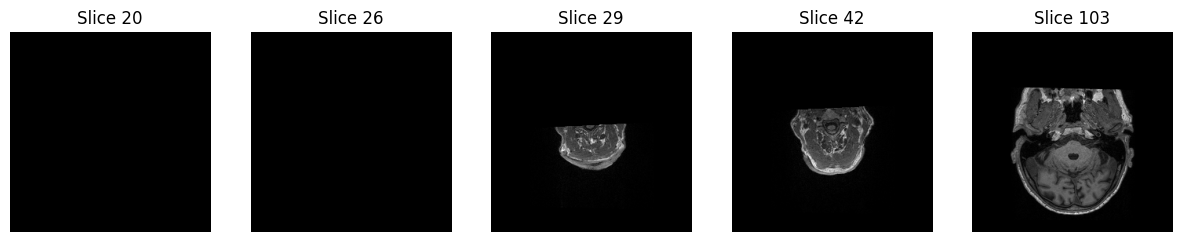

In [14]:
num_slices = 5
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Random unique slice indices from the axial dimension (depth)
slice_indices = np.random.choice(img_data.shape[2], size=num_slices, replace=False)
slice_indices = np.sort(slice_indices)

for i, slice_idx in enumerate(slice_indices):
    slice_img = img_data[:, :, slice_idx].T
    axes[i].imshow(slice_img, cmap='gray', origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.show()

### Visualizing T1 Image with Lesion Mask

This code block loads both a T1-weighted MRI image and its corresponding lesion segmentation mask for the same scan. It then displays a series of slices from a specified range, overlaying the lesion mask on top of the T1 image to highlight the location and extent of the lesion.

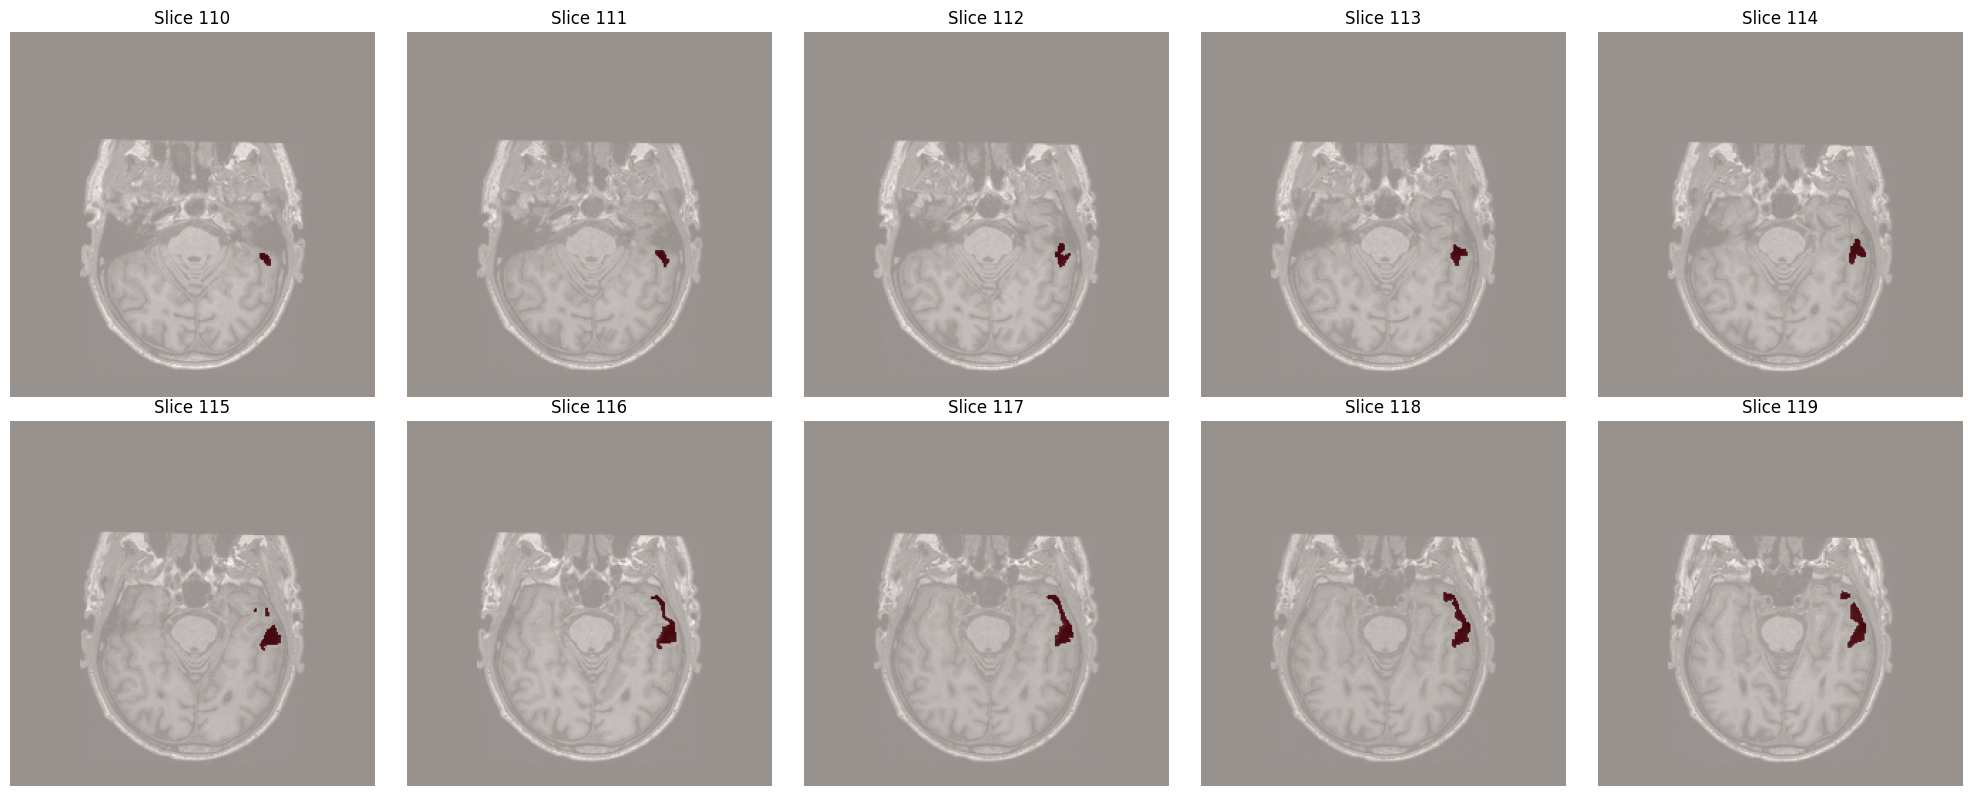

In [15]:
# Load both the T1 image and the Lesion mask
t1_file = os.path.join(data_path, 'scan_0001_T1.nii')
lesion_file = os.path.join(data_path, 'scan_0001_Lesion.nii')

t1_img = nib.load(t1_file).get_fdata()
lesion_img = nib.load(lesion_file).get_fdata()

# User-defined slice range
start_slice = 110
num_slices = 10

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_slices):
    slice_idx = start_slice + i
    t1_slice = t1_img[:, :, slice_idx].T
    lesion_slice = lesion_img[:, :, slice_idx].T

    axes[i].imshow(t1_slice, cmap='gray', origin='lower')
    axes[i].imshow(lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Visualizing Coronal and Sagittal Slices

This code block demonstrates how to extract and visualize slices from the 3D image data (`img_data`) along planes other than the standard axial view. Specifically, it shows how to display a coronal slice and a sagittal slice from the middle of the image volume.

*   Medical 3D images can be viewed as stacks of 2D slices along different orientations:
    *   **Axial (or Transverse) slices:** Imagine slicing the body horizontally, like slicing a loaf of bread. These separate the top from the bottom.
    *   **Coronal slices:** Imagine slicing the body vertically from side-to-side, separating the front (anterior) from the back (posterior). This code visualizes a coronal slice.
    *   **Sagittal slices:** Imagine slicing the body vertically from front to back, separating the left side from the right side. This code visualizes a sagittal slice.

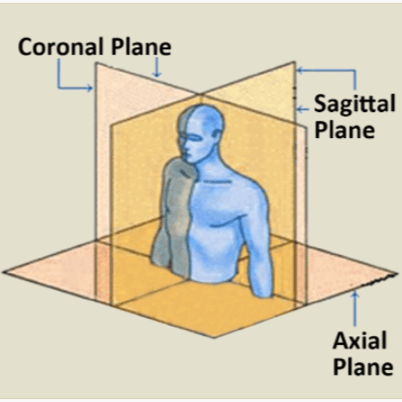

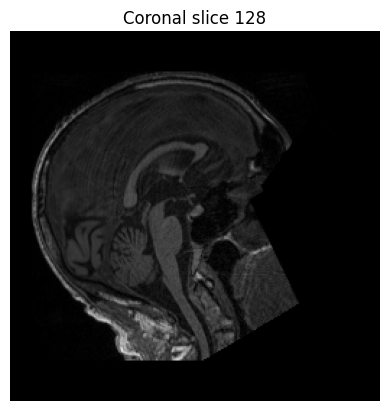

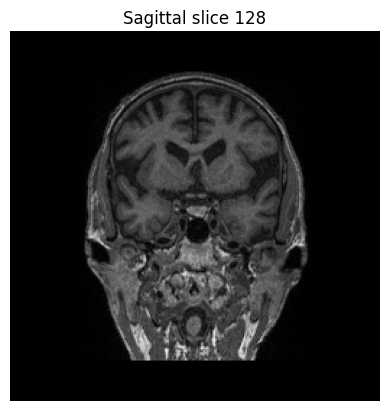

In [16]:
# Coronal slice (YZ plane)
slice_idx = img_data.shape[0] // 2
coronal_slice = img_data[slice_idx, :, :].T
plt.imshow(coronal_slice, cmap='gray', origin='lower')
plt.title(f"Coronal slice {slice_idx}")
plt.axis('off')
plt.show()

# Sagittal slice (XZ plane)
slice_idx = img_data.shape[1] // 2
sagittal_slice = img_data[:, slice_idx, :].T
plt.imshow(sagittal_slice, cmap='gray', origin='lower')
plt.title(f"Sagittal slice {slice_idx}")
plt.axis('off')
plt.show()


### Image Intensity Distribution and Non-Zero Voxels

- This code block analyzes the distribution of intensity values within the entire 3D image and calculates the proportion of voxels (3D pixels) that have non-zero intensity values.
- This helps understand the overall characteristics of the image data, such as the range of intensities present and how much of the image volume is not just background.

In [17]:
def get_lesion_percentage(lesion_path):
    lesion_img = nib.load(lesion_path).get_fdata()
    lesion_voxels = np.count_nonzero(lesion_img)
    total_voxels = lesion_img.size
    return lesion_voxels, total_voxels

# List all lesion files
lesion_files = sorted([f for f in os.listdir(data_path) if f.endswith('_Lesion.nii')])

# Overall percentage
total_lesion_voxels = 0
total_voxels = 0
for lesion_file in lesion_files:
    lesion_path = os.path.join(data_path, lesion_file)
    lesion_vox, vox = get_lesion_percentage(lesion_path)
    total_lesion_voxels += lesion_vox
    total_voxels += vox
overall_percentage = 100 * total_lesion_voxels / total_voxels
print(f"Overall lesion percentage: {overall_percentage:.2f}%")

# Per-scan percentage for a given range
start_idx = 10  # Change as needed
num_scans = 5  # Change as needed
for i in range(start_idx, min(start_idx + num_scans, len(lesion_files))):
    lesion_file = lesion_files[i]
    lesion_path = os.path.join(data_path, lesion_file)
    lesion_vox, vox = get_lesion_percentage(lesion_path)
    percentage = 100 * lesion_vox / vox
    print(f"{lesion_file}: {percentage:.2f}% lesion voxels")

Overall lesion percentage: 0.04%
scan_0029_Lesion.nii: 0.02% lesion voxels
scan_0033_Lesion.nii: 0.00% lesion voxels
scan_0036_Lesion.nii: 0.03% lesion voxels
scan_0038_Lesion.nii: 0.03% lesion voxels
scan_0040_Lesion.nii: 0.00% lesion voxels


## Preprocessing pipeline

### Look for noise scans (!!!SKIP THIS STEP!!!)

First visualize some scans

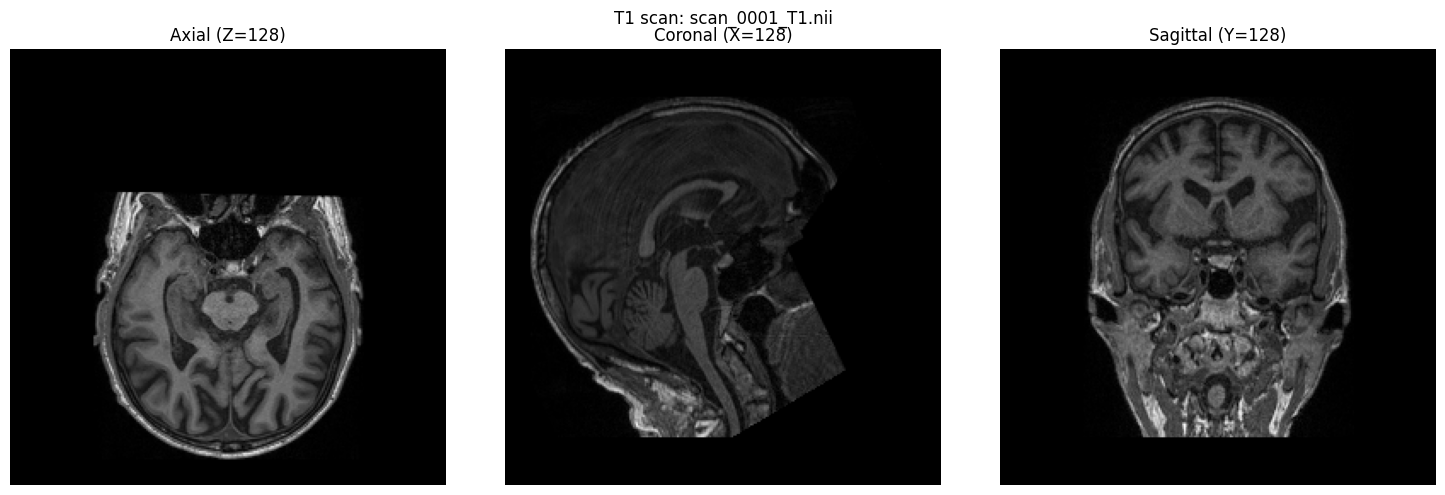

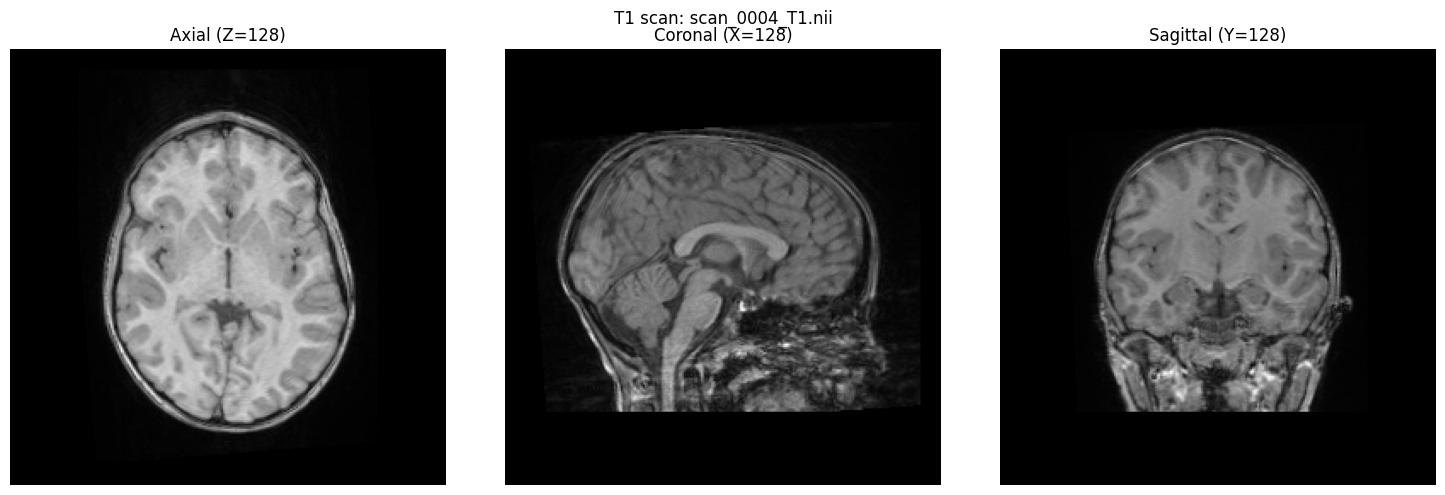

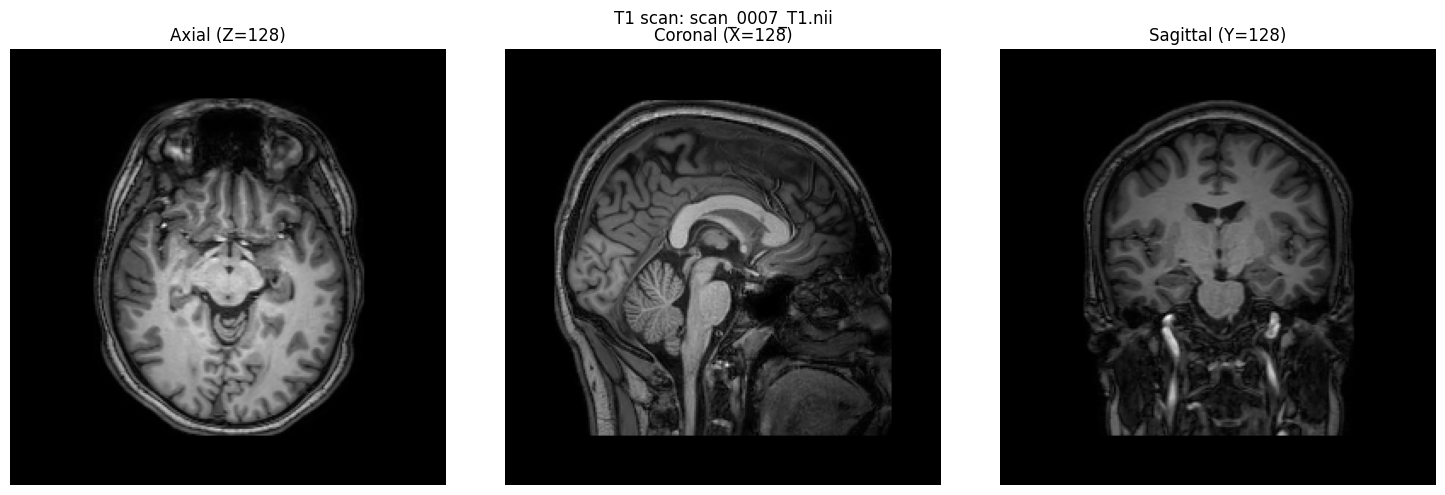

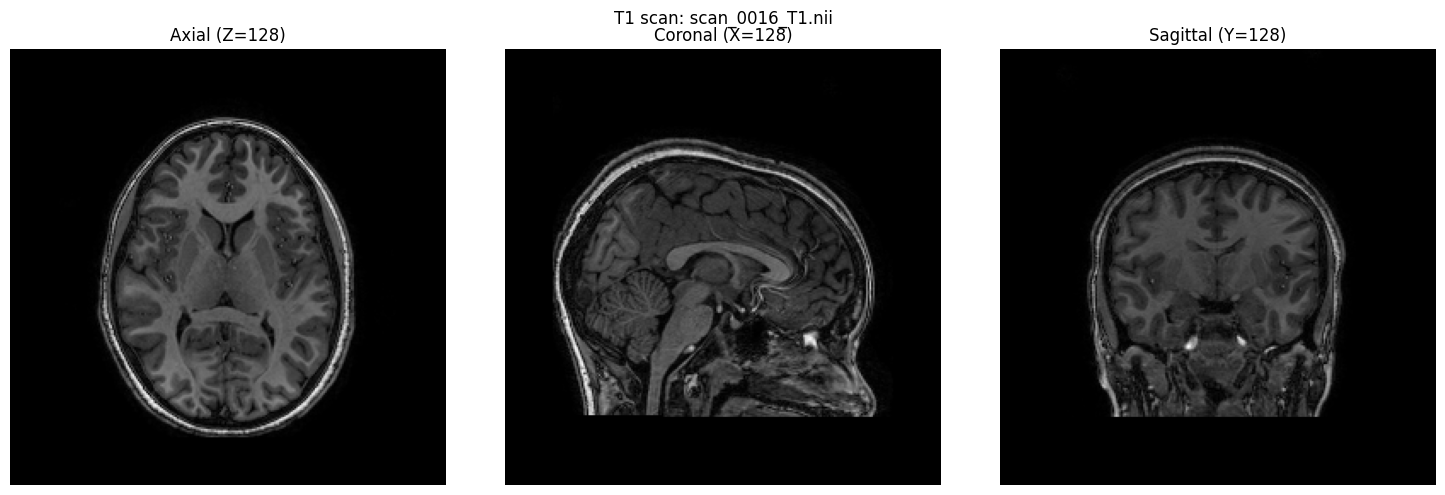

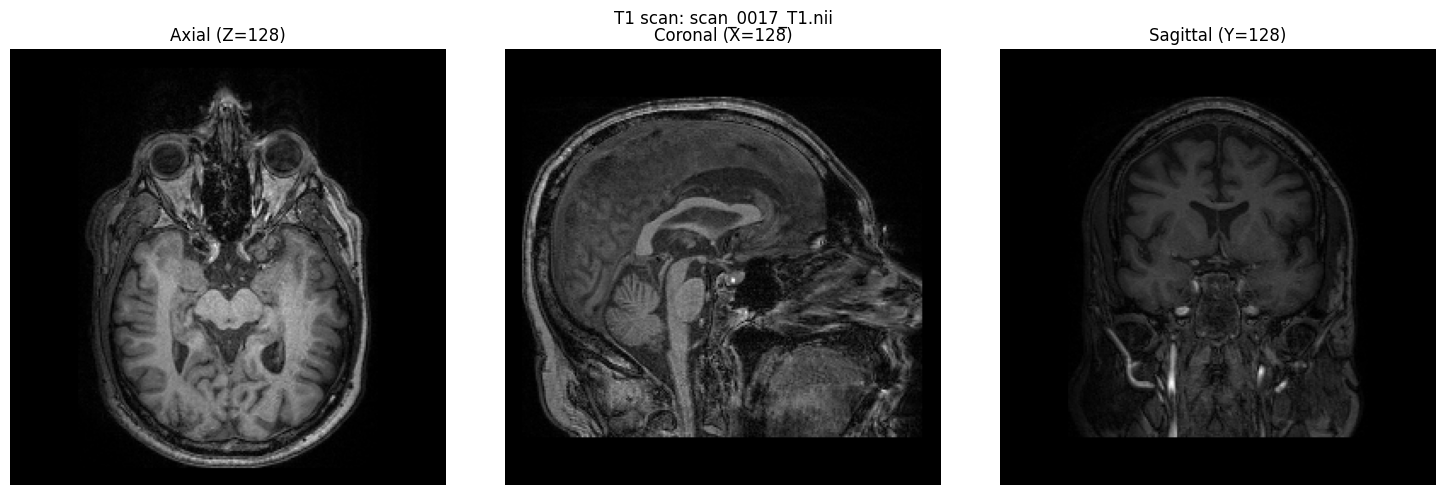

In [18]:
start_idx = 0  
num_scans = 5  

t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

for i in range(start_idx, min(start_idx + num_scans, len(t1_files))):
    t1_file = t1_files[i]
    t1_path = os.path.join(data_path, t1_file)
    t1_img = nib.load(t1_path).get_fdata()
    
    # Show central slice in each plane (axial, coronal, sagittal)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(t1_img[:, :, t1_img.shape[2] // 2].T, cmap='gray', origin='lower')
    axes[0].set_title(f'Axial (Z={t1_img.shape[2] // 2})')
    axes[0].axis('off')
    
    axes[1].imshow(t1_img[t1_img.shape[0] // 2, :, :].T, cmap='gray', origin='lower')
    axes[1].set_title(f'Coronal (X={t1_img.shape[0] // 2})')
    axes[1].axis('off')
    
    axes[2].imshow(t1_img[:, t1_img.shape[1] // 2, :].T, cmap='gray', origin='lower')
    axes[2].set_title(f'Sagittal (Y={t1_img.shape[1] // 2})')
    axes[2].axis('off')
    
    plt.suptitle(f"T1 scan: {t1_file}")
    plt.tight_layout()

Use MRQY to find stats about the scans

In [19]:
# output_folder = 'mrqy_results'
# os.makedirs(output_folder, exist_ok=True)

# # Only include T1 scans for MRQY QC
# t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])
# t1_paths = [os.path.join(data_path, f) for f in t1_files]

# print("Running MRQy on selected T1 scans...")

# for t1_path in t1_paths:
#     print(f"Processing: {os.path.basename(t1_path)}")
#     cmd = ["python", "-m", "mrqy.QC", output_folder, t1_path]
#     result = subprocess.run(cmd, capture_output=True, text=True)
#     print(result.stdout)
#     if result.stderr:
#         print("Warnings/errors:")
#         print(result.stderr)

# print(f"\nMRQy results saved in folder: {output_folder}")

### Bias field correction

Function for bias field correction using SimpleITK.

In [20]:
def bias_field_correction(input_path, output_path=None):
    """
    Perform N4 bias field correction on a NIfTI image.
    
    Parameters:
    input_path (str): Path to input NIfTI file
    output_path (str): Path to save corrected image (optional)
    
    Returns:
    numpy.ndarray: Bias-corrected image data
    """
    # Read the image
    image = sitk.ReadImage(input_path)
    
    # Convert to float32 for processing
    image = sitk.Cast(image, sitk.sitkFloat32)
    
    # Create mask (optional - helps with convergence)
    # Use Otsu thresholding to create a brain mask
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    mask = otsu_filter.Execute(image)

    # Apply N4 bias field correction
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([4] * 4) 
    corrected_image = corrector.Execute(image, mask)
    
    # Save corrected image if output path provided
    if output_path:
        sitk.WriteImage(corrected_image, output_path)
        print(f"Bias-corrected image saved to: {output_path}")
    
    # Convert back to numpy array
    corrected_array = sitk.GetArrayFromImage(corrected_image)
    
    return corrected_array

Apply bias field correction to all the scans in the directory

In [21]:
# Create output directory for corrected images
corrected_output_dir = os.path.join(data_path, "corrected_T1_scans")
os.makedirs(corrected_output_dir, exist_ok=True)

# Get all T1 files
t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

# Limit to first 15 images only
# t1_files = t1_files[:15]

print(f"Found {len(t1_files)} T1 scans to process")

# Process each T1 scan
for t1_file in tqdm(t1_files, desc="Processing T1 scans"):
    input_path = os.path.join(data_path, t1_file)

    # Create output filename (add "bias_corrected" before file extension)
    base_name = t1_file.replace('.nii', '')
    output_filename = f"{base_name}_bias_corrected.nii"
    output_path = os.path.join(corrected_output_dir, output_filename)
    
    # Skip if corrected file already exists
    if os.path.exists(output_path):
        print(f"⏭️ Skipping {t1_file} - corrected file already exists")
        continue
    
    try:
        print(f"Processing: {t1_file}")
        corrected_data = bias_field_correction(input_path, output_path)
        print(f"✓ Completed: {output_filename}")
    except Exception as e:
        print(f"✗ Error processing {t1_file}: {str(e)}")

print(f"\nBias field correction completed. Corrected images saved to: {corrected_output_dir}")

Found 551 T1 scans to process


Processing T1 scans:   0%|          | 0/551 [00:00<?, ?it/s]

Processing: scan_0001_T1.nii


Processing T1 scans:   0%|          | 1/551 [00:22<3:23:41, 22.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0001_T1_bias_corrected.nii
✓ Completed: scan_0001_T1_bias_corrected.nii
Processing: scan_0004_T1.nii


Processing T1 scans:   0%|          | 2/551 [00:44<3:21:34, 22.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0004_T1_bias_corrected.nii
✓ Completed: scan_0004_T1_bias_corrected.nii
Processing: scan_0007_T1.nii


Processing T1 scans:   1%|          | 3/551 [01:07<3:28:29, 22.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0007_T1_bias_corrected.nii
✓ Completed: scan_0007_T1_bias_corrected.nii
Processing: scan_0016_T1.nii


Processing T1 scans:   1%|          | 4/551 [01:23<3:02:19, 20.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0016_T1_bias_corrected.nii
✓ Completed: scan_0016_T1_bias_corrected.nii
Processing: scan_0017_T1.nii


Processing T1 scans:   1%|          | 5/551 [01:44<3:05:34, 20.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0017_T1_bias_corrected.nii
✓ Completed: scan_0017_T1_bias_corrected.nii
Processing: scan_0019_T1.nii


Processing T1 scans:   1%|          | 6/551 [02:05<3:05:12, 20.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0019_T1_bias_corrected.nii
✓ Completed: scan_0019_T1_bias_corrected.nii
Processing: scan_0020_T1.nii


Processing T1 scans:   1%|▏         | 7/551 [02:22<2:56:10, 19.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0020_T1_bias_corrected.nii
✓ Completed: scan_0020_T1_bias_corrected.nii
Processing: scan_0021_T1.nii


Processing T1 scans:   1%|▏         | 8/551 [02:49<3:17:06, 21.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0021_T1_bias_corrected.nii
✓ Completed: scan_0021_T1_bias_corrected.nii
Processing: scan_0024_T1.nii


Processing T1 scans:   2%|▏         | 9/551 [03:19<3:41:33, 24.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0024_T1_bias_corrected.nii
✓ Completed: scan_0024_T1_bias_corrected.nii
Processing: scan_0028_T1.nii


Processing T1 scans:   2%|▏         | 10/551 [03:45<3:44:58, 24.95s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0028_T1_bias_corrected.nii
✓ Completed: scan_0028_T1_bias_corrected.nii
Processing: scan_0029_T1.nii


Processing T1 scans:   2%|▏         | 11/551 [04:10<3:42:50, 24.76s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0029_T1_bias_corrected.nii
✓ Completed: scan_0029_T1_bias_corrected.nii
Processing: scan_0033_T1.nii


Processing T1 scans:   2%|▏         | 12/551 [04:25<3:18:02, 22.05s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0033_T1_bias_corrected.nii
✓ Completed: scan_0033_T1_bias_corrected.nii
Processing: scan_0036_T1.nii


Processing T1 scans:   2%|▏         | 13/551 [04:42<3:03:06, 20.42s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0036_T1_bias_corrected.nii
✓ Completed: scan_0036_T1_bias_corrected.nii
Processing: scan_0038_T1.nii


Processing T1 scans:   3%|▎         | 14/551 [05:07<3:13:42, 21.64s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0038_T1_bias_corrected.nii
✓ Completed: scan_0038_T1_bias_corrected.nii
Processing: scan_0040_T1.nii


Processing T1 scans:   3%|▎         | 15/551 [05:33<3:27:15, 23.20s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0040_T1_bias_corrected.nii
✓ Completed: scan_0040_T1_bias_corrected.nii
Processing: scan_0041_T1.nii


Processing T1 scans:   3%|▎         | 16/551 [05:58<3:31:14, 23.69s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0041_T1_bias_corrected.nii
✓ Completed: scan_0041_T1_bias_corrected.nii
Processing: scan_0042_T1.nii


Processing T1 scans:   3%|▎         | 17/551 [06:13<3:07:37, 21.08s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0042_T1_bias_corrected.nii
✓ Completed: scan_0042_T1_bias_corrected.nii
Processing: scan_0044_T1.nii


Processing T1 scans:   3%|▎         | 18/551 [06:31<2:59:13, 20.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0044_T1_bias_corrected.nii
✓ Completed: scan_0044_T1_bias_corrected.nii
Processing: scan_0045_T1.nii


Processing T1 scans:   3%|▎         | 19/551 [06:47<2:46:47, 18.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0045_T1_bias_corrected.nii
✓ Completed: scan_0045_T1_bias_corrected.nii
Processing: scan_0049_T1.nii


Processing T1 scans:   4%|▎         | 20/551 [07:02<2:37:26, 17.79s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0049_T1_bias_corrected.nii
✓ Completed: scan_0049_T1_bias_corrected.nii
Processing: scan_0050_T1.nii


Processing T1 scans:   4%|▍         | 21/551 [07:29<3:00:07, 20.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0050_T1_bias_corrected.nii
✓ Completed: scan_0050_T1_bias_corrected.nii
Processing: scan_0052_T1.nii


Processing T1 scans:   4%|▍         | 22/551 [07:47<2:54:05, 19.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0052_T1_bias_corrected.nii
✓ Completed: scan_0052_T1_bias_corrected.nii
Processing: scan_0053_T1.nii


Processing T1 scans:   4%|▍         | 23/551 [08:03<2:44:33, 18.70s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0053_T1_bias_corrected.nii
✓ Completed: scan_0053_T1_bias_corrected.nii
Processing: scan_0056_T1.nii


Processing T1 scans:   4%|▍         | 24/551 [08:24<2:48:12, 19.15s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0056_T1_bias_corrected.nii
✓ Completed: scan_0056_T1_bias_corrected.nii
Processing: scan_0057_T1.nii


Processing T1 scans:   5%|▍         | 25/551 [08:59<3:29:47, 23.93s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0057_T1_bias_corrected.nii
✓ Completed: scan_0057_T1_bias_corrected.nii
Processing: scan_0058_T1.nii


Processing T1 scans:   5%|▍         | 26/551 [09:25<3:36:45, 24.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0058_T1_bias_corrected.nii
✓ Completed: scan_0058_T1_bias_corrected.nii
Processing: scan_0059_T1.nii


Processing T1 scans:   5%|▍         | 27/551 [09:49<3:33:46, 24.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0059_T1_bias_corrected.nii
✓ Completed: scan_0059_T1_bias_corrected.nii
Processing: scan_0061_T1.nii


Processing T1 scans:   5%|▌         | 28/551 [10:17<3:43:22, 25.63s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0061_T1_bias_corrected.nii
✓ Completed: scan_0061_T1_bias_corrected.nii
Processing: scan_0062_T1.nii


Processing T1 scans:   5%|▌         | 29/551 [10:44<3:46:24, 26.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0062_T1_bias_corrected.nii
✓ Completed: scan_0062_T1_bias_corrected.nii
Processing: scan_0063_T1.nii


Processing T1 scans:   5%|▌         | 30/551 [11:01<3:21:55, 23.25s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0063_T1_bias_corrected.nii
✓ Completed: scan_0063_T1_bias_corrected.nii
Processing: scan_0070_T1.nii


Processing T1 scans:   6%|▌         | 31/551 [11:26<3:24:33, 23.60s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0070_T1_bias_corrected.nii
✓ Completed: scan_0070_T1_bias_corrected.nii
Processing: scan_0073_T1.nii


Processing T1 scans:   6%|▌         | 32/551 [11:48<3:22:03, 23.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0073_T1_bias_corrected.nii
✓ Completed: scan_0073_T1_bias_corrected.nii
Processing: scan_0077_T1.nii


Processing T1 scans:   6%|▌         | 33/551 [12:09<3:14:39, 22.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0077_T1_bias_corrected.nii
✓ Completed: scan_0077_T1_bias_corrected.nii
Processing: scan_0080_T1.nii


Processing T1 scans:   6%|▌         | 34/551 [12:27<3:03:18, 21.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0080_T1_bias_corrected.nii
✓ Completed: scan_0080_T1_bias_corrected.nii
Processing: scan_0086_T1.nii


Processing T1 scans:   6%|▋         | 35/551 [13:01<3:35:42, 25.08s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0086_T1_bias_corrected.nii
✓ Completed: scan_0086_T1_bias_corrected.nii
Processing: scan_0089_T1.nii


Processing T1 scans:   7%|▋         | 36/551 [13:24<3:29:10, 24.37s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0089_T1_bias_corrected.nii
✓ Completed: scan_0089_T1_bias_corrected.nii
Processing: scan_0091_T1.nii


Processing T1 scans:   7%|▋         | 37/551 [13:45<3:19:28, 23.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0091_T1_bias_corrected.nii
✓ Completed: scan_0091_T1_bias_corrected.nii
Processing: scan_0093_T1.nii


Processing T1 scans:   7%|▋         | 38/551 [14:21<3:52:56, 27.24s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0093_T1_bias_corrected.nii
✓ Completed: scan_0093_T1_bias_corrected.nii
Processing: scan_0096_T1.nii


Processing T1 scans:   7%|▋         | 39/551 [14:46<3:46:25, 26.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0096_T1_bias_corrected.nii
✓ Completed: scan_0096_T1_bias_corrected.nii
Processing: scan_0097_T1.nii


Processing T1 scans:   7%|▋         | 40/551 [15:02<3:18:07, 23.26s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0097_T1_bias_corrected.nii
✓ Completed: scan_0097_T1_bias_corrected.nii
Processing: scan_0099_T1.nii


Processing T1 scans:   7%|▋         | 41/551 [15:26<3:19:24, 23.46s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0099_T1_bias_corrected.nii
✓ Completed: scan_0099_T1_bias_corrected.nii
Processing: scan_0101_T1.nii


Processing T1 scans:   8%|▊         | 42/551 [15:51<3:24:49, 24.14s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0101_T1_bias_corrected.nii
✓ Completed: scan_0101_T1_bias_corrected.nii
Processing: scan_0104_T1.nii


Processing T1 scans:   8%|▊         | 43/551 [16:12<3:15:42, 23.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0104_T1_bias_corrected.nii
✓ Completed: scan_0104_T1_bias_corrected.nii
Processing: scan_0105_T1.nii


Processing T1 scans:   8%|▊         | 44/551 [16:27<2:55:20, 20.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0105_T1_bias_corrected.nii
✓ Completed: scan_0105_T1_bias_corrected.nii
Processing: scan_0106_T1.nii


Processing T1 scans:   8%|▊         | 45/551 [16:43<2:41:13, 19.12s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0106_T1_bias_corrected.nii
✓ Completed: scan_0106_T1_bias_corrected.nii
Processing: scan_0107_T1.nii


Processing T1 scans:   8%|▊         | 46/551 [17:06<2:51:20, 20.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0107_T1_bias_corrected.nii
✓ Completed: scan_0107_T1_bias_corrected.nii
Processing: scan_0108_T1.nii


Processing T1 scans:   9%|▊         | 47/551 [17:26<2:50:34, 20.31s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0108_T1_bias_corrected.nii
✓ Completed: scan_0108_T1_bias_corrected.nii
Processing: scan_0109_T1.nii


Processing T1 scans:   9%|▊         | 48/551 [17:44<2:44:08, 19.58s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0109_T1_bias_corrected.nii
✓ Completed: scan_0109_T1_bias_corrected.nii
Processing: scan_0110_T1.nii


Processing T1 scans:   9%|▉         | 49/551 [18:06<2:49:19, 20.24s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0110_T1_bias_corrected.nii
✓ Completed: scan_0110_T1_bias_corrected.nii
Processing: scan_0114_T1.nii


Processing T1 scans:   9%|▉         | 50/551 [18:28<2:55:12, 20.98s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0114_T1_bias_corrected.nii
✓ Completed: scan_0114_T1_bias_corrected.nii
Processing: scan_0115_T1.nii


Processing T1 scans:   9%|▉         | 51/551 [18:59<3:18:33, 23.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0115_T1_bias_corrected.nii
✓ Completed: scan_0115_T1_bias_corrected.nii
Processing: scan_0116_T1.nii


Processing T1 scans:   9%|▉         | 52/551 [19:19<3:08:36, 22.68s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0116_T1_bias_corrected.nii
✓ Completed: scan_0116_T1_bias_corrected.nii
Processing: scan_0118_T1.nii


Processing T1 scans:  10%|▉         | 53/551 [19:44<3:14:24, 23.42s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0118_T1_bias_corrected.nii
✓ Completed: scan_0118_T1_bias_corrected.nii
Processing: scan_0120_T1.nii


Processing T1 scans:  10%|▉         | 54/551 [20:04<3:05:37, 22.41s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0120_T1_bias_corrected.nii
✓ Completed: scan_0120_T1_bias_corrected.nii
Processing: scan_0122_T1.nii


Processing T1 scans:  10%|▉         | 55/551 [20:31<3:15:06, 23.60s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0122_T1_bias_corrected.nii
✓ Completed: scan_0122_T1_bias_corrected.nii
Processing: scan_0125_T1.nii


Processing T1 scans:  10%|█         | 56/551 [20:53<3:13:04, 23.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0125_T1_bias_corrected.nii
✓ Completed: scan_0125_T1_bias_corrected.nii
Processing: scan_0129_T1.nii


Processing T1 scans:  10%|█         | 57/551 [21:16<3:09:34, 23.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0129_T1_bias_corrected.nii
✓ Completed: scan_0129_T1_bias_corrected.nii
Processing: scan_0130_T1.nii


Processing T1 scans:  11%|█         | 58/551 [21:32<2:52:40, 21.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0130_T1_bias_corrected.nii
✓ Completed: scan_0130_T1_bias_corrected.nii
Processing: scan_0131_T1.nii


Processing T1 scans:  11%|█         | 59/551 [21:52<2:50:50, 20.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0131_T1_bias_corrected.nii
✓ Completed: scan_0131_T1_bias_corrected.nii
Processing: scan_0134_T1.nii


Processing T1 scans:  11%|█         | 60/551 [22:11<2:45:59, 20.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0134_T1_bias_corrected.nii
✓ Completed: scan_0134_T1_bias_corrected.nii
Processing: scan_0139_T1.nii


Processing T1 scans:  11%|█         | 61/551 [22:32<2:46:54, 20.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0139_T1_bias_corrected.nii
✓ Completed: scan_0139_T1_bias_corrected.nii
Processing: scan_0140_T1.nii


Processing T1 scans:  11%|█▏        | 62/551 [22:46<2:29:46, 18.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0140_T1_bias_corrected.nii
✓ Completed: scan_0140_T1_bias_corrected.nii
Processing: scan_0141_T1.nii


Processing T1 scans:  11%|█▏        | 63/551 [23:01<2:22:01, 17.46s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0141_T1_bias_corrected.nii
✓ Completed: scan_0141_T1_bias_corrected.nii
Processing: scan_0142_T1.nii


Processing T1 scans:  12%|█▏        | 64/551 [23:13<2:07:14, 15.68s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0142_T1_bias_corrected.nii
✓ Completed: scan_0142_T1_bias_corrected.nii
Processing: scan_0144_T1.nii


Processing T1 scans:  12%|█▏        | 65/551 [23:29<2:08:56, 15.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0144_T1_bias_corrected.nii
✓ Completed: scan_0144_T1_bias_corrected.nii
Processing: scan_0145_T1.nii


Processing T1 scans:  12%|█▏        | 66/551 [23:48<2:16:43, 16.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0145_T1_bias_corrected.nii
✓ Completed: scan_0145_T1_bias_corrected.nii
Processing: scan_0146_T1.nii


Processing T1 scans:  12%|█▏        | 67/551 [24:05<2:16:05, 16.87s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0146_T1_bias_corrected.nii
✓ Completed: scan_0146_T1_bias_corrected.nii
Processing: scan_0147_T1.nii


Processing T1 scans:  12%|█▏        | 68/551 [24:25<2:22:49, 17.74s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0147_T1_bias_corrected.nii
✓ Completed: scan_0147_T1_bias_corrected.nii
Processing: scan_0148_T1.nii


Processing T1 scans:  13%|█▎        | 69/551 [24:48<2:36:22, 19.46s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0148_T1_bias_corrected.nii
✓ Completed: scan_0148_T1_bias_corrected.nii
Processing: scan_0149_T1.nii


Processing T1 scans:  13%|█▎        | 70/551 [25:11<2:44:41, 20.54s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0149_T1_bias_corrected.nii
✓ Completed: scan_0149_T1_bias_corrected.nii
Processing: scan_0150_T1.nii


Processing T1 scans:  13%|█▎        | 71/551 [25:40<3:04:14, 23.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0150_T1_bias_corrected.nii
✓ Completed: scan_0150_T1_bias_corrected.nii
Processing: scan_0152_T1.nii


Processing T1 scans:  13%|█▎        | 72/551 [26:02<3:00:49, 22.65s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0152_T1_bias_corrected.nii
✓ Completed: scan_0152_T1_bias_corrected.nii
Processing: scan_0153_T1.nii


Processing T1 scans:  13%|█▎        | 73/551 [26:21<2:52:24, 21.64s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0153_T1_bias_corrected.nii
✓ Completed: scan_0153_T1_bias_corrected.nii
Processing: scan_0156_T1.nii


Processing T1 scans:  13%|█▎        | 74/551 [26:41<2:47:30, 21.07s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0156_T1_bias_corrected.nii
✓ Completed: scan_0156_T1_bias_corrected.nii
Processing: scan_0157_T1.nii


Processing T1 scans:  14%|█▎        | 75/551 [26:58<2:37:10, 19.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0157_T1_bias_corrected.nii
✓ Completed: scan_0157_T1_bias_corrected.nii
Processing: scan_0158_T1.nii


Processing T1 scans:  14%|█▍        | 76/551 [27:13<2:25:17, 18.35s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0158_T1_bias_corrected.nii
✓ Completed: scan_0158_T1_bias_corrected.nii
Processing: scan_0159_T1.nii


Processing T1 scans:  14%|█▍        | 77/551 [27:32<2:28:01, 18.74s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0159_T1_bias_corrected.nii
✓ Completed: scan_0159_T1_bias_corrected.nii
Processing: scan_0160_T1.nii


Processing T1 scans:  14%|█▍        | 78/551 [27:55<2:35:41, 19.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0160_T1_bias_corrected.nii
✓ Completed: scan_0160_T1_bias_corrected.nii
Processing: scan_0163_T1.nii


Processing T1 scans:  14%|█▍        | 79/551 [28:09<2:23:45, 18.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0163_T1_bias_corrected.nii
✓ Completed: scan_0163_T1_bias_corrected.nii
Processing: scan_0164_T1.nii


Processing T1 scans:  15%|█▍        | 80/551 [28:35<2:39:37, 20.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0164_T1_bias_corrected.nii
✓ Completed: scan_0164_T1_bias_corrected.nii
Processing: scan_0167_T1.nii


Processing T1 scans:  15%|█▍        | 81/551 [28:59<2:49:12, 21.60s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0167_T1_bias_corrected.nii
✓ Completed: scan_0167_T1_bias_corrected.nii
Processing: scan_0169_T1.nii


Processing T1 scans:  15%|█▍        | 82/551 [29:24<2:56:15, 22.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0169_T1_bias_corrected.nii
✓ Completed: scan_0169_T1_bias_corrected.nii
Processing: scan_0171_T1.nii


Processing T1 scans:  15%|█▌        | 83/551 [29:39<2:39:15, 20.42s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0171_T1_bias_corrected.nii
✓ Completed: scan_0171_T1_bias_corrected.nii
Processing: scan_0173_T1.nii


Processing T1 scans:  15%|█▌        | 84/551 [30:07<2:55:41, 22.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0173_T1_bias_corrected.nii
✓ Completed: scan_0173_T1_bias_corrected.nii
Processing: scan_0178_T1.nii


Processing T1 scans:  15%|█▌        | 85/551 [30:35<3:09:13, 24.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0178_T1_bias_corrected.nii
✓ Completed: scan_0178_T1_bias_corrected.nii
Processing: scan_0179_T1.nii


Processing T1 scans:  16%|█▌        | 86/551 [30:51<2:48:12, 21.71s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0179_T1_bias_corrected.nii
✓ Completed: scan_0179_T1_bias_corrected.nii
Processing: scan_0180_T1.nii


Processing T1 scans:  16%|█▌        | 87/551 [31:15<2:53:12, 22.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0180_T1_bias_corrected.nii
✓ Completed: scan_0180_T1_bias_corrected.nii
Processing: scan_0181_T1.nii


Processing T1 scans:  16%|█▌        | 88/551 [31:45<3:10:23, 24.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0181_T1_bias_corrected.nii
✓ Completed: scan_0181_T1_bias_corrected.nii
Processing: scan_0182_T1.nii


Processing T1 scans:  16%|█▌        | 89/551 [32:01<2:49:53, 22.06s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0182_T1_bias_corrected.nii
✓ Completed: scan_0182_T1_bias_corrected.nii
Processing: scan_0185_T1.nii


Processing T1 scans:  16%|█▋        | 90/551 [32:17<2:36:13, 20.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0185_T1_bias_corrected.nii
✓ Completed: scan_0185_T1_bias_corrected.nii
Processing: scan_0189_T1.nii


Processing T1 scans:  17%|█▋        | 91/551 [32:43<2:48:38, 22.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0189_T1_bias_corrected.nii
✓ Completed: scan_0189_T1_bias_corrected.nii
Processing: scan_0193_T1.nii


Processing T1 scans:  17%|█▋        | 92/551 [33:07<2:52:57, 22.61s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0193_T1_bias_corrected.nii
✓ Completed: scan_0193_T1_bias_corrected.nii
Processing: scan_0194_T1.nii


Processing T1 scans:  17%|█▋        | 93/551 [33:24<2:39:00, 20.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0194_T1_bias_corrected.nii
✓ Completed: scan_0194_T1_bias_corrected.nii
Processing: scan_0197_T1.nii


Processing T1 scans:  17%|█▋        | 94/551 [33:37<2:20:06, 18.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0197_T1_bias_corrected.nii
✓ Completed: scan_0197_T1_bias_corrected.nii
Processing: scan_0199_T1.nii


Processing T1 scans:  17%|█▋        | 95/551 [33:55<2:18:53, 18.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0199_T1_bias_corrected.nii
✓ Completed: scan_0199_T1_bias_corrected.nii
Processing: scan_0203_T1.nii


Processing T1 scans:  17%|█▋        | 96/551 [34:11<2:14:52, 17.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0203_T1_bias_corrected.nii
✓ Completed: scan_0203_T1_bias_corrected.nii
Processing: scan_0204_T1.nii


Processing T1 scans:  18%|█▊        | 97/551 [34:27<2:11:09, 17.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0204_T1_bias_corrected.nii
✓ Completed: scan_0204_T1_bias_corrected.nii
Processing: scan_0205_T1.nii


Processing T1 scans:  18%|█▊        | 98/551 [34:58<2:41:35, 21.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0205_T1_bias_corrected.nii
✓ Completed: scan_0205_T1_bias_corrected.nii
Processing: scan_0206_T1.nii


Processing T1 scans:  18%|█▊        | 99/551 [35:16<2:33:10, 20.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0206_T1_bias_corrected.nii
✓ Completed: scan_0206_T1_bias_corrected.nii
Processing: scan_0207_T1.nii


Processing T1 scans:  18%|█▊        | 100/551 [35:49<3:00:30, 24.01s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0207_T1_bias_corrected.nii
✓ Completed: scan_0207_T1_bias_corrected.nii
Processing: scan_0209_T1.nii


Processing T1 scans:  18%|█▊        | 101/551 [36:11<2:56:30, 23.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0209_T1_bias_corrected.nii
✓ Completed: scan_0209_T1_bias_corrected.nii
Processing: scan_0210_T1.nii


Processing T1 scans:  19%|█▊        | 102/551 [36:47<3:22:48, 27.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0210_T1_bias_corrected.nii
✓ Completed: scan_0210_T1_bias_corrected.nii
Processing: scan_0211_T1.nii


Processing T1 scans:  19%|█▊        | 103/551 [37:03<2:57:27, 23.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0211_T1_bias_corrected.nii
✓ Completed: scan_0211_T1_bias_corrected.nii
Processing: scan_0212_T1.nii


Processing T1 scans:  19%|█▉        | 104/551 [37:25<2:55:08, 23.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0212_T1_bias_corrected.nii
✓ Completed: scan_0212_T1_bias_corrected.nii
Processing: scan_0213_T1.nii


Processing T1 scans:  19%|█▉        | 105/551 [37:46<2:47:43, 22.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0213_T1_bias_corrected.nii
✓ Completed: scan_0213_T1_bias_corrected.nii
Processing: scan_0214_T1.nii


Processing T1 scans:  19%|█▉        | 106/551 [38:11<2:52:13, 23.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0214_T1_bias_corrected.nii
✓ Completed: scan_0214_T1_bias_corrected.nii
Processing: scan_0217_T1.nii


Processing T1 scans:  19%|█▉        | 107/551 [38:30<2:43:13, 22.06s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0217_T1_bias_corrected.nii
✓ Completed: scan_0217_T1_bias_corrected.nii
Processing: scan_0219_T1.nii


Processing T1 scans:  20%|█▉        | 108/551 [38:47<2:31:38, 20.54s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0219_T1_bias_corrected.nii
✓ Completed: scan_0219_T1_bias_corrected.nii
Processing: scan_0220_T1.nii


Processing T1 scans:  20%|█▉        | 109/551 [39:08<2:33:13, 20.80s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0220_T1_bias_corrected.nii
✓ Completed: scan_0220_T1_bias_corrected.nii
Processing: scan_0222_T1.nii


Processing T1 scans:  20%|█▉        | 110/551 [39:31<2:37:32, 21.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0222_T1_bias_corrected.nii
✓ Completed: scan_0222_T1_bias_corrected.nii
Processing: scan_0224_T1.nii


Processing T1 scans:  20%|██        | 111/551 [39:48<2:27:50, 20.16s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0224_T1_bias_corrected.nii
✓ Completed: scan_0224_T1_bias_corrected.nii
Processing: scan_0225_T1.nii


Processing T1 scans:  20%|██        | 112/551 [40:12<2:34:19, 21.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0225_T1_bias_corrected.nii
✓ Completed: scan_0225_T1_bias_corrected.nii
Processing: scan_0227_T1.nii


Processing T1 scans:  21%|██        | 113/551 [40:26<2:18:52, 19.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0227_T1_bias_corrected.nii
✓ Completed: scan_0227_T1_bias_corrected.nii
Processing: scan_0228_T1.nii


Processing T1 scans:  21%|██        | 114/551 [40:50<2:29:30, 20.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0228_T1_bias_corrected.nii
✓ Completed: scan_0228_T1_bias_corrected.nii
Processing: scan_0229_T1.nii


Processing T1 scans:  21%|██        | 115/551 [41:09<2:26:53, 20.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0229_T1_bias_corrected.nii
✓ Completed: scan_0229_T1_bias_corrected.nii
Processing: scan_0234_T1.nii


Processing T1 scans:  21%|██        | 116/551 [41:33<2:33:07, 21.12s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0234_T1_bias_corrected.nii
✓ Completed: scan_0234_T1_bias_corrected.nii
Processing: scan_0236_T1.nii


Processing T1 scans:  21%|██        | 117/551 [42:03<2:52:58, 23.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0236_T1_bias_corrected.nii
✓ Completed: scan_0236_T1_bias_corrected.nii
Processing: scan_0237_T1.nii


Processing T1 scans:  21%|██▏       | 118/551 [42:23<2:42:50, 22.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0237_T1_bias_corrected.nii
✓ Completed: scan_0237_T1_bias_corrected.nii
Processing: scan_0243_T1.nii


Processing T1 scans:  22%|██▏       | 119/551 [42:40<2:31:43, 21.07s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0243_T1_bias_corrected.nii
✓ Completed: scan_0243_T1_bias_corrected.nii
Processing: scan_0245_T1.nii


Processing T1 scans:  22%|██▏       | 120/551 [42:54<2:16:09, 18.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0245_T1_bias_corrected.nii
✓ Completed: scan_0245_T1_bias_corrected.nii
Processing: scan_0246_T1.nii


Processing T1 scans:  22%|██▏       | 121/551 [43:15<2:19:05, 19.41s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0246_T1_bias_corrected.nii
✓ Completed: scan_0246_T1_bias_corrected.nii
Processing: scan_0247_T1.nii


Processing T1 scans:  22%|██▏       | 122/551 [43:34<2:18:27, 19.37s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0247_T1_bias_corrected.nii
✓ Completed: scan_0247_T1_bias_corrected.nii
Processing: scan_0248_T1.nii


Processing T1 scans:  22%|██▏       | 123/551 [43:53<2:16:40, 19.16s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0248_T1_bias_corrected.nii
✓ Completed: scan_0248_T1_bias_corrected.nii
Processing: scan_0249_T1.nii


Processing T1 scans:  23%|██▎       | 124/551 [44:10<2:12:39, 18.64s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0249_T1_bias_corrected.nii
✓ Completed: scan_0249_T1_bias_corrected.nii
Processing: scan_0254_T1.nii


Processing T1 scans:  23%|██▎       | 125/551 [44:33<2:22:01, 20.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0254_T1_bias_corrected.nii
✓ Completed: scan_0254_T1_bias_corrected.nii
Processing: scan_0256_T1.nii


Processing T1 scans:  23%|██▎       | 126/551 [45:00<2:36:16, 22.06s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0256_T1_bias_corrected.nii
✓ Completed: scan_0256_T1_bias_corrected.nii
Processing: scan_0258_T1.nii


Processing T1 scans:  23%|██▎       | 127/551 [45:24<2:39:22, 22.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0258_T1_bias_corrected.nii
✓ Completed: scan_0258_T1_bias_corrected.nii
Processing: scan_0261_T1.nii


Processing T1 scans:  23%|██▎       | 128/551 [45:46<2:38:37, 22.50s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0261_T1_bias_corrected.nii
✓ Completed: scan_0261_T1_bias_corrected.nii
Processing: scan_0270_T1.nii


Processing T1 scans:  23%|██▎       | 129/551 [46:09<2:39:04, 22.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0270_T1_bias_corrected.nii
✓ Completed: scan_0270_T1_bias_corrected.nii
Processing: scan_0271_T1.nii


Processing T1 scans:  24%|██▎       | 130/551 [46:29<2:33:07, 21.82s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0271_T1_bias_corrected.nii
✓ Completed: scan_0271_T1_bias_corrected.nii
Processing: scan_0273_T1.nii


Processing T1 scans:  24%|██▍       | 131/551 [46:48<2:27:42, 21.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0273_T1_bias_corrected.nii
✓ Completed: scan_0273_T1_bias_corrected.nii
Processing: scan_0275_T1.nii


Processing T1 scans:  24%|██▍       | 132/551 [47:15<2:39:04, 22.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0275_T1_bias_corrected.nii
✓ Completed: scan_0275_T1_bias_corrected.nii
Processing: scan_0277_T1.nii


Processing T1 scans:  24%|██▍       | 133/551 [47:32<2:27:29, 21.17s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0277_T1_bias_corrected.nii
✓ Completed: scan_0277_T1_bias_corrected.nii
Processing: scan_0279_T1.nii


Processing T1 scans:  24%|██▍       | 134/551 [47:52<2:24:19, 20.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0279_T1_bias_corrected.nii
✓ Completed: scan_0279_T1_bias_corrected.nii
Processing: scan_0281_T1.nii


Processing T1 scans:  25%|██▍       | 135/551 [48:12<2:20:58, 20.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0281_T1_bias_corrected.nii
✓ Completed: scan_0281_T1_bias_corrected.nii
Processing: scan_0283_T1.nii


Processing T1 scans:  25%|██▍       | 136/551 [48:31<2:18:59, 20.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0283_T1_bias_corrected.nii
✓ Completed: scan_0283_T1_bias_corrected.nii
Processing: scan_0284_T1.nii


Processing T1 scans:  25%|██▍       | 137/551 [49:02<2:41:46, 23.45s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0284_T1_bias_corrected.nii
✓ Completed: scan_0284_T1_bias_corrected.nii
Processing: scan_0290_T1.nii


Processing T1 scans:  25%|██▌       | 138/551 [49:19<2:26:37, 21.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0290_T1_bias_corrected.nii
✓ Completed: scan_0290_T1_bias_corrected.nii
Processing: scan_0294_T1.nii


Processing T1 scans:  25%|██▌       | 139/551 [49:35<2:16:40, 19.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0294_T1_bias_corrected.nii
✓ Completed: scan_0294_T1_bias_corrected.nii
Processing: scan_0296_T1.nii


Processing T1 scans:  25%|██▌       | 140/551 [49:56<2:17:42, 20.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0296_T1_bias_corrected.nii
✓ Completed: scan_0296_T1_bias_corrected.nii
Processing: scan_0297_T1.nii


Processing T1 scans:  26%|██▌       | 141/551 [50:14<2:13:47, 19.58s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0297_T1_bias_corrected.nii
✓ Completed: scan_0297_T1_bias_corrected.nii
Processing: scan_0298_T1.nii


Processing T1 scans:  26%|██▌       | 142/551 [50:37<2:19:46, 20.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0298_T1_bias_corrected.nii
✓ Completed: scan_0298_T1_bias_corrected.nii
Processing: scan_0299_T1.nii


Processing T1 scans:  26%|██▌       | 143/551 [51:05<2:35:17, 22.84s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0299_T1_bias_corrected.nii
✓ Completed: scan_0299_T1_bias_corrected.nii
Processing: scan_0301_T1.nii


Processing T1 scans:  26%|██▌       | 144/551 [51:26<2:30:21, 22.17s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0301_T1_bias_corrected.nii
✓ Completed: scan_0301_T1_bias_corrected.nii
Processing: scan_0302_T1.nii


Processing T1 scans:  26%|██▋       | 145/551 [51:48<2:29:19, 22.07s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0302_T1_bias_corrected.nii
✓ Completed: scan_0302_T1_bias_corrected.nii
Processing: scan_0308_T1.nii


Processing T1 scans:  26%|██▋       | 146/551 [52:17<2:44:25, 24.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0308_T1_bias_corrected.nii
✓ Completed: scan_0308_T1_bias_corrected.nii
Processing: scan_0310_T1.nii


Processing T1 scans:  27%|██▋       | 147/551 [52:43<2:45:31, 24.58s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0310_T1_bias_corrected.nii
✓ Completed: scan_0310_T1_bias_corrected.nii
Processing: scan_0311_T1.nii


Processing T1 scans:  27%|██▋       | 148/551 [52:57<2:25:16, 21.63s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0311_T1_bias_corrected.nii
✓ Completed: scan_0311_T1_bias_corrected.nii
Processing: scan_0315_T1.nii


Processing T1 scans:  27%|██▋       | 149/551 [53:24<2:34:15, 23.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0315_T1_bias_corrected.nii
✓ Completed: scan_0315_T1_bias_corrected.nii
Processing: scan_0316_T1.nii


Processing T1 scans:  27%|██▋       | 150/551 [53:46<2:31:52, 22.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0316_T1_bias_corrected.nii
✓ Completed: scan_0316_T1_bias_corrected.nii
Processing: scan_0320_T1.nii


Processing T1 scans:  27%|██▋       | 151/551 [54:07<2:29:15, 22.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0320_T1_bias_corrected.nii
✓ Completed: scan_0320_T1_bias_corrected.nii
Processing: scan_0323_T1.nii


Processing T1 scans:  28%|██▊       | 152/551 [54:29<2:28:06, 22.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0323_T1_bias_corrected.nii
✓ Completed: scan_0323_T1_bias_corrected.nii
Processing: scan_0324_T1.nii


Processing T1 scans:  28%|██▊       | 153/551 [54:51<2:26:35, 22.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0324_T1_bias_corrected.nii
✓ Completed: scan_0324_T1_bias_corrected.nii
Processing: scan_0328_T1.nii


Processing T1 scans:  28%|██▊       | 154/551 [55:06<2:11:51, 19.93s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0328_T1_bias_corrected.nii
✓ Completed: scan_0328_T1_bias_corrected.nii
Processing: scan_0329_T1.nii


Processing T1 scans:  28%|██▊       | 155/551 [55:28<2:15:44, 20.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0329_T1_bias_corrected.nii
✓ Completed: scan_0329_T1_bias_corrected.nii
Processing: scan_0331_T1.nii


Processing T1 scans:  28%|██▊       | 156/551 [55:48<2:15:09, 20.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0331_T1_bias_corrected.nii
✓ Completed: scan_0331_T1_bias_corrected.nii
Processing: scan_0333_T1.nii


Processing T1 scans:  28%|██▊       | 157/551 [56:04<2:04:37, 18.98s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0333_T1_bias_corrected.nii
✓ Completed: scan_0333_T1_bias_corrected.nii
Processing: scan_0340_T1.nii


Processing T1 scans:  29%|██▊       | 158/551 [56:31<2:21:38, 21.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0340_T1_bias_corrected.nii
✓ Completed: scan_0340_T1_bias_corrected.nii
Processing: scan_0341_T1.nii


Processing T1 scans:  29%|██▉       | 159/551 [56:51<2:17:35, 21.06s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0341_T1_bias_corrected.nii
✓ Completed: scan_0341_T1_bias_corrected.nii
Processing: scan_0344_T1.nii


Processing T1 scans:  29%|██▉       | 160/551 [57:13<2:18:47, 21.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0344_T1_bias_corrected.nii
✓ Completed: scan_0344_T1_bias_corrected.nii
Processing: scan_0346_T1.nii


Processing T1 scans:  29%|██▉       | 161/551 [57:42<2:34:26, 23.76s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0346_T1_bias_corrected.nii
✓ Completed: scan_0346_T1_bias_corrected.nii
Processing: scan_0351_T1.nii


Processing T1 scans:  29%|██▉       | 162/551 [58:11<2:43:49, 25.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0351_T1_bias_corrected.nii
✓ Completed: scan_0351_T1_bias_corrected.nii
Processing: scan_0354_T1.nii


Processing T1 scans:  30%|██▉       | 163/551 [58:38<2:46:00, 25.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0354_T1_bias_corrected.nii
✓ Completed: scan_0354_T1_bias_corrected.nii
Processing: scan_0359_T1.nii


Processing T1 scans:  30%|██▉       | 164/551 [58:58<2:35:48, 24.16s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0359_T1_bias_corrected.nii
✓ Completed: scan_0359_T1_bias_corrected.nii
Processing: scan_0360_T1.nii


Processing T1 scans:  30%|██▉       | 165/551 [59:19<2:29:06, 23.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0360_T1_bias_corrected.nii
✓ Completed: scan_0360_T1_bias_corrected.nii
Processing: scan_0361_T1.nii


Processing T1 scans:  30%|███       | 166/551 [59:43<2:29:24, 23.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0361_T1_bias_corrected.nii
✓ Completed: scan_0361_T1_bias_corrected.nii
Processing: scan_0362_T1.nii


Processing T1 scans:  30%|███       | 167/551 [1:00:00<2:16:36, 21.34s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0362_T1_bias_corrected.nii
✓ Completed: scan_0362_T1_bias_corrected.nii
Processing: scan_0365_T1.nii


Processing T1 scans:  30%|███       | 168/551 [1:00:19<2:12:34, 20.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0365_T1_bias_corrected.nii
✓ Completed: scan_0365_T1_bias_corrected.nii
Processing: scan_0367_T1.nii


Processing T1 scans:  31%|███       | 169/551 [1:00:40<2:12:44, 20.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0367_T1_bias_corrected.nii
✓ Completed: scan_0367_T1_bias_corrected.nii
Processing: scan_0368_T1.nii


Processing T1 scans:  31%|███       | 170/551 [1:00:53<1:56:34, 18.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0368_T1_bias_corrected.nii
✓ Completed: scan_0368_T1_bias_corrected.nii
Processing: scan_0371_T1.nii


Processing T1 scans:  31%|███       | 171/551 [1:01:14<2:01:31, 19.19s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0371_T1_bias_corrected.nii
✓ Completed: scan_0371_T1_bias_corrected.nii
Processing: scan_0379_T1.nii


Processing T1 scans:  31%|███       | 172/551 [1:01:36<2:07:08, 20.13s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0379_T1_bias_corrected.nii
✓ Completed: scan_0379_T1_bias_corrected.nii
Processing: scan_0380_T1.nii


Processing T1 scans:  31%|███▏      | 173/551 [1:01:57<2:08:07, 20.34s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0380_T1_bias_corrected.nii
✓ Completed: scan_0380_T1_bias_corrected.nii
Processing: scan_0381_T1.nii


Processing T1 scans:  32%|███▏      | 174/551 [1:02:26<2:24:22, 22.98s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0381_T1_bias_corrected.nii
✓ Completed: scan_0381_T1_bias_corrected.nii
Processing: scan_0382_T1.nii


Processing T1 scans:  32%|███▏      | 175/551 [1:02:49<2:24:15, 23.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0382_T1_bias_corrected.nii
✓ Completed: scan_0382_T1_bias_corrected.nii
Processing: scan_0385_T1.nii


Processing T1 scans:  32%|███▏      | 176/551 [1:03:27<2:50:34, 27.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0385_T1_bias_corrected.nii
✓ Completed: scan_0385_T1_bias_corrected.nii
Processing: scan_0386_T1.nii


Processing T1 scans:  32%|███▏      | 177/551 [1:03:38<2:20:54, 22.61s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0386_T1_bias_corrected.nii
✓ Completed: scan_0386_T1_bias_corrected.nii
Processing: scan_0387_T1.nii


Processing T1 scans:  32%|███▏      | 178/551 [1:03:54<2:07:29, 20.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0387_T1_bias_corrected.nii
✓ Completed: scan_0387_T1_bias_corrected.nii
Processing: scan_0390_T1.nii


Processing T1 scans:  32%|███▏      | 179/551 [1:04:21<2:19:07, 22.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0390_T1_bias_corrected.nii
✓ Completed: scan_0390_T1_bias_corrected.nii
Processing: scan_0393_T1.nii


Processing T1 scans:  33%|███▎      | 180/551 [1:04:42<2:16:35, 22.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0393_T1_bias_corrected.nii
✓ Completed: scan_0393_T1_bias_corrected.nii
Processing: scan_0394_T1.nii


Processing T1 scans:  33%|███▎      | 181/551 [1:05:08<2:23:51, 23.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0394_T1_bias_corrected.nii
✓ Completed: scan_0394_T1_bias_corrected.nii
Processing: scan_0395_T1.nii


Processing T1 scans:  33%|███▎      | 182/551 [1:05:32<2:23:47, 23.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0395_T1_bias_corrected.nii
✓ Completed: scan_0395_T1_bias_corrected.nii
Processing: scan_0398_T1.nii


Processing T1 scans:  33%|███▎      | 183/551 [1:05:58<2:29:04, 24.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0398_T1_bias_corrected.nii
✓ Completed: scan_0398_T1_bias_corrected.nii
Processing: scan_0399_T1.nii


Processing T1 scans:  33%|███▎      | 184/551 [1:06:25<2:33:27, 25.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0399_T1_bias_corrected.nii
✓ Completed: scan_0399_T1_bias_corrected.nii
Processing: scan_0403_T1.nii


Processing T1 scans:  34%|███▎      | 185/551 [1:06:46<2:25:13, 23.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0403_T1_bias_corrected.nii
✓ Completed: scan_0403_T1_bias_corrected.nii
Processing: scan_0405_T1.nii


Processing T1 scans:  34%|███▍      | 186/551 [1:07:07<2:19:55, 23.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0405_T1_bias_corrected.nii
✓ Completed: scan_0405_T1_bias_corrected.nii
Processing: scan_0406_T1.nii


Processing T1 scans:  34%|███▍      | 187/551 [1:07:30<2:19:39, 23.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0406_T1_bias_corrected.nii
✓ Completed: scan_0406_T1_bias_corrected.nii
Processing: scan_0407_T1.nii


Processing T1 scans:  34%|███▍      | 188/551 [1:07:50<2:13:49, 22.12s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0407_T1_bias_corrected.nii
✓ Completed: scan_0407_T1_bias_corrected.nii
Processing: scan_0408_T1.nii


Processing T1 scans:  34%|███▍      | 189/551 [1:08:06<2:01:51, 20.20s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0408_T1_bias_corrected.nii
✓ Completed: scan_0408_T1_bias_corrected.nii
Processing: scan_0413_T1.nii


Processing T1 scans:  34%|███▍      | 190/551 [1:08:23<1:56:43, 19.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0413_T1_bias_corrected.nii
✓ Completed: scan_0413_T1_bias_corrected.nii
Processing: scan_0414_T1.nii


Processing T1 scans:  35%|███▍      | 191/551 [1:08:52<2:13:32, 22.26s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0414_T1_bias_corrected.nii
✓ Completed: scan_0414_T1_bias_corrected.nii
Processing: scan_0415_T1.nii


Processing T1 scans:  35%|███▍      | 192/551 [1:09:16<2:15:37, 22.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0415_T1_bias_corrected.nii
✓ Completed: scan_0415_T1_bias_corrected.nii
Processing: scan_0416_T1.nii


Processing T1 scans:  35%|███▌      | 193/551 [1:09:39<2:15:14, 22.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0416_T1_bias_corrected.nii
✓ Completed: scan_0416_T1_bias_corrected.nii
Processing: scan_0417_T1.nii


Processing T1 scans:  35%|███▌      | 194/551 [1:10:01<2:13:40, 22.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0417_T1_bias_corrected.nii
✓ Completed: scan_0417_T1_bias_corrected.nii
Processing: scan_0419_T1.nii


Processing T1 scans:  35%|███▌      | 195/551 [1:10:26<2:18:09, 23.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0419_T1_bias_corrected.nii
✓ Completed: scan_0419_T1_bias_corrected.nii
Processing: scan_0420_T1.nii


Processing T1 scans:  36%|███▌      | 196/551 [1:10:49<2:17:57, 23.32s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0420_T1_bias_corrected.nii
✓ Completed: scan_0420_T1_bias_corrected.nii
Processing: scan_0424_T1.nii


Processing T1 scans:  36%|███▌      | 197/551 [1:11:11<2:15:24, 22.95s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0424_T1_bias_corrected.nii
✓ Completed: scan_0424_T1_bias_corrected.nii
Processing: scan_0425_T1.nii


Processing T1 scans:  36%|███▌      | 198/551 [1:11:37<2:19:17, 23.68s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0425_T1_bias_corrected.nii
✓ Completed: scan_0425_T1_bias_corrected.nii
Processing: scan_0427_T1.nii


Processing T1 scans:  36%|███▌      | 199/551 [1:12:05<2:27:43, 25.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0427_T1_bias_corrected.nii
✓ Completed: scan_0427_T1_bias_corrected.nii
Processing: scan_0428_T1.nii


Processing T1 scans:  36%|███▋      | 200/551 [1:12:35<2:35:26, 26.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0428_T1_bias_corrected.nii
✓ Completed: scan_0428_T1_bias_corrected.nii
Processing: scan_0429_T1.nii


Processing T1 scans:  36%|███▋      | 201/551 [1:12:58<2:27:53, 25.35s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0429_T1_bias_corrected.nii
✓ Completed: scan_0429_T1_bias_corrected.nii
Processing: scan_0430_T1.nii


Processing T1 scans:  37%|███▋      | 202/551 [1:13:17<2:16:33, 23.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0430_T1_bias_corrected.nii
✓ Completed: scan_0430_T1_bias_corrected.nii
Processing: scan_0431_T1.nii


Processing T1 scans:  37%|███▋      | 203/551 [1:13:33<2:03:23, 21.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0431_T1_bias_corrected.nii
✓ Completed: scan_0431_T1_bias_corrected.nii
Processing: scan_0433_T1.nii


Processing T1 scans:  37%|███▋      | 204/551 [1:13:55<2:03:57, 21.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0433_T1_bias_corrected.nii
✓ Completed: scan_0433_T1_bias_corrected.nii
Processing: scan_0440_T1.nii


Processing T1 scans:  37%|███▋      | 205/551 [1:14:21<2:11:30, 22.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0440_T1_bias_corrected.nii
✓ Completed: scan_0440_T1_bias_corrected.nii
Processing: scan_0442_T1.nii


Processing T1 scans:  37%|███▋      | 206/551 [1:14:45<2:13:45, 23.26s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0442_T1_bias_corrected.nii
✓ Completed: scan_0442_T1_bias_corrected.nii
Processing: scan_0444_T1.nii


Processing T1 scans:  38%|███▊      | 207/551 [1:15:07<2:10:23, 22.74s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0444_T1_bias_corrected.nii
✓ Completed: scan_0444_T1_bias_corrected.nii
Processing: scan_0445_T1.nii


Processing T1 scans:  38%|███▊      | 208/551 [1:15:30<2:10:48, 22.88s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0445_T1_bias_corrected.nii
✓ Completed: scan_0445_T1_bias_corrected.nii
Processing: scan_0446_T1.nii


Processing T1 scans:  38%|███▊      | 209/551 [1:15:54<2:12:57, 23.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0446_T1_bias_corrected.nii
✓ Completed: scan_0446_T1_bias_corrected.nii
Processing: scan_0450_T1.nii


Processing T1 scans:  38%|███▊      | 210/551 [1:16:24<2:23:45, 25.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0450_T1_bias_corrected.nii
✓ Completed: scan_0450_T1_bias_corrected.nii
Processing: scan_0451_T1.nii


Processing T1 scans:  38%|███▊      | 211/551 [1:16:43<2:13:17, 23.52s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0451_T1_bias_corrected.nii
✓ Completed: scan_0451_T1_bias_corrected.nii
Processing: scan_0452_T1.nii


Processing T1 scans:  38%|███▊      | 212/551 [1:17:10<2:18:16, 24.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0452_T1_bias_corrected.nii
✓ Completed: scan_0452_T1_bias_corrected.nii
Processing: scan_0453_T1.nii


Processing T1 scans:  39%|███▊      | 213/551 [1:17:30<2:09:47, 23.04s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0453_T1_bias_corrected.nii
✓ Completed: scan_0453_T1_bias_corrected.nii
Processing: scan_0455_T1.nii


Processing T1 scans:  39%|███▉      | 214/551 [1:17:49<2:03:32, 22.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0455_T1_bias_corrected.nii
✓ Completed: scan_0455_T1_bias_corrected.nii
Processing: scan_0457_T1.nii


Processing T1 scans:  39%|███▉      | 215/551 [1:18:15<2:09:23, 23.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0457_T1_bias_corrected.nii
✓ Completed: scan_0457_T1_bias_corrected.nii
Processing: scan_0459_T1.nii


Processing T1 scans:  39%|███▉      | 216/551 [1:18:34<2:02:37, 21.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0459_T1_bias_corrected.nii
✓ Completed: scan_0459_T1_bias_corrected.nii
Processing: scan_0461_T1.nii


Processing T1 scans:  39%|███▉      | 217/551 [1:18:54<1:58:18, 21.25s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0461_T1_bias_corrected.nii
✓ Completed: scan_0461_T1_bias_corrected.nii
Processing: scan_0462_T1.nii


Processing T1 scans:  40%|███▉      | 218/551 [1:19:04<1:39:54, 18.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0462_T1_bias_corrected.nii
✓ Completed: scan_0462_T1_bias_corrected.nii
Processing: scan_0467_T1.nii


Processing T1 scans:  40%|███▉      | 219/551 [1:19:26<1:45:03, 18.99s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0467_T1_bias_corrected.nii
✓ Completed: scan_0467_T1_bias_corrected.nii
Processing: scan_0468_T1.nii


Processing T1 scans:  40%|███▉      | 220/551 [1:19:56<2:04:10, 22.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0468_T1_bias_corrected.nii
✓ Completed: scan_0468_T1_bias_corrected.nii
Processing: scan_0470_T1.nii


Processing T1 scans:  40%|████      | 221/551 [1:20:18<2:01:33, 22.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0470_T1_bias_corrected.nii
✓ Completed: scan_0470_T1_bias_corrected.nii
Processing: scan_0471_T1.nii


Processing T1 scans:  40%|████      | 222/551 [1:20:47<2:13:25, 24.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0471_T1_bias_corrected.nii
✓ Completed: scan_0471_T1_bias_corrected.nii
Processing: scan_0475_T1.nii


Processing T1 scans:  40%|████      | 223/551 [1:21:01<1:56:19, 21.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0475_T1_bias_corrected.nii
✓ Completed: scan_0475_T1_bias_corrected.nii
Processing: scan_0476_T1.nii


Processing T1 scans:  41%|████      | 224/551 [1:21:26<2:01:51, 22.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0476_T1_bias_corrected.nii
✓ Completed: scan_0476_T1_bias_corrected.nii
Processing: scan_0478_T1.nii


Processing T1 scans:  41%|████      | 225/551 [1:21:46<1:57:48, 21.68s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0478_T1_bias_corrected.nii
✓ Completed: scan_0478_T1_bias_corrected.nii
Processing: scan_0479_T1.nii


Processing T1 scans:  41%|████      | 226/551 [1:22:10<2:01:18, 22.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0479_T1_bias_corrected.nii
✓ Completed: scan_0479_T1_bias_corrected.nii
Processing: scan_0483_T1.nii


Processing T1 scans:  41%|████      | 227/551 [1:22:30<1:56:35, 21.59s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0483_T1_bias_corrected.nii
✓ Completed: scan_0483_T1_bias_corrected.nii
Processing: scan_0485_T1.nii


Processing T1 scans:  41%|████▏     | 228/551 [1:22:58<2:06:07, 23.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0485_T1_bias_corrected.nii
✓ Completed: scan_0485_T1_bias_corrected.nii
Processing: scan_0490_T1.nii


Processing T1 scans:  42%|████▏     | 229/551 [1:23:13<1:53:16, 21.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0490_T1_bias_corrected.nii
✓ Completed: scan_0490_T1_bias_corrected.nii
Processing: scan_0491_T1.nii


Processing T1 scans:  42%|████▏     | 230/551 [1:23:28<1:43:06, 19.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0491_T1_bias_corrected.nii
✓ Completed: scan_0491_T1_bias_corrected.nii
Processing: scan_0492_T1.nii


Processing T1 scans:  42%|████▏     | 231/551 [1:23:53<1:51:24, 20.89s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0492_T1_bias_corrected.nii
✓ Completed: scan_0492_T1_bias_corrected.nii
Processing: scan_0493_T1.nii


Processing T1 scans:  42%|████▏     | 232/551 [1:24:11<1:46:56, 20.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0493_T1_bias_corrected.nii
✓ Completed: scan_0493_T1_bias_corrected.nii
Processing: scan_0498_T1.nii


Processing T1 scans:  42%|████▏     | 233/551 [1:24:34<1:50:24, 20.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0498_T1_bias_corrected.nii
✓ Completed: scan_0498_T1_bias_corrected.nii
Processing: scan_0502_T1.nii


Processing T1 scans:  42%|████▏     | 234/551 [1:24:59<1:56:31, 22.05s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0502_T1_bias_corrected.nii
✓ Completed: scan_0502_T1_bias_corrected.nii
Processing: scan_0503_T1.nii


Processing T1 scans:  43%|████▎     | 235/551 [1:25:24<2:01:43, 23.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0503_T1_bias_corrected.nii
✓ Completed: scan_0503_T1_bias_corrected.nii
Processing: scan_0504_T1.nii


Processing T1 scans:  43%|████▎     | 236/551 [1:25:49<2:03:15, 23.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0504_T1_bias_corrected.nii
✓ Completed: scan_0504_T1_bias_corrected.nii
Processing: scan_0505_T1.nii


Processing T1 scans:  43%|████▎     | 237/551 [1:26:14<2:05:29, 23.98s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0505_T1_bias_corrected.nii
✓ Completed: scan_0505_T1_bias_corrected.nii
Processing: scan_0507_T1.nii


Processing T1 scans:  43%|████▎     | 238/551 [1:26:33<1:57:59, 22.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0507_T1_bias_corrected.nii
✓ Completed: scan_0507_T1_bias_corrected.nii
Processing: scan_0508_T1.nii


Processing T1 scans:  43%|████▎     | 239/551 [1:26:58<2:00:08, 23.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0508_T1_bias_corrected.nii
✓ Completed: scan_0508_T1_bias_corrected.nii
Processing: scan_0512_T1.nii


Processing T1 scans:  44%|████▎     | 240/551 [1:27:12<1:46:38, 20.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0512_T1_bias_corrected.nii
✓ Completed: scan_0512_T1_bias_corrected.nii
Processing: scan_0513_T1.nii


Processing T1 scans:  44%|████▎     | 241/551 [1:27:23<1:30:25, 17.50s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0513_T1_bias_corrected.nii
✓ Completed: scan_0513_T1_bias_corrected.nii
Processing: scan_0517_T1.nii


Processing T1 scans:  44%|████▍     | 242/551 [1:27:46<1:40:04, 19.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0517_T1_bias_corrected.nii
✓ Completed: scan_0517_T1_bias_corrected.nii
Processing: scan_0518_T1.nii


Processing T1 scans:  44%|████▍     | 243/551 [1:28:08<1:42:43, 20.01s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0518_T1_bias_corrected.nii
✓ Completed: scan_0518_T1_bias_corrected.nii
Processing: scan_0519_T1.nii


Processing T1 scans:  44%|████▍     | 244/551 [1:28:23<1:34:35, 18.49s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0519_T1_bias_corrected.nii
✓ Completed: scan_0519_T1_bias_corrected.nii
Processing: scan_0522_T1.nii


Processing T1 scans:  44%|████▍     | 245/551 [1:28:43<1:37:36, 19.14s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0522_T1_bias_corrected.nii
✓ Completed: scan_0522_T1_bias_corrected.nii
Processing: scan_0523_T1.nii


Processing T1 scans:  45%|████▍     | 246/551 [1:28:58<1:30:21, 17.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0523_T1_bias_corrected.nii
✓ Completed: scan_0523_T1_bias_corrected.nii
Processing: scan_0526_T1.nii


Processing T1 scans:  45%|████▍     | 247/551 [1:29:23<1:40:28, 19.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0526_T1_bias_corrected.nii
✓ Completed: scan_0526_T1_bias_corrected.nii
Processing: scan_0527_T1.nii


Processing T1 scans:  45%|████▌     | 248/551 [1:29:44<1:43:07, 20.42s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0527_T1_bias_corrected.nii
✓ Completed: scan_0527_T1_bias_corrected.nii
Processing: scan_0530_T1.nii


Processing T1 scans:  45%|████▌     | 249/551 [1:30:13<1:55:21, 22.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0530_T1_bias_corrected.nii
✓ Completed: scan_0530_T1_bias_corrected.nii
Processing: scan_0533_T1.nii


Processing T1 scans:  45%|████▌     | 250/551 [1:30:38<1:58:13, 23.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0533_T1_bias_corrected.nii
✓ Completed: scan_0533_T1_bias_corrected.nii
Processing: scan_0537_T1.nii


Processing T1 scans:  46%|████▌     | 251/551 [1:30:59<1:52:58, 22.60s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0537_T1_bias_corrected.nii
✓ Completed: scan_0537_T1_bias_corrected.nii
Processing: scan_0538_T1.nii


Processing T1 scans:  46%|████▌     | 252/551 [1:31:19<1:49:02, 21.88s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0538_T1_bias_corrected.nii
✓ Completed: scan_0538_T1_bias_corrected.nii
Processing: scan_0540_T1.nii


Processing T1 scans:  46%|████▌     | 253/551 [1:31:41<1:49:06, 21.97s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0540_T1_bias_corrected.nii
✓ Completed: scan_0540_T1_bias_corrected.nii
Processing: scan_0541_T1.nii


Processing T1 scans:  46%|████▌     | 254/551 [1:32:02<1:47:00, 21.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0541_T1_bias_corrected.nii
✓ Completed: scan_0541_T1_bias_corrected.nii
Processing: scan_0545_T1.nii


Processing T1 scans:  46%|████▋     | 255/551 [1:32:21<1:43:08, 20.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0545_T1_bias_corrected.nii
✓ Completed: scan_0545_T1_bias_corrected.nii
Processing: scan_0546_T1.nii


Processing T1 scans:  46%|████▋     | 256/551 [1:32:41<1:40:44, 20.49s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0546_T1_bias_corrected.nii
✓ Completed: scan_0546_T1_bias_corrected.nii
Processing: scan_0553_T1.nii


Processing T1 scans:  47%|████▋     | 257/551 [1:32:53<1:28:06, 17.98s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0553_T1_bias_corrected.nii
✓ Completed: scan_0553_T1_bias_corrected.nii
Processing: scan_0557_T1.nii


Processing T1 scans:  47%|████▋     | 258/551 [1:33:13<1:31:08, 18.66s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0557_T1_bias_corrected.nii
✓ Completed: scan_0557_T1_bias_corrected.nii
Processing: scan_0558_T1.nii


Processing T1 scans:  47%|████▋     | 259/551 [1:33:42<1:45:51, 21.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0558_T1_bias_corrected.nii
✓ Completed: scan_0558_T1_bias_corrected.nii
Processing: scan_0559_T1.nii


Processing T1 scans:  47%|████▋     | 260/551 [1:33:56<1:34:39, 19.52s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0559_T1_bias_corrected.nii
✓ Completed: scan_0559_T1_bias_corrected.nii
Processing: scan_0561_T1.nii


Processing T1 scans:  47%|████▋     | 261/551 [1:34:20<1:40:44, 20.84s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0561_T1_bias_corrected.nii
✓ Completed: scan_0561_T1_bias_corrected.nii
Processing: scan_0564_T1.nii


Processing T1 scans:  48%|████▊     | 262/551 [1:34:40<1:39:31, 20.66s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0564_T1_bias_corrected.nii
✓ Completed: scan_0564_T1_bias_corrected.nii
Processing: scan_0565_T1.nii


Processing T1 scans:  48%|████▊     | 263/551 [1:35:03<1:41:51, 21.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0565_T1_bias_corrected.nii
✓ Completed: scan_0565_T1_bias_corrected.nii
Processing: scan_0566_T1.nii


Processing T1 scans:  48%|████▊     | 264/551 [1:35:21<1:36:40, 20.21s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0566_T1_bias_corrected.nii
✓ Completed: scan_0566_T1_bias_corrected.nii
Processing: scan_0567_T1.nii


Processing T1 scans:  48%|████▊     | 265/551 [1:35:41<1:36:08, 20.17s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0567_T1_bias_corrected.nii
✓ Completed: scan_0567_T1_bias_corrected.nii
Processing: scan_0569_T1.nii


Processing T1 scans:  48%|████▊     | 266/551 [1:36:02<1:37:14, 20.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0569_T1_bias_corrected.nii
✓ Completed: scan_0569_T1_bias_corrected.nii
Processing: scan_0571_T1.nii


Processing T1 scans:  48%|████▊     | 267/551 [1:36:26<1:42:02, 21.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0571_T1_bias_corrected.nii
✓ Completed: scan_0571_T1_bias_corrected.nii
Processing: scan_0573_T1.nii


Processing T1 scans:  49%|████▊     | 268/551 [1:36:48<1:42:26, 21.72s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0573_T1_bias_corrected.nii
✓ Completed: scan_0573_T1_bias_corrected.nii
Processing: scan_0574_T1.nii


Processing T1 scans:  49%|████▉     | 269/551 [1:37:02<1:30:37, 19.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0574_T1_bias_corrected.nii
✓ Completed: scan_0574_T1_bias_corrected.nii
Processing: scan_0577_T1.nii


Processing T1 scans:  49%|████▉     | 270/551 [1:37:16<1:23:24, 17.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0577_T1_bias_corrected.nii
✓ Completed: scan_0577_T1_bias_corrected.nii
Processing: scan_0581_T1.nii


Processing T1 scans:  49%|████▉     | 271/551 [1:37:34<1:23:49, 17.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0581_T1_bias_corrected.nii
✓ Completed: scan_0581_T1_bias_corrected.nii
Processing: scan_0582_T1.nii


Processing T1 scans:  49%|████▉     | 272/551 [1:37:52<1:23:19, 17.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0582_T1_bias_corrected.nii
✓ Completed: scan_0582_T1_bias_corrected.nii
Processing: scan_0584_T1.nii


Processing T1 scans:  50%|████▉     | 273/551 [1:38:14<1:28:18, 19.06s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0584_T1_bias_corrected.nii
✓ Completed: scan_0584_T1_bias_corrected.nii
Processing: scan_0585_T1.nii


Processing T1 scans:  50%|████▉     | 274/551 [1:38:32<1:26:52, 18.82s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0585_T1_bias_corrected.nii
✓ Completed: scan_0585_T1_bias_corrected.nii
Processing: scan_0588_T1.nii


Processing T1 scans:  50%|████▉     | 275/551 [1:39:02<1:41:01, 21.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0588_T1_bias_corrected.nii
✓ Completed: scan_0588_T1_bias_corrected.nii
Processing: scan_0590_T1.nii


Processing T1 scans:  50%|█████     | 276/551 [1:39:18<1:33:43, 20.45s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0590_T1_bias_corrected.nii
✓ Completed: scan_0590_T1_bias_corrected.nii
Processing: scan_0591_T1.nii


Processing T1 scans:  50%|█████     | 277/551 [1:39:40<1:34:36, 20.72s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0591_T1_bias_corrected.nii
✓ Completed: scan_0591_T1_bias_corrected.nii
Processing: scan_0592_T1.nii


Processing T1 scans:  50%|█████     | 278/551 [1:40:04<1:38:24, 21.63s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0592_T1_bias_corrected.nii
✓ Completed: scan_0592_T1_bias_corrected.nii
Processing: scan_0595_T1.nii


Processing T1 scans:  51%|█████     | 279/551 [1:40:20<1:31:30, 20.19s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0595_T1_bias_corrected.nii
✓ Completed: scan_0595_T1_bias_corrected.nii
Processing: scan_0596_T1.nii


Processing T1 scans:  51%|█████     | 280/551 [1:40:42<1:33:26, 20.69s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0596_T1_bias_corrected.nii
✓ Completed: scan_0596_T1_bias_corrected.nii
Processing: scan_0603_T1.nii


Processing T1 scans:  51%|█████     | 281/551 [1:41:02<1:31:47, 20.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0603_T1_bias_corrected.nii
✓ Completed: scan_0603_T1_bias_corrected.nii
Processing: scan_0604_T1.nii


Processing T1 scans:  51%|█████     | 282/551 [1:41:22<1:30:42, 20.23s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0604_T1_bias_corrected.nii
✓ Completed: scan_0604_T1_bias_corrected.nii
Processing: scan_0605_T1.nii


Processing T1 scans:  51%|█████▏    | 283/551 [1:41:33<1:18:23, 17.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0605_T1_bias_corrected.nii
✓ Completed: scan_0605_T1_bias_corrected.nii
Processing: scan_0606_T1.nii


Processing T1 scans:  52%|█████▏    | 284/551 [1:41:53<1:20:52, 18.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0606_T1_bias_corrected.nii
✓ Completed: scan_0606_T1_bias_corrected.nii
Processing: scan_0610_T1.nii


Processing T1 scans:  52%|█████▏    | 285/551 [1:42:13<1:23:13, 18.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0610_T1_bias_corrected.nii
✓ Completed: scan_0610_T1_bias_corrected.nii
Processing: scan_0611_T1.nii


Processing T1 scans:  52%|█████▏    | 286/551 [1:42:30<1:21:07, 18.37s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0611_T1_bias_corrected.nii
✓ Completed: scan_0611_T1_bias_corrected.nii
Processing: scan_0612_T1.nii


Processing T1 scans:  52%|█████▏    | 287/551 [1:42:49<1:20:45, 18.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0612_T1_bias_corrected.nii
✓ Completed: scan_0612_T1_bias_corrected.nii
Processing: scan_0613_T1.nii


Processing T1 scans:  52%|█████▏    | 288/551 [1:43:11<1:25:36, 19.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0613_T1_bias_corrected.nii
✓ Completed: scan_0613_T1_bias_corrected.nii
Processing: scan_0614_T1.nii


Processing T1 scans:  52%|█████▏    | 289/551 [1:43:23<1:15:52, 17.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0614_T1_bias_corrected.nii
✓ Completed: scan_0614_T1_bias_corrected.nii
Processing: scan_0615_T1.nii


Processing T1 scans:  53%|█████▎    | 290/551 [1:43:38<1:11:53, 16.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0615_T1_bias_corrected.nii
✓ Completed: scan_0615_T1_bias_corrected.nii
Processing: scan_0616_T1.nii


Processing T1 scans:  53%|█████▎    | 291/551 [1:43:59<1:17:16, 17.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0616_T1_bias_corrected.nii
✓ Completed: scan_0616_T1_bias_corrected.nii
Processing: scan_0619_T1.nii


Processing T1 scans:  53%|█████▎    | 292/551 [1:44:22<1:24:32, 19.58s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0619_T1_bias_corrected.nii
✓ Completed: scan_0619_T1_bias_corrected.nii
Processing: scan_0624_T1.nii


Processing T1 scans:  53%|█████▎    | 293/551 [1:44:44<1:27:14, 20.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0624_T1_bias_corrected.nii
✓ Completed: scan_0624_T1_bias_corrected.nii
Processing: scan_0625_T1.nii


Processing T1 scans:  53%|█████▎    | 294/551 [1:45:05<1:27:07, 20.34s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0625_T1_bias_corrected.nii
✓ Completed: scan_0625_T1_bias_corrected.nii
Processing: scan_0626_T1.nii


Processing T1 scans:  54%|█████▎    | 295/551 [1:45:18<1:17:45, 18.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0626_T1_bias_corrected.nii
✓ Completed: scan_0626_T1_bias_corrected.nii
Processing: scan_0627_T1.nii


Processing T1 scans:  54%|█████▎    | 296/551 [1:45:33<1:12:46, 17.12s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0627_T1_bias_corrected.nii
✓ Completed: scan_0627_T1_bias_corrected.nii
Processing: scan_0629_T1.nii


Processing T1 scans:  54%|█████▍    | 297/551 [1:45:50<1:12:34, 17.14s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0629_T1_bias_corrected.nii
✓ Completed: scan_0629_T1_bias_corrected.nii
Processing: scan_0632_T1.nii


Processing T1 scans:  54%|█████▍    | 298/551 [1:46:09<1:15:02, 17.80s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0632_T1_bias_corrected.nii
✓ Completed: scan_0632_T1_bias_corrected.nii
Processing: scan_0633_T1.nii


Processing T1 scans:  54%|█████▍    | 299/551 [1:46:25<1:12:19, 17.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0633_T1_bias_corrected.nii
✓ Completed: scan_0633_T1_bias_corrected.nii
Processing: scan_0635_T1.nii


Processing T1 scans:  54%|█████▍    | 300/551 [1:46:44<1:14:42, 17.86s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0635_T1_bias_corrected.nii
✓ Completed: scan_0635_T1_bias_corrected.nii
Processing: scan_0636_T1.nii


Processing T1 scans:  55%|█████▍    | 301/551 [1:47:02<1:13:33, 17.65s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0636_T1_bias_corrected.nii
✓ Completed: scan_0636_T1_bias_corrected.nii
Processing: scan_0637_T1.nii


Processing T1 scans:  55%|█████▍    | 302/551 [1:47:20<1:14:05, 17.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0637_T1_bias_corrected.nii
✓ Completed: scan_0637_T1_bias_corrected.nii
Processing: scan_0639_T1.nii


Processing T1 scans:  55%|█████▍    | 303/551 [1:47:36<1:11:48, 17.37s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0639_T1_bias_corrected.nii
✓ Completed: scan_0639_T1_bias_corrected.nii
Processing: scan_0640_T1.nii


Processing T1 scans:  55%|█████▌    | 304/551 [1:47:55<1:13:39, 17.89s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0640_T1_bias_corrected.nii
✓ Completed: scan_0640_T1_bias_corrected.nii
Processing: scan_0646_T1.nii


Processing T1 scans:  55%|█████▌    | 305/551 [1:48:15<1:15:36, 18.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0646_T1_bias_corrected.nii
✓ Completed: scan_0646_T1_bias_corrected.nii
Processing: scan_0650_T1.nii


Processing T1 scans:  56%|█████▌    | 306/551 [1:48:35<1:17:28, 18.97s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0650_T1_bias_corrected.nii
✓ Completed: scan_0650_T1_bias_corrected.nii
Processing: scan_0653_T1.nii


Processing T1 scans:  56%|█████▌    | 307/551 [1:49:04<1:28:56, 21.87s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0653_T1_bias_corrected.nii
✓ Completed: scan_0653_T1_bias_corrected.nii
Processing: scan_0654_T1.nii


Processing T1 scans:  56%|█████▌    | 308/551 [1:49:29<1:32:31, 22.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0654_T1_bias_corrected.nii
✓ Completed: scan_0654_T1_bias_corrected.nii
Processing: scan_0656_T1.nii


Processing T1 scans:  56%|█████▌    | 309/551 [1:49:51<1:31:22, 22.65s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0656_T1_bias_corrected.nii
✓ Completed: scan_0656_T1_bias_corrected.nii
Processing: scan_0660_T1.nii


Processing T1 scans:  56%|█████▋    | 310/551 [1:50:14<1:31:06, 22.68s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0660_T1_bias_corrected.nii
✓ Completed: scan_0660_T1_bias_corrected.nii
Processing: scan_0661_T1.nii


Processing T1 scans:  56%|█████▋    | 311/551 [1:50:31<1:23:50, 20.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0661_T1_bias_corrected.nii
✓ Completed: scan_0661_T1_bias_corrected.nii
Processing: scan_0662_T1.nii


Processing T1 scans:  57%|█████▋    | 312/551 [1:50:47<1:17:53, 19.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0662_T1_bias_corrected.nii
✓ Completed: scan_0662_T1_bias_corrected.nii
Processing: scan_0663_T1.nii


Processing T1 scans:  57%|█████▋    | 313/551 [1:51:09<1:20:39, 20.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0663_T1_bias_corrected.nii
✓ Completed: scan_0663_T1_bias_corrected.nii
Processing: scan_0664_T1.nii


Processing T1 scans:  57%|█████▋    | 314/551 [1:51:22<1:11:26, 18.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0664_T1_bias_corrected.nii
✓ Completed: scan_0664_T1_bias_corrected.nii
Processing: scan_0665_T1.nii


Processing T1 scans:  57%|█████▋    | 315/551 [1:51:37<1:07:28, 17.15s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0665_T1_bias_corrected.nii
✓ Completed: scan_0665_T1_bias_corrected.nii
Processing: scan_0667_T1.nii


Processing T1 scans:  57%|█████▋    | 316/551 [1:51:55<1:08:18, 17.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0667_T1_bias_corrected.nii
✓ Completed: scan_0667_T1_bias_corrected.nii
Processing: scan_0669_T1.nii


Processing T1 scans:  58%|█████▊    | 317/551 [1:52:17<1:13:11, 18.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0669_T1_bias_corrected.nii
✓ Completed: scan_0669_T1_bias_corrected.nii
Processing: scan_0671_T1.nii


Processing T1 scans:  58%|█████▊    | 318/551 [1:52:37<1:14:48, 19.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0671_T1_bias_corrected.nii
✓ Completed: scan_0671_T1_bias_corrected.nii
Processing: scan_0674_T1.nii


Processing T1 scans:  58%|█████▊    | 319/551 [1:52:53<1:10:21, 18.20s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0674_T1_bias_corrected.nii
✓ Completed: scan_0674_T1_bias_corrected.nii
Processing: scan_0681_T1.nii


Processing T1 scans:  58%|█████▊    | 320/551 [1:53:07<1:04:51, 16.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0681_T1_bias_corrected.nii
✓ Completed: scan_0681_T1_bias_corrected.nii
Processing: scan_0685_T1.nii


Processing T1 scans:  58%|█████▊    | 321/551 [1:53:34<1:16:43, 20.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0685_T1_bias_corrected.nii
✓ Completed: scan_0685_T1_bias_corrected.nii
Processing: scan_0686_T1.nii


Processing T1 scans:  58%|█████▊    | 322/551 [1:53:47<1:07:58, 17.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0686_T1_bias_corrected.nii
✓ Completed: scan_0686_T1_bias_corrected.nii
Processing: scan_0687_T1.nii


Processing T1 scans:  59%|█████▊    | 323/551 [1:54:00<1:01:56, 16.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0687_T1_bias_corrected.nii
✓ Completed: scan_0687_T1_bias_corrected.nii
Processing: scan_0689_T1.nii


Processing T1 scans:  59%|█████▉    | 324/551 [1:54:23<1:09:54, 18.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0689_T1_bias_corrected.nii
✓ Completed: scan_0689_T1_bias_corrected.nii
Processing: scan_0692_T1.nii


Processing T1 scans:  59%|█████▉    | 325/551 [1:54:36<1:02:36, 16.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0692_T1_bias_corrected.nii
✓ Completed: scan_0692_T1_bias_corrected.nii
Processing: scan_0694_T1.nii


Processing T1 scans:  59%|█████▉    | 326/551 [1:54:56<1:06:56, 17.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0694_T1_bias_corrected.nii
✓ Completed: scan_0694_T1_bias_corrected.nii
Processing: scan_0696_T1.nii


Processing T1 scans:  59%|█████▉    | 327/551 [1:55:18<1:10:36, 18.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0696_T1_bias_corrected.nii
✓ Completed: scan_0696_T1_bias_corrected.nii
Processing: scan_0698_T1.nii


Processing T1 scans:  60%|█████▉    | 328/551 [1:55:33<1:05:52, 17.72s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0698_T1_bias_corrected.nii
✓ Completed: scan_0698_T1_bias_corrected.nii
Processing: scan_0700_T1.nii


Processing T1 scans:  60%|█████▉    | 329/551 [1:55:47<1:01:59, 16.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0700_T1_bias_corrected.nii
✓ Completed: scan_0700_T1_bias_corrected.nii
Processing: scan_0701_T1.nii


Processing T1 scans:  60%|█████▉    | 330/551 [1:56:05<1:02:36, 17.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0701_T1_bias_corrected.nii
✓ Completed: scan_0701_T1_bias_corrected.nii
Processing: scan_0702_T1.nii


Processing T1 scans:  60%|██████    | 331/551 [1:56:22<1:02:27, 17.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0702_T1_bias_corrected.nii
✓ Completed: scan_0702_T1_bias_corrected.nii
Processing: scan_0703_T1.nii


Processing T1 scans:  60%|██████    | 332/551 [1:56:45<1:08:25, 18.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0703_T1_bias_corrected.nii
✓ Completed: scan_0703_T1_bias_corrected.nii
Processing: scan_0705_T1.nii


Processing T1 scans:  60%|██████    | 333/551 [1:57:19<1:25:21, 23.49s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0705_T1_bias_corrected.nii
✓ Completed: scan_0705_T1_bias_corrected.nii
Processing: scan_0708_T1.nii


Processing T1 scans:  61%|██████    | 334/551 [1:57:37<1:18:57, 21.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0708_T1_bias_corrected.nii
✓ Completed: scan_0708_T1_bias_corrected.nii
Processing: scan_0712_T1.nii


Processing T1 scans:  61%|██████    | 335/551 [1:57:58<1:17:17, 21.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0712_T1_bias_corrected.nii
✓ Completed: scan_0712_T1_bias_corrected.nii
Processing: scan_0713_T1.nii


Processing T1 scans:  61%|██████    | 336/551 [1:58:16<1:13:29, 20.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0713_T1_bias_corrected.nii
✓ Completed: scan_0713_T1_bias_corrected.nii
Processing: scan_0715_T1.nii


Processing T1 scans:  61%|██████    | 337/551 [1:58:26<1:01:49, 17.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0715_T1_bias_corrected.nii
✓ Completed: scan_0715_T1_bias_corrected.nii
Processing: scan_0716_T1.nii


Processing T1 scans:  61%|██████▏   | 338/551 [1:58:43<1:01:41, 17.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0716_T1_bias_corrected.nii
✓ Completed: scan_0716_T1_bias_corrected.nii
Processing: scan_0718_T1.nii


Processing T1 scans:  62%|██████▏   | 339/551 [1:59:06<1:07:15, 19.04s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0718_T1_bias_corrected.nii
✓ Completed: scan_0718_T1_bias_corrected.nii
Processing: scan_0719_T1.nii


Processing T1 scans:  62%|██████▏   | 340/551 [1:59:20<1:01:26, 17.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0719_T1_bias_corrected.nii
✓ Completed: scan_0719_T1_bias_corrected.nii
Processing: scan_0722_T1.nii


Processing T1 scans:  62%|██████▏   | 341/551 [1:59:44<1:07:27, 19.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0722_T1_bias_corrected.nii
✓ Completed: scan_0722_T1_bias_corrected.nii
Processing: scan_0723_T1.nii


Processing T1 scans:  62%|██████▏   | 342/551 [2:00:03<1:07:10, 19.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0723_T1_bias_corrected.nii
✓ Completed: scan_0723_T1_bias_corrected.nii
Processing: scan_0724_T1.nii


Processing T1 scans:  62%|██████▏   | 343/551 [2:00:24<1:08:40, 19.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0724_T1_bias_corrected.nii
✓ Completed: scan_0724_T1_bias_corrected.nii
Processing: scan_0725_T1.nii


Processing T1 scans:  62%|██████▏   | 344/551 [2:00:44<1:08:43, 19.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0725_T1_bias_corrected.nii
✓ Completed: scan_0725_T1_bias_corrected.nii
Processing: scan_0727_T1.nii


Processing T1 scans:  63%|██████▎   | 345/551 [2:00:56<1:00:21, 17.58s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0727_T1_bias_corrected.nii
✓ Completed: scan_0727_T1_bias_corrected.nii
Processing: scan_0729_T1.nii


Processing T1 scans:  63%|██████▎   | 346/551 [2:01:13<59:27, 17.40s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0729_T1_bias_corrected.nii
✓ Completed: scan_0729_T1_bias_corrected.nii
Processing: scan_0730_T1.nii


Processing T1 scans:  63%|██████▎   | 347/551 [2:01:35<1:03:53, 18.79s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0730_T1_bias_corrected.nii
✓ Completed: scan_0730_T1_bias_corrected.nii
Processing: scan_0731_T1.nii


Processing T1 scans:  63%|██████▎   | 348/551 [2:01:50<59:05, 17.47s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0731_T1_bias_corrected.nii
✓ Completed: scan_0731_T1_bias_corrected.nii
Processing: scan_0732_T1.nii


Processing T1 scans:  63%|██████▎   | 349/551 [2:02:12<1:03:55, 18.99s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0732_T1_bias_corrected.nii
✓ Completed: scan_0732_T1_bias_corrected.nii
Processing: scan_0734_T1.nii


Processing T1 scans:  64%|██████▎   | 350/551 [2:02:29<1:01:21, 18.32s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0734_T1_bias_corrected.nii
✓ Completed: scan_0734_T1_bias_corrected.nii
Processing: scan_0735_T1.nii


Processing T1 scans:  64%|██████▎   | 351/551 [2:02:56<1:09:40, 20.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0735_T1_bias_corrected.nii
✓ Completed: scan_0735_T1_bias_corrected.nii
Processing: scan_0737_T1.nii


Processing T1 scans:  64%|██████▍   | 352/551 [2:03:24<1:16:48, 23.16s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0737_T1_bias_corrected.nii
✓ Completed: scan_0737_T1_bias_corrected.nii
Processing: scan_0738_T1.nii


Processing T1 scans:  64%|██████▍   | 353/551 [2:03:47<1:15:45, 22.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0738_T1_bias_corrected.nii
✓ Completed: scan_0738_T1_bias_corrected.nii
Processing: scan_0739_T1.nii


Processing T1 scans:  64%|██████▍   | 354/551 [2:04:07<1:12:37, 22.12s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0739_T1_bias_corrected.nii
✓ Completed: scan_0739_T1_bias_corrected.nii
Processing: scan_0740_T1.nii


Processing T1 scans:  64%|██████▍   | 355/551 [2:04:22<1:05:19, 20.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0740_T1_bias_corrected.nii
✓ Completed: scan_0740_T1_bias_corrected.nii
Processing: scan_0742_T1.nii


Processing T1 scans:  65%|██████▍   | 356/551 [2:04:42<1:05:32, 20.16s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0742_T1_bias_corrected.nii
✓ Completed: scan_0742_T1_bias_corrected.nii
Processing: scan_0743_T1.nii


Processing T1 scans:  65%|██████▍   | 357/551 [2:05:00<1:02:09, 19.23s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0743_T1_bias_corrected.nii
✓ Completed: scan_0743_T1_bias_corrected.nii
Processing: scan_0744_T1.nii


Processing T1 scans:  65%|██████▍   | 358/551 [2:05:18<1:01:28, 19.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0744_T1_bias_corrected.nii
✓ Completed: scan_0744_T1_bias_corrected.nii
Processing: scan_0746_T1.nii


Processing T1 scans:  65%|██████▌   | 359/551 [2:05:40<1:03:46, 19.93s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0746_T1_bias_corrected.nii
✓ Completed: scan_0746_T1_bias_corrected.nii
Processing: scan_0749_T1.nii


Processing T1 scans:  65%|██████▌   | 360/551 [2:05:56<59:53, 18.82s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0749_T1_bias_corrected.nii
✓ Completed: scan_0749_T1_bias_corrected.nii
Processing: scan_0750_T1.nii


Processing T1 scans:  66%|██████▌   | 361/551 [2:06:12<56:12, 17.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0750_T1_bias_corrected.nii
✓ Completed: scan_0750_T1_bias_corrected.nii
Processing: scan_0753_T1.nii


Processing T1 scans:  66%|██████▌   | 362/551 [2:06:34<1:00:33, 19.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0753_T1_bias_corrected.nii
✓ Completed: scan_0753_T1_bias_corrected.nii
Processing: scan_0755_T1.nii


Processing T1 scans:  66%|██████▌   | 363/551 [2:06:52<58:48, 18.77s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0755_T1_bias_corrected.nii
✓ Completed: scan_0755_T1_bias_corrected.nii
Processing: scan_0757_T1.nii


Processing T1 scans:  66%|██████▌   | 364/551 [2:07:13<1:00:20, 19.36s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0757_T1_bias_corrected.nii
✓ Completed: scan_0757_T1_bias_corrected.nii
Processing: scan_0759_T1.nii


Processing T1 scans:  66%|██████▌   | 365/551 [2:07:34<1:01:40, 19.89s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0759_T1_bias_corrected.nii
✓ Completed: scan_0759_T1_bias_corrected.nii
Processing: scan_0762_T1.nii


Processing T1 scans:  66%|██████▋   | 366/551 [2:07:46<53:39, 17.40s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0762_T1_bias_corrected.nii
✓ Completed: scan_0762_T1_bias_corrected.nii
Processing: scan_0763_T1.nii


Processing T1 scans:  67%|██████▋   | 367/551 [2:08:02<52:25, 17.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0763_T1_bias_corrected.nii
✓ Completed: scan_0763_T1_bias_corrected.nii
Processing: scan_0764_T1.nii


Processing T1 scans:  67%|██████▋   | 368/551 [2:08:28<1:00:41, 19.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0764_T1_bias_corrected.nii
✓ Completed: scan_0764_T1_bias_corrected.nii
Processing: scan_0767_T1.nii


Processing T1 scans:  67%|██████▋   | 369/551 [2:08:48<59:49, 19.72s/it]  

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0767_T1_bias_corrected.nii
✓ Completed: scan_0767_T1_bias_corrected.nii
Processing: scan_0768_T1.nii


Processing T1 scans:  67%|██████▋   | 370/551 [2:09:05<57:35, 19.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0768_T1_bias_corrected.nii
✓ Completed: scan_0768_T1_bias_corrected.nii
Processing: scan_0770_T1.nii


Processing T1 scans:  67%|██████▋   | 371/551 [2:09:21<53:49, 17.94s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0770_T1_bias_corrected.nii
✓ Completed: scan_0770_T1_bias_corrected.nii
Processing: scan_0772_T1.nii


Processing T1 scans:  68%|██████▊   | 372/551 [2:09:43<57:51, 19.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0772_T1_bias_corrected.nii
✓ Completed: scan_0772_T1_bias_corrected.nii
Processing: scan_0773_T1.nii


Processing T1 scans:  68%|██████▊   | 373/551 [2:09:56<51:44, 17.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0773_T1_bias_corrected.nii
✓ Completed: scan_0773_T1_bias_corrected.nii
Processing: scan_0775_T1.nii


Processing T1 scans:  68%|██████▊   | 374/551 [2:10:09<47:25, 16.08s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0775_T1_bias_corrected.nii
✓ Completed: scan_0775_T1_bias_corrected.nii
Processing: scan_0776_T1.nii


Processing T1 scans:  68%|██████▊   | 375/551 [2:10:36<57:01, 19.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0776_T1_bias_corrected.nii
✓ Completed: scan_0776_T1_bias_corrected.nii
Processing: scan_0779_T1.nii


Processing T1 scans:  68%|██████▊   | 376/551 [2:10:53<54:24, 18.65s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0779_T1_bias_corrected.nii
✓ Completed: scan_0779_T1_bias_corrected.nii
Processing: scan_0780_T1.nii


Processing T1 scans:  68%|██████▊   | 377/551 [2:11:14<55:54, 19.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0780_T1_bias_corrected.nii
✓ Completed: scan_0780_T1_bias_corrected.nii
Processing: scan_0781_T1.nii


Processing T1 scans:  69%|██████▊   | 378/551 [2:11:34<56:20, 19.54s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0781_T1_bias_corrected.nii
✓ Completed: scan_0781_T1_bias_corrected.nii
Processing: scan_0783_T1.nii


Processing T1 scans:  69%|██████▉   | 379/551 [2:11:58<59:35, 20.79s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0783_T1_bias_corrected.nii
✓ Completed: scan_0783_T1_bias_corrected.nii
Processing: scan_0784_T1.nii


Processing T1 scans:  69%|██████▉   | 380/551 [2:12:14<55:41, 19.54s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0784_T1_bias_corrected.nii
✓ Completed: scan_0784_T1_bias_corrected.nii
Processing: scan_0785_T1.nii


Processing T1 scans:  69%|██████▉   | 381/551 [2:12:28<50:08, 17.70s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0785_T1_bias_corrected.nii
✓ Completed: scan_0785_T1_bias_corrected.nii
Processing: scan_0786_T1.nii


Processing T1 scans:  69%|██████▉   | 382/551 [2:12:40<45:29, 16.15s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0786_T1_bias_corrected.nii
✓ Completed: scan_0786_T1_bias_corrected.nii
Processing: scan_0788_T1.nii


Processing T1 scans:  70%|██████▉   | 383/551 [2:13:05<52:11, 18.64s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0788_T1_bias_corrected.nii
✓ Completed: scan_0788_T1_bias_corrected.nii
Processing: scan_0790_T1.nii


Processing T1 scans:  70%|██████▉   | 384/551 [2:13:20<49:23, 17.74s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0790_T1_bias_corrected.nii
✓ Completed: scan_0790_T1_bias_corrected.nii
Processing: scan_0791_T1.nii


Processing T1 scans:  70%|██████▉   | 385/551 [2:13:33<44:29, 16.08s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0791_T1_bias_corrected.nii
✓ Completed: scan_0791_T1_bias_corrected.nii
Processing: scan_0792_T1.nii


Processing T1 scans:  70%|███████   | 386/551 [2:13:55<49:37, 18.04s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0792_T1_bias_corrected.nii
✓ Completed: scan_0792_T1_bias_corrected.nii
Processing: scan_0795_T1.nii


Processing T1 scans:  70%|███████   | 387/551 [2:14:12<48:24, 17.71s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0795_T1_bias_corrected.nii
✓ Completed: scan_0795_T1_bias_corrected.nii
Processing: scan_0797_T1.nii


Processing T1 scans:  70%|███████   | 388/551 [2:14:31<49:24, 18.19s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0797_T1_bias_corrected.nii
✓ Completed: scan_0797_T1_bias_corrected.nii
Processing: scan_0799_T1.nii


Processing T1 scans:  71%|███████   | 389/551 [2:14:44<44:47, 16.59s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0799_T1_bias_corrected.nii
✓ Completed: scan_0799_T1_bias_corrected.nii
Processing: scan_0801_T1.nii


Processing T1 scans:  71%|███████   | 390/551 [2:15:03<45:49, 17.08s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0801_T1_bias_corrected.nii
✓ Completed: scan_0801_T1_bias_corrected.nii
Processing: scan_0805_T1.nii


Processing T1 scans:  71%|███████   | 391/551 [2:15:16<42:25, 15.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0805_T1_bias_corrected.nii
✓ Completed: scan_0805_T1_bias_corrected.nii
Processing: scan_0808_T1.nii


Processing T1 scans:  71%|███████   | 392/551 [2:15:34<44:15, 16.70s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0808_T1_bias_corrected.nii
✓ Completed: scan_0808_T1_bias_corrected.nii
Processing: scan_0812_T1.nii


Processing T1 scans:  71%|███████▏  | 393/551 [2:15:48<41:53, 15.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0812_T1_bias_corrected.nii
✓ Completed: scan_0812_T1_bias_corrected.nii
Processing: scan_0813_T1.nii


Processing T1 scans:  72%|███████▏  | 394/551 [2:16:10<46:06, 17.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0813_T1_bias_corrected.nii
✓ Completed: scan_0813_T1_bias_corrected.nii
Processing: scan_0817_T1.nii


Processing T1 scans:  72%|███████▏  | 395/551 [2:16:29<46:55, 18.05s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0817_T1_bias_corrected.nii
✓ Completed: scan_0817_T1_bias_corrected.nii
Processing: scan_0820_T1.nii


Processing T1 scans:  72%|███████▏  | 396/551 [2:16:49<48:13, 18.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0820_T1_bias_corrected.nii
✓ Completed: scan_0820_T1_bias_corrected.nii
Processing: scan_0821_T1.nii


Processing T1 scans:  72%|███████▏  | 397/551 [2:17:15<53:25, 20.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0821_T1_bias_corrected.nii
✓ Completed: scan_0821_T1_bias_corrected.nii
Processing: scan_0824_T1.nii


Processing T1 scans:  72%|███████▏  | 398/551 [2:17:41<57:16, 22.46s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0824_T1_bias_corrected.nii
✓ Completed: scan_0824_T1_bias_corrected.nii
Processing: scan_0825_T1.nii


Processing T1 scans:  72%|███████▏  | 399/551 [2:18:03<56:09, 22.17s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0825_T1_bias_corrected.nii
✓ Completed: scan_0825_T1_bias_corrected.nii
Processing: scan_0826_T1.nii


Processing T1 scans:  73%|███████▎  | 400/551 [2:18:21<52:56, 21.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0826_T1_bias_corrected.nii
✓ Completed: scan_0826_T1_bias_corrected.nii
Processing: scan_0827_T1.nii


Processing T1 scans:  73%|███████▎  | 401/551 [2:18:42<52:44, 21.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0827_T1_bias_corrected.nii
✓ Completed: scan_0827_T1_bias_corrected.nii
Processing: scan_0831_T1.nii


Processing T1 scans:  73%|███████▎  | 402/551 [2:18:56<47:00, 18.93s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0831_T1_bias_corrected.nii
✓ Completed: scan_0831_T1_bias_corrected.nii
Processing: scan_0832_T1.nii


Processing T1 scans:  73%|███████▎  | 403/551 [2:19:15<46:52, 19.01s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0832_T1_bias_corrected.nii
✓ Completed: scan_0832_T1_bias_corrected.nii
Processing: scan_0833_T1.nii


Processing T1 scans:  73%|███████▎  | 404/551 [2:19:26<40:42, 16.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0833_T1_bias_corrected.nii
✓ Completed: scan_0833_T1_bias_corrected.nii
Processing: scan_0835_T1.nii


Processing T1 scans:  74%|███████▎  | 405/551 [2:19:47<43:20, 17.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0835_T1_bias_corrected.nii
✓ Completed: scan_0835_T1_bias_corrected.nii
Processing: scan_0837_T1.nii


Processing T1 scans:  74%|███████▎  | 406/551 [2:20:10<46:48, 19.37s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0837_T1_bias_corrected.nii
✓ Completed: scan_0837_T1_bias_corrected.nii
Processing: scan_0838_T1.nii


Processing T1 scans:  74%|███████▍  | 407/551 [2:20:23<42:03, 17.52s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0838_T1_bias_corrected.nii
✓ Completed: scan_0838_T1_bias_corrected.nii
Processing: scan_0839_T1.nii


Processing T1 scans:  74%|███████▍  | 408/551 [2:20:38<39:54, 16.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0839_T1_bias_corrected.nii
✓ Completed: scan_0839_T1_bias_corrected.nii
Processing: scan_0841_T1.nii


Processing T1 scans:  74%|███████▍  | 409/551 [2:20:50<36:10, 15.29s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0841_T1_bias_corrected.nii
✓ Completed: scan_0841_T1_bias_corrected.nii
Processing: scan_0842_T1.nii


Processing T1 scans:  74%|███████▍  | 410/551 [2:21:10<39:20, 16.74s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0842_T1_bias_corrected.nii
✓ Completed: scan_0842_T1_bias_corrected.nii
Processing: scan_0843_T1.nii


Processing T1 scans:  75%|███████▍  | 411/551 [2:21:24<36:53, 15.81s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0843_T1_bias_corrected.nii
✓ Completed: scan_0843_T1_bias_corrected.nii
Processing: scan_0845_T1.nii


Processing T1 scans:  75%|███████▍  | 412/551 [2:21:49<42:52, 18.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0845_T1_bias_corrected.nii
✓ Completed: scan_0845_T1_bias_corrected.nii
Processing: scan_0846_T1.nii


Processing T1 scans:  75%|███████▍  | 413/551 [2:22:03<39:45, 17.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0846_T1_bias_corrected.nii
✓ Completed: scan_0846_T1_bias_corrected.nii
Processing: scan_0849_T1.nii


Processing T1 scans:  75%|███████▌  | 414/551 [2:22:24<41:37, 18.23s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0849_T1_bias_corrected.nii
✓ Completed: scan_0849_T1_bias_corrected.nii
Processing: scan_0851_T1.nii


Processing T1 scans:  75%|███████▌  | 415/551 [2:22:38<38:47, 17.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0851_T1_bias_corrected.nii
✓ Completed: scan_0851_T1_bias_corrected.nii
Processing: scan_0855_T1.nii


Processing T1 scans:  75%|███████▌  | 416/551 [2:22:51<35:25, 15.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0855_T1_bias_corrected.nii
✓ Completed: scan_0855_T1_bias_corrected.nii
Processing: scan_0856_T1.nii


Processing T1 scans:  76%|███████▌  | 417/551 [2:23:15<40:51, 18.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0856_T1_bias_corrected.nii
✓ Completed: scan_0856_T1_bias_corrected.nii
Processing: scan_0857_T1.nii


Processing T1 scans:  76%|███████▌  | 418/551 [2:23:36<42:13, 19.05s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0857_T1_bias_corrected.nii
✓ Completed: scan_0857_T1_bias_corrected.nii
Processing: scan_0858_T1.nii


Processing T1 scans:  76%|███████▌  | 419/551 [2:23:50<38:46, 17.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0858_T1_bias_corrected.nii
✓ Completed: scan_0858_T1_bias_corrected.nii
Processing: scan_0859_T1.nii


Processing T1 scans:  76%|███████▌  | 420/551 [2:24:15<43:35, 19.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0859_T1_bias_corrected.nii
✓ Completed: scan_0859_T1_bias_corrected.nii
Processing: scan_0861_T1.nii


Processing T1 scans:  76%|███████▋  | 421/551 [2:24:42<47:28, 21.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0861_T1_bias_corrected.nii
✓ Completed: scan_0861_T1_bias_corrected.nii
Processing: scan_0865_T1.nii


Processing T1 scans:  77%|███████▋  | 422/551 [2:25:01<45:02, 20.95s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0865_T1_bias_corrected.nii
✓ Completed: scan_0865_T1_bias_corrected.nii
Processing: scan_0873_T1.nii


Processing T1 scans:  77%|███████▋  | 423/551 [2:25:21<44:21, 20.79s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0873_T1_bias_corrected.nii
✓ Completed: scan_0873_T1_bias_corrected.nii
Processing: scan_0874_T1.nii


Processing T1 scans:  77%|███████▋  | 424/551 [2:25:39<41:58, 19.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0874_T1_bias_corrected.nii
✓ Completed: scan_0874_T1_bias_corrected.nii
Processing: scan_0875_T1.nii


Processing T1 scans:  77%|███████▋  | 425/551 [2:26:00<42:49, 20.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0875_T1_bias_corrected.nii
✓ Completed: scan_0875_T1_bias_corrected.nii
Processing: scan_0877_T1.nii


Processing T1 scans:  77%|███████▋  | 426/551 [2:26:20<41:58, 20.15s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0877_T1_bias_corrected.nii
✓ Completed: scan_0877_T1_bias_corrected.nii
Processing: scan_0879_T1.nii


Processing T1 scans:  77%|███████▋  | 427/551 [2:26:29<34:32, 16.72s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0879_T1_bias_corrected.nii
✓ Completed: scan_0879_T1_bias_corrected.nii
Processing: scan_0880_T1.nii


Processing T1 scans:  78%|███████▊  | 428/551 [2:26:47<35:03, 17.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0880_T1_bias_corrected.nii
✓ Completed: scan_0880_T1_bias_corrected.nii
Processing: scan_0881_T1.nii


Processing T1 scans:  78%|███████▊  | 429/551 [2:26:59<31:54, 15.69s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0881_T1_bias_corrected.nii
✓ Completed: scan_0881_T1_bias_corrected.nii
Processing: scan_0883_T1.nii


Processing T1 scans:  78%|███████▊  | 430/551 [2:27:18<33:48, 16.76s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0883_T1_bias_corrected.nii
✓ Completed: scan_0883_T1_bias_corrected.nii
Processing: scan_0885_T1.nii


Processing T1 scans:  78%|███████▊  | 431/551 [2:27:38<35:32, 17.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0885_T1_bias_corrected.nii
✓ Completed: scan_0885_T1_bias_corrected.nii
Processing: scan_0887_T1.nii


Processing T1 scans:  78%|███████▊  | 432/551 [2:28:02<38:37, 19.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0887_T1_bias_corrected.nii
✓ Completed: scan_0887_T1_bias_corrected.nii
Processing: scan_0888_T1.nii


Processing T1 scans:  79%|███████▊  | 433/551 [2:28:19<36:50, 18.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0888_T1_bias_corrected.nii
✓ Completed: scan_0888_T1_bias_corrected.nii
Processing: scan_0889_T1.nii


Processing T1 scans:  79%|███████▉  | 434/551 [2:28:40<37:54, 19.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0889_T1_bias_corrected.nii
✓ Completed: scan_0889_T1_bias_corrected.nii
Processing: scan_0890_T1.nii


Processing T1 scans:  79%|███████▉  | 435/551 [2:29:01<38:36, 19.97s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0890_T1_bias_corrected.nii
✓ Completed: scan_0890_T1_bias_corrected.nii
Processing: scan_0891_T1.nii


Processing T1 scans:  79%|███████▉  | 436/551 [2:29:19<36:48, 19.21s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0891_T1_bias_corrected.nii
✓ Completed: scan_0891_T1_bias_corrected.nii
Processing: scan_0894_T1.nii


Processing T1 scans:  79%|███████▉  | 437/551 [2:29:41<38:24, 20.22s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0894_T1_bias_corrected.nii
✓ Completed: scan_0894_T1_bias_corrected.nii
Processing: scan_0895_T1.nii


Processing T1 scans:  79%|███████▉  | 438/551 [2:29:55<34:25, 18.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0895_T1_bias_corrected.nii
✓ Completed: scan_0895_T1_bias_corrected.nii
Processing: scan_0896_T1.nii


Processing T1 scans:  80%|███████▉  | 439/551 [2:30:17<36:12, 19.40s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0896_T1_bias_corrected.nii
✓ Completed: scan_0896_T1_bias_corrected.nii
Processing: scan_0898_T1.nii


Processing T1 scans:  80%|███████▉  | 440/551 [2:30:35<35:11, 19.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0898_T1_bias_corrected.nii
✓ Completed: scan_0898_T1_bias_corrected.nii
Processing: scan_0899_T1.nii


Processing T1 scans:  80%|████████  | 441/551 [2:30:53<34:20, 18.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0899_T1_bias_corrected.nii
✓ Completed: scan_0899_T1_bias_corrected.nii
Processing: scan_0900_T1.nii


Processing T1 scans:  80%|████████  | 442/551 [2:31:16<36:08, 19.89s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0900_T1_bias_corrected.nii
✓ Completed: scan_0900_T1_bias_corrected.nii
Processing: scan_0901_T1.nii


Processing T1 scans:  80%|████████  | 443/551 [2:31:34<34:59, 19.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0901_T1_bias_corrected.nii
✓ Completed: scan_0901_T1_bias_corrected.nii
Processing: scan_0902_T1.nii


Processing T1 scans:  81%|████████  | 444/551 [2:31:46<30:54, 17.33s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0902_T1_bias_corrected.nii
✓ Completed: scan_0902_T1_bias_corrected.nii
Processing: scan_0904_T1.nii


Processing T1 scans:  81%|████████  | 445/551 [2:32:04<30:33, 17.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0904_T1_bias_corrected.nii
✓ Completed: scan_0904_T1_bias_corrected.nii
Processing: scan_0905_T1.nii


Processing T1 scans:  81%|████████  | 446/551 [2:32:17<27:58, 15.99s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0905_T1_bias_corrected.nii
✓ Completed: scan_0905_T1_bias_corrected.nii
Processing: scan_0906_T1.nii


Processing T1 scans:  81%|████████  | 447/551 [2:32:36<29:38, 17.10s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0906_T1_bias_corrected.nii
✓ Completed: scan_0906_T1_bias_corrected.nii
Processing: scan_0907_T1.nii


Processing T1 scans:  81%|████████▏ | 448/551 [2:32:55<30:02, 17.50s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0907_T1_bias_corrected.nii
✓ Completed: scan_0907_T1_bias_corrected.nii
Processing: scan_0910_T1.nii


Processing T1 scans:  81%|████████▏ | 449/551 [2:33:18<32:43, 19.25s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0910_T1_bias_corrected.nii
✓ Completed: scan_0910_T1_bias_corrected.nii
Processing: scan_0911_T1.nii


Processing T1 scans:  82%|████████▏ | 450/551 [2:33:41<34:28, 20.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0911_T1_bias_corrected.nii
✓ Completed: scan_0911_T1_bias_corrected.nii
Processing: scan_0914_T1.nii


Processing T1 scans:  82%|████████▏ | 451/551 [2:34:02<34:04, 20.44s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0914_T1_bias_corrected.nii
✓ Completed: scan_0914_T1_bias_corrected.nii
Processing: scan_0915_T1.nii


Processing T1 scans:  82%|████████▏ | 452/551 [2:34:24<34:50, 21.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0915_T1_bias_corrected.nii
✓ Completed: scan_0915_T1_bias_corrected.nii
Processing: scan_0917_T1.nii


Processing T1 scans:  82%|████████▏ | 453/551 [2:34:34<28:39, 17.55s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0917_T1_bias_corrected.nii
✓ Completed: scan_0917_T1_bias_corrected.nii
Processing: scan_0918_T1.nii


Processing T1 scans:  82%|████████▏ | 454/551 [2:34:53<29:14, 18.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0918_T1_bias_corrected.nii
✓ Completed: scan_0918_T1_bias_corrected.nii
Processing: scan_0919_T1.nii


Processing T1 scans:  83%|████████▎ | 455/551 [2:35:18<32:25, 20.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0919_T1_bias_corrected.nii
✓ Completed: scan_0919_T1_bias_corrected.nii
Processing: scan_0921_T1.nii


Processing T1 scans:  83%|████████▎ | 456/551 [2:35:42<33:44, 21.31s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0921_T1_bias_corrected.nii
✓ Completed: scan_0921_T1_bias_corrected.nii
Processing: scan_0922_T1.nii


Processing T1 scans:  83%|████████▎ | 457/551 [2:36:01<32:25, 20.70s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0922_T1_bias_corrected.nii
✓ Completed: scan_0922_T1_bias_corrected.nii
Processing: scan_0924_T1.nii


Processing T1 scans:  83%|████████▎ | 458/551 [2:36:20<30:55, 19.95s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0924_T1_bias_corrected.nii
✓ Completed: scan_0924_T1_bias_corrected.nii
Processing: scan_0927_T1.nii


Processing T1 scans:  83%|████████▎ | 459/551 [2:36:47<33:56, 22.14s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0927_T1_bias_corrected.nii
✓ Completed: scan_0927_T1_bias_corrected.nii
Processing: scan_0928_T1.nii


Processing T1 scans:  83%|████████▎ | 460/551 [2:37:11<34:22, 22.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0928_T1_bias_corrected.nii
✓ Completed: scan_0928_T1_bias_corrected.nii
Processing: scan_0934_T1.nii


Processing T1 scans:  84%|████████▎ | 461/551 [2:37:24<29:46, 19.85s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0934_T1_bias_corrected.nii
✓ Completed: scan_0934_T1_bias_corrected.nii
Processing: scan_0935_T1.nii


Processing T1 scans:  84%|████████▍ | 462/551 [2:37:39<27:06, 18.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0935_T1_bias_corrected.nii
✓ Completed: scan_0935_T1_bias_corrected.nii
Processing: scan_0936_T1.nii


Processing T1 scans:  84%|████████▍ | 463/551 [2:38:02<28:55, 19.72s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0936_T1_bias_corrected.nii
✓ Completed: scan_0936_T1_bias_corrected.nii
Processing: scan_0938_T1.nii


Processing T1 scans:  84%|████████▍ | 464/551 [2:38:15<25:48, 17.80s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0938_T1_bias_corrected.nii
✓ Completed: scan_0938_T1_bias_corrected.nii
Processing: scan_0940_T1.nii


Processing T1 scans:  84%|████████▍ | 465/551 [2:38:34<26:04, 18.19s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0940_T1_bias_corrected.nii
✓ Completed: scan_0940_T1_bias_corrected.nii
Processing: scan_0941_T1.nii


Processing T1 scans:  85%|████████▍ | 466/551 [2:38:56<27:08, 19.15s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0941_T1_bias_corrected.nii
✓ Completed: scan_0941_T1_bias_corrected.nii
Processing: scan_0942_T1.nii


Processing T1 scans:  85%|████████▍ | 467/551 [2:39:20<28:58, 20.69s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0942_T1_bias_corrected.nii
✓ Completed: scan_0942_T1_bias_corrected.nii
Processing: scan_0943_T1.nii


Processing T1 scans:  85%|████████▍ | 468/551 [2:39:42<29:04, 21.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0943_T1_bias_corrected.nii
✓ Completed: scan_0943_T1_bias_corrected.nii
Processing: scan_0945_T1.nii


Processing T1 scans:  85%|████████▌ | 469/551 [2:39:59<27:12, 19.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0945_T1_bias_corrected.nii
✓ Completed: scan_0945_T1_bias_corrected.nii
Processing: scan_0950_T1.nii


Processing T1 scans:  85%|████████▌ | 470/551 [2:40:21<27:33, 20.41s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0950_T1_bias_corrected.nii
✓ Completed: scan_0950_T1_bias_corrected.nii
Processing: scan_0951_T1.nii


Processing T1 scans:  85%|████████▌ | 471/551 [2:40:43<27:59, 21.00s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0951_T1_bias_corrected.nii
✓ Completed: scan_0951_T1_bias_corrected.nii
Processing: scan_0952_T1.nii


Processing T1 scans:  86%|████████▌ | 472/551 [2:41:02<27:04, 20.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0952_T1_bias_corrected.nii
✓ Completed: scan_0952_T1_bias_corrected.nii
Processing: scan_0953_T1.nii


Processing T1 scans:  86%|████████▌ | 473/551 [2:41:22<26:21, 20.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0953_T1_bias_corrected.nii
✓ Completed: scan_0953_T1_bias_corrected.nii
Processing: scan_0957_T1.nii


Processing T1 scans:  86%|████████▌ | 474/551 [2:41:35<23:07, 18.02s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0957_T1_bias_corrected.nii
✓ Completed: scan_0957_T1_bias_corrected.nii
Processing: scan_0961_T1.nii


Processing T1 scans:  86%|████████▌ | 475/551 [2:41:52<22:35, 17.84s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0961_T1_bias_corrected.nii
✓ Completed: scan_0961_T1_bias_corrected.nii
Processing: scan_0964_T1.nii


Processing T1 scans:  86%|████████▋ | 476/551 [2:42:05<20:20, 16.28s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0964_T1_bias_corrected.nii
✓ Completed: scan_0964_T1_bias_corrected.nii
Processing: scan_0971_T1.nii


Processing T1 scans:  87%|████████▋ | 477/551 [2:42:25<21:26, 17.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0971_T1_bias_corrected.nii
✓ Completed: scan_0971_T1_bias_corrected.nii
Processing: scan_0977_T1.nii


Processing T1 scans:  87%|████████▋ | 478/551 [2:42:44<21:46, 17.89s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0977_T1_bias_corrected.nii
✓ Completed: scan_0977_T1_bias_corrected.nii
Processing: scan_0978_T1.nii


Processing T1 scans:  87%|████████▋ | 479/551 [2:43:07<23:21, 19.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0978_T1_bias_corrected.nii
✓ Completed: scan_0978_T1_bias_corrected.nii
Processing: scan_0979_T1.nii


Processing T1 scans:  87%|████████▋ | 480/551 [2:43:27<23:16, 19.67s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0979_T1_bias_corrected.nii
✓ Completed: scan_0979_T1_bias_corrected.nii
Processing: scan_0982_T1.nii


Processing T1 scans:  87%|████████▋ | 481/551 [2:43:51<24:29, 20.99s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0982_T1_bias_corrected.nii
✓ Completed: scan_0982_T1_bias_corrected.nii
Processing: scan_0984_T1.nii


Processing T1 scans:  87%|████████▋ | 482/551 [2:44:04<21:21, 18.57s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0984_T1_bias_corrected.nii
✓ Completed: scan_0984_T1_bias_corrected.nii
Processing: scan_0986_T1.nii


Processing T1 scans:  88%|████████▊ | 483/551 [2:44:30<23:21, 20.61s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0986_T1_bias_corrected.nii
✓ Completed: scan_0986_T1_bias_corrected.nii
Processing: scan_0989_T1.nii


Processing T1 scans:  88%|████████▊ | 484/551 [2:44:54<24:25, 21.87s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0989_T1_bias_corrected.nii
✓ Completed: scan_0989_T1_bias_corrected.nii
Processing: scan_0993_T1.nii


Processing T1 scans:  88%|████████▊ | 485/551 [2:45:21<25:32, 23.23s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0993_T1_bias_corrected.nii
✓ Completed: scan_0993_T1_bias_corrected.nii
Processing: scan_0994_T1.nii


Processing T1 scans:  88%|████████▊ | 486/551 [2:45:46<25:48, 23.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0994_T1_bias_corrected.nii
✓ Completed: scan_0994_T1_bias_corrected.nii
Processing: scan_0995_T1.nii


Processing T1 scans:  88%|████████▊ | 487/551 [2:46:08<24:43, 23.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_0995_T1_bias_corrected.nii
✓ Completed: scan_0995_T1_bias_corrected.nii
Processing: scan_1003_T1.nii


Processing T1 scans:  89%|████████▊ | 488/551 [2:46:29<23:51, 22.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1003_T1_bias_corrected.nii
✓ Completed: scan_1003_T1_bias_corrected.nii
Processing: scan_1004_T1.nii


Processing T1 scans:  89%|████████▊ | 489/551 [2:46:48<22:13, 21.50s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1004_T1_bias_corrected.nii
✓ Completed: scan_1004_T1_bias_corrected.nii
Processing: scan_1005_T1.nii


Processing T1 scans:  89%|████████▉ | 490/551 [2:47:16<23:56, 23.54s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1005_T1_bias_corrected.nii
✓ Completed: scan_1005_T1_bias_corrected.nii
Processing: scan_1006_T1.nii


Processing T1 scans:  89%|████████▉ | 491/551 [2:47:44<24:46, 24.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1006_T1_bias_corrected.nii
✓ Completed: scan_1006_T1_bias_corrected.nii
Processing: scan_1014_T1.nii


Processing T1 scans:  89%|████████▉ | 492/551 [2:47:58<21:15, 21.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1014_T1_bias_corrected.nii
✓ Completed: scan_1014_T1_bias_corrected.nii
Processing: scan_1020_T1.nii


Processing T1 scans:  89%|████████▉ | 493/551 [2:48:18<20:18, 21.01s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1020_T1_bias_corrected.nii
✓ Completed: scan_1020_T1_bias_corrected.nii
Processing: scan_1021_T1.nii


Processing T1 scans:  90%|████████▉ | 494/551 [2:48:37<19:27, 20.47s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1021_T1_bias_corrected.nii
✓ Completed: scan_1021_T1_bias_corrected.nii
Processing: scan_1022_T1.nii


Processing T1 scans:  90%|████████▉ | 495/551 [2:48:56<18:36, 19.94s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1022_T1_bias_corrected.nii
✓ Completed: scan_1022_T1_bias_corrected.nii
Processing: scan_1023_T1.nii


Processing T1 scans:  90%|█████████ | 496/551 [2:49:09<16:24, 17.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1023_T1_bias_corrected.nii
✓ Completed: scan_1023_T1_bias_corrected.nii
Processing: scan_1024_T1.nii


Processing T1 scans:  90%|█████████ | 497/551 [2:49:32<17:29, 19.43s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1024_T1_bias_corrected.nii
✓ Completed: scan_1024_T1_bias_corrected.nii
Processing: scan_1027_T1.nii


Processing T1 scans:  90%|█████████ | 498/551 [2:49:53<17:41, 20.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1027_T1_bias_corrected.nii
✓ Completed: scan_1027_T1_bias_corrected.nii
Processing: scan_1028_T1.nii


Processing T1 scans:  91%|█████████ | 499/551 [2:50:19<18:48, 21.71s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1028_T1_bias_corrected.nii
✓ Completed: scan_1028_T1_bias_corrected.nii
Processing: scan_1029_T1.nii


Processing T1 scans:  91%|█████████ | 500/551 [2:50:45<19:28, 22.91s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1029_T1_bias_corrected.nii
✓ Completed: scan_1029_T1_bias_corrected.nii
Processing: scan_1030_T1.nii


Processing T1 scans:  91%|█████████ | 501/551 [2:51:02<17:39, 21.18s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1030_T1_bias_corrected.nii
✓ Completed: scan_1030_T1_bias_corrected.nii
Processing: scan_1031_T1.nii


Processing T1 scans:  91%|█████████ | 502/551 [2:51:23<17:13, 21.09s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1031_T1_bias_corrected.nii
✓ Completed: scan_1031_T1_bias_corrected.nii
Processing: scan_1033_T1.nii


Processing T1 scans:  91%|█████████▏| 503/551 [2:51:38<15:25, 19.27s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1033_T1_bias_corrected.nii
✓ Completed: scan_1033_T1_bias_corrected.nii
Processing: scan_1036_T1.nii


Processing T1 scans:  91%|█████████▏| 504/551 [2:51:56<14:51, 18.96s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1036_T1_bias_corrected.nii
✓ Completed: scan_1036_T1_bias_corrected.nii
Processing: scan_1038_T1.nii


Processing T1 scans:  92%|█████████▏| 505/551 [2:52:14<14:23, 18.77s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1038_T1_bias_corrected.nii
✓ Completed: scan_1038_T1_bias_corrected.nii
Processing: scan_1040_T1.nii


Processing T1 scans:  92%|█████████▏| 506/551 [2:52:35<14:30, 19.35s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1040_T1_bias_corrected.nii
✓ Completed: scan_1040_T1_bias_corrected.nii
Processing: scan_1041_T1.nii


Processing T1 scans:  92%|█████████▏| 507/551 [2:52:56<14:35, 19.90s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1041_T1_bias_corrected.nii
✓ Completed: scan_1041_T1_bias_corrected.nii
Processing: scan_1042_T1.nii


Processing T1 scans:  92%|█████████▏| 508/551 [2:53:09<12:46, 17.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1042_T1_bias_corrected.nii
✓ Completed: scan_1042_T1_bias_corrected.nii
Processing: scan_1044_T1.nii


Processing T1 scans:  92%|█████████▏| 509/551 [2:53:27<12:33, 17.94s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1044_T1_bias_corrected.nii
✓ Completed: scan_1044_T1_bias_corrected.nii
Processing: scan_1046_T1.nii


Processing T1 scans:  93%|█████████▎| 510/551 [2:53:50<13:20, 19.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1046_T1_bias_corrected.nii
✓ Completed: scan_1046_T1_bias_corrected.nii
Processing: scan_1048_T1.nii


Processing T1 scans:  93%|█████████▎| 511/551 [2:54:03<11:42, 17.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1048_T1_bias_corrected.nii
✓ Completed: scan_1048_T1_bias_corrected.nii
Processing: scan_1050_T1.nii


Processing T1 scans:  93%|█████████▎| 512/551 [2:54:25<12:09, 18.71s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1050_T1_bias_corrected.nii
✓ Completed: scan_1050_T1_bias_corrected.nii
Processing: scan_1051_T1.nii


Processing T1 scans:  93%|█████████▎| 513/551 [2:54:39<10:54, 17.23s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1051_T1_bias_corrected.nii
✓ Completed: scan_1051_T1_bias_corrected.nii
Processing: scan_1052_T1.nii


Processing T1 scans:  93%|█████████▎| 514/551 [2:54:50<09:35, 15.56s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1052_T1_bias_corrected.nii
✓ Completed: scan_1052_T1_bias_corrected.nii
Processing: scan_1054_T1.nii


Processing T1 scans:  93%|█████████▎| 515/551 [2:55:12<10:25, 17.39s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1054_T1_bias_corrected.nii
✓ Completed: scan_1054_T1_bias_corrected.nii
Processing: scan_1056_T1.nii


Processing T1 scans:  94%|█████████▎| 516/551 [2:55:30<10:11, 17.46s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1056_T1_bias_corrected.nii
✓ Completed: scan_1056_T1_bias_corrected.nii
Processing: scan_1058_T1.nii


Processing T1 scans:  94%|█████████▍| 517/551 [2:55:50<10:23, 18.34s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1058_T1_bias_corrected.nii
✓ Completed: scan_1058_T1_bias_corrected.nii
Processing: scan_1059_T1.nii


Processing T1 scans:  94%|█████████▍| 518/551 [2:56:07<09:55, 18.04s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1059_T1_bias_corrected.nii
✓ Completed: scan_1059_T1_bias_corrected.nii
Processing: scan_1060_T1.nii


Processing T1 scans:  94%|█████████▍| 519/551 [2:56:23<09:17, 17.42s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1060_T1_bias_corrected.nii
✓ Completed: scan_1060_T1_bias_corrected.nii
Processing: scan_1061_T1.nii


Processing T1 scans:  94%|█████████▍| 520/551 [2:56:37<08:25, 16.30s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1061_T1_bias_corrected.nii
✓ Completed: scan_1061_T1_bias_corrected.nii
Processing: scan_1062_T1.nii


Processing T1 scans:  95%|█████████▍| 521/551 [2:57:11<10:45, 21.52s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1062_T1_bias_corrected.nii
✓ Completed: scan_1062_T1_bias_corrected.nii
Processing: scan_1066_T1.nii


Processing T1 scans:  95%|█████████▍| 522/551 [2:57:24<09:16, 19.19s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1066_T1_bias_corrected.nii
✓ Completed: scan_1066_T1_bias_corrected.nii
Processing: scan_1067_T1.nii


Processing T1 scans:  95%|█████████▍| 523/551 [2:57:55<10:37, 22.75s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1067_T1_bias_corrected.nii
✓ Completed: scan_1067_T1_bias_corrected.nii
Processing: scan_1068_T1.nii


Processing T1 scans:  95%|█████████▌| 524/551 [2:58:16<09:54, 22.03s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1068_T1_bias_corrected.nii
✓ Completed: scan_1068_T1_bias_corrected.nii
Processing: scan_1069_T1.nii


Processing T1 scans:  95%|█████████▌| 525/551 [2:58:35<09:10, 21.17s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1069_T1_bias_corrected.nii
✓ Completed: scan_1069_T1_bias_corrected.nii
Processing: scan_1071_T1.nii


Processing T1 scans:  95%|█████████▌| 526/551 [2:58:58<09:03, 21.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1071_T1_bias_corrected.nii
✓ Completed: scan_1071_T1_bias_corrected.nii
Processing: scan_1074_T1.nii


Processing T1 scans:  96%|█████████▌| 527/551 [2:59:17<08:20, 20.86s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1074_T1_bias_corrected.nii
✓ Completed: scan_1074_T1_bias_corrected.nii
Processing: scan_1077_T1.nii


Processing T1 scans:  96%|█████████▌| 528/551 [2:59:35<07:39, 19.97s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1077_T1_bias_corrected.nii
✓ Completed: scan_1077_T1_bias_corrected.nii
Processing: scan_1078_T1.nii


Processing T1 scans:  96%|█████████▌| 529/551 [2:59:53<07:09, 19.53s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1078_T1_bias_corrected.nii
✓ Completed: scan_1078_T1_bias_corrected.nii
Processing: scan_1080_T1.nii


Processing T1 scans:  96%|█████████▌| 530/551 [3:00:14<07:01, 20.05s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1080_T1_bias_corrected.nii
✓ Completed: scan_1080_T1_bias_corrected.nii
Processing: scan_1084_T1.nii


Processing T1 scans:  96%|█████████▋| 531/551 [3:00:31<06:22, 19.14s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1084_T1_bias_corrected.nii
✓ Completed: scan_1084_T1_bias_corrected.nii
Processing: scan_1085_T1.nii


Processing T1 scans:  97%|█████████▋| 532/551 [3:00:46<05:37, 17.76s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1085_T1_bias_corrected.nii
✓ Completed: scan_1085_T1_bias_corrected.nii
Processing: scan_1086_T1.nii


Processing T1 scans:  97%|█████████▋| 533/551 [3:01:06<05:32, 18.48s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1086_T1_bias_corrected.nii
✓ Completed: scan_1086_T1_bias_corrected.nii
Processing: scan_1087_T1.nii


Processing T1 scans:  97%|█████████▋| 534/551 [3:01:26<05:18, 18.73s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1087_T1_bias_corrected.nii
✓ Completed: scan_1087_T1_bias_corrected.nii
Processing: scan_1088_T1.nii


Processing T1 scans:  97%|█████████▋| 535/551 [3:01:44<05:00, 18.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1088_T1_bias_corrected.nii
✓ Completed: scan_1088_T1_bias_corrected.nii
Processing: scan_1090_T1.nii


Processing T1 scans:  97%|█████████▋| 536/551 [3:02:01<04:31, 18.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1090_T1_bias_corrected.nii
✓ Completed: scan_1090_T1_bias_corrected.nii
Processing: scan_1091_T1.nii


Processing T1 scans:  97%|█████████▋| 537/551 [3:02:12<03:42, 15.92s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1091_T1_bias_corrected.nii
✓ Completed: scan_1091_T1_bias_corrected.nii
Processing: scan_1094_T1.nii


Processing T1 scans:  98%|█████████▊| 538/551 [3:02:34<03:49, 17.66s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1094_T1_bias_corrected.nii
✓ Completed: scan_1094_T1_bias_corrected.nii
Processing: scan_1097_T1.nii


Processing T1 scans:  98%|█████████▊| 539/551 [3:02:51<03:30, 17.51s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1097_T1_bias_corrected.nii
✓ Completed: scan_1097_T1_bias_corrected.nii
Processing: scan_1099_T1.nii


Processing T1 scans:  98%|█████████▊| 540/551 [3:03:13<03:27, 18.83s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1099_T1_bias_corrected.nii
✓ Completed: scan_1099_T1_bias_corrected.nii
Processing: scan_1105_T1.nii


Processing T1 scans:  98%|█████████▊| 541/551 [3:03:39<03:32, 21.21s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1105_T1_bias_corrected.nii
✓ Completed: scan_1105_T1_bias_corrected.nii
Processing: scan_1107_T1.nii


Processing T1 scans:  98%|█████████▊| 542/551 [3:03:59<03:06, 20.70s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1107_T1_bias_corrected.nii
✓ Completed: scan_1107_T1_bias_corrected.nii
Processing: scan_1111_T1.nii


Processing T1 scans:  99%|█████████▊| 543/551 [3:04:21<02:49, 21.13s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1111_T1_bias_corrected.nii
✓ Completed: scan_1111_T1_bias_corrected.nii
Processing: scan_1113_T1.nii


Processing T1 scans:  99%|█████████▊| 544/551 [3:04:41<02:25, 20.78s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1113_T1_bias_corrected.nii
✓ Completed: scan_1113_T1_bias_corrected.nii
Processing: scan_1117_T1.nii


Processing T1 scans:  99%|█████████▉| 545/551 [3:04:59<01:59, 19.86s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1117_T1_bias_corrected.nii
✓ Completed: scan_1117_T1_bias_corrected.nii
Processing: scan_1120_T1.nii


Processing T1 scans:  99%|█████████▉| 546/551 [3:05:31<01:58, 23.63s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1120_T1_bias_corrected.nii
✓ Completed: scan_1120_T1_bias_corrected.nii
Processing: scan_1127_T1.nii


Processing T1 scans:  99%|█████████▉| 547/551 [3:05:54<01:33, 23.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1127_T1_bias_corrected.nii
✓ Completed: scan_1127_T1_bias_corrected.nii
Processing: scan_1129_T1.nii


Processing T1 scans:  99%|█████████▉| 548/551 [3:06:10<01:03, 21.07s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1129_T1_bias_corrected.nii
✓ Completed: scan_1129_T1_bias_corrected.nii
Processing: scan_1131_T1.nii


Processing T1 scans: 100%|█████████▉| 549/551 [3:06:29<00:41, 20.62s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1131_T1_bias_corrected.nii
✓ Completed: scan_1131_T1_bias_corrected.nii
Processing: scan_1132_T1.nii


Processing T1 scans: 100%|█████████▉| 550/551 [3:06:48<00:20, 20.11s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1132_T1_bias_corrected.nii
✓ Completed: scan_1132_T1_bias_corrected.nii
Processing: scan_1133_T1.nii


Processing T1 scans: 100%|██████████| 551/551 [3:07:08<00:00, 20.38s/it]

Bias-corrected image saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans\scan_1133_T1_bias_corrected.nii
✓ Completed: scan_1133_T1_bias_corrected.nii

Bias field correction completed. Corrected images saved to: E:\Takeout\Drive\AIMS - TBI Lesion Segmentation\ChallengeFiles\corrected_T1_scans


Visualize the impact of bias correction

In [22]:
def visualize_bias_correction_comparison(original_path, corrected_path, slice_idx=None):
    """
    Compare original and bias-corrected images side by side
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    corrected_img = nib.load(corrected_path).get_fdata()
    
    # Use middle slice if not specified
    if slice_idx is None:
        slice_idx = original_img.shape[2] // 2
    
    # Extract slices
    original_slice = original_img[:, :, slice_idx].T
    corrected_slice = corrected_img[:, :, slice_idx].T
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original image - different views
    axes[0, 0].imshow(original_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, 0].set_title(f'Original - Axial (slice {slice_idx})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_img[original_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[0, 1].set_title('Original - Coronal')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(original_img[:, original_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[0, 2].set_title('Original - Sagittal')
    axes[0, 2].axis('off')
    
    # Corrected image - different views  
    axes[1, 0].imshow(corrected_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, 0].set_title(f'Bias Corrected - Axial (slice {slice_idx})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(corrected_img[corrected_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[1, 1].set_title('Bias Corrected - Coronal')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(corrected_img[:, corrected_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[1, 2].set_title('Bias Corrected - Sagittal')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot intensity histograms for comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original histogram
    axes[0].hist(original_img[original_img > 0].flatten(), bins=100, alpha=0.7, color='blue', density=True)
    axes[0].set_title('Original Image - Intensity Distribution')
    axes[0].set_xlabel('Intensity')
    axes[0].set_ylabel('Density')
    
    # Corrected histogram
    axes[1].hist(corrected_img[corrected_img > 0].flatten(), bins=100, alpha=0.7, color='red', density=True)
    axes[1].set_title('Bias Corrected Image - Intensity Distribution')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [23]:
def evaluate_bias_correction_quality(original_path, corrected_path):
    """
    Evaluate the quality of bias field correction using quantitative metrics
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    corrected_img = nib.load(corrected_path).get_fdata()
    
    # Create brain mask (non-zero voxels)
    brain_mask = original_img > 0
    
    # Calculate metrics
    original_brain = original_img[brain_mask]
    corrected_brain = corrected_img[brain_mask]
    
    # 1. Coefficient of Variation (CV) - lower is better
    original_cv = np.std(original_brain) / np.mean(original_brain)
    corrected_cv = np.std(corrected_brain) / np.mean(corrected_brain)
    
    # 2. Signal-to-Noise Ratio improvement
    original_snr = np.mean(original_brain) / np.std(original_brain)
    corrected_snr = np.mean(corrected_brain) / np.std(corrected_brain)
    
    # 3. Intensity uniformity in homogeneous regions
    # Use central region as proxy for white matter
    center_z = original_img.shape[2] // 2
    center_region = original_img[80:120, 80:120, center_z-5:center_z+5]
    center_region_corrected = corrected_img[80:120, 80:120, center_z-5:center_z+5]
    
    center_region = center_region[center_region > 0]
    center_region_corrected = center_region_corrected[center_region_corrected > 0]
    
    original_uniformity = np.std(center_region) / np.mean(center_region) if len(center_region) > 0 else 0
    corrected_uniformity = np.std(center_region_corrected) / np.mean(center_region_corrected) if len(center_region_corrected) > 0 else 0
    
    print("=== Bias Correction Quality Assessment ===")
    print(f"Coefficient of Variation (CV):")
    print(f"  Original: {original_cv:.4f}")
    print(f"  Corrected: {corrected_cv:.4f}")
    print(f"  Improvement: {((original_cv - corrected_cv) / original_cv * 100):.2f}%")
    print()
    
    print(f"Signal-to-Noise Ratio (SNR):")
    print(f"  Original: {original_snr:.4f}")
    print(f"  Corrected: {corrected_snr:.4f}")
    print(f"  Improvement: {((corrected_snr - original_snr) / original_snr * 100):.2f}%")
    print()
    
    print(f"Regional Uniformity (Central Region CV):")
    print(f"  Original: {original_uniformity:.4f}")
    print(f"  Corrected: {corrected_uniformity:.4f}")
    print(f"  Improvement: {((original_uniformity - corrected_uniformity) / original_uniformity * 100):.2f}%")
    
    # Overall assessment
    print("\n=== Overall Assessment ===")
    improvements = 0
    if corrected_cv < original_cv:
        improvements += 1
        print("✓ Reduced coefficient of variation")
    if corrected_snr > original_snr:
        improvements += 1
        print("✓ Improved signal-to-noise ratio")
    if corrected_uniformity < original_uniformity:
        improvements += 1
        print("✓ Improved regional uniformity")
    
    if improvements >= 2:
        print("🎉 Bias correction appears SUCCESSFUL!")
    elif improvements == 1:
        print("⚠️ Bias correction shows MODERATE improvement")
    else:
        print("❌ Bias correction may have FAILED or made things worse")



Comparing: scan_0036_T1.nii


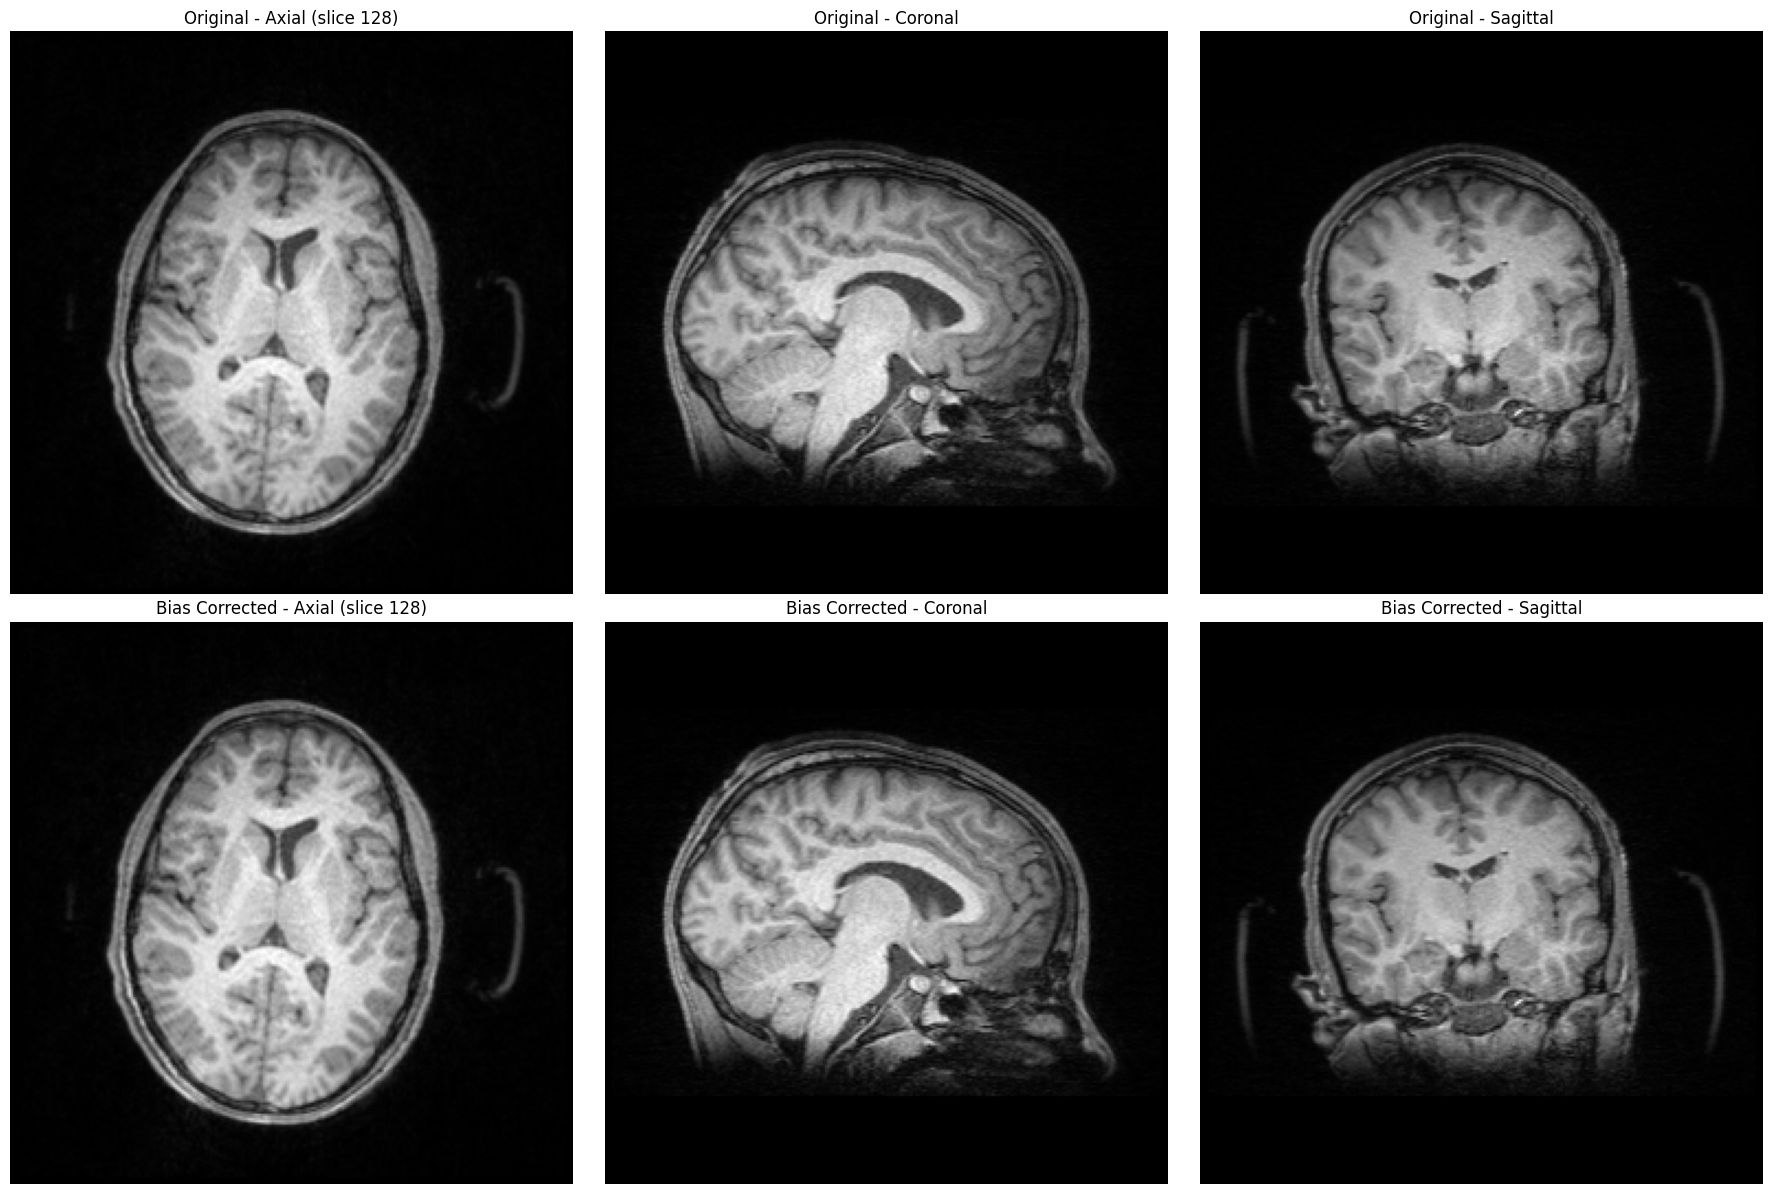

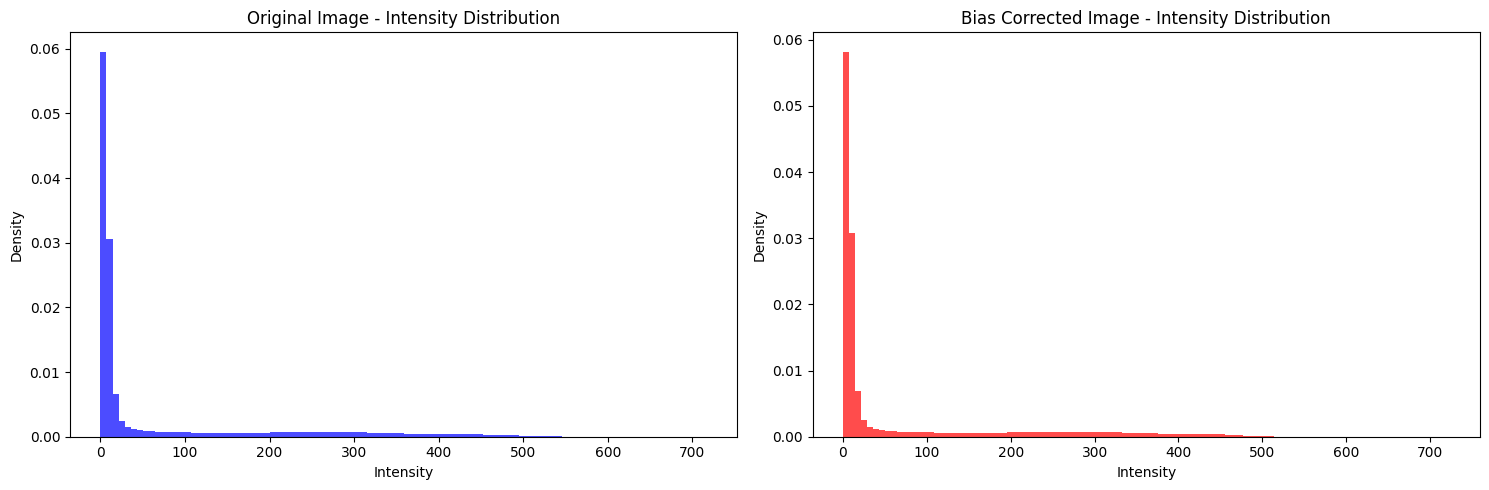

=== Bias Correction Quality Assessment ===
Coefficient of Variation (CV):
  Original: 1.7301
  Corrected: 1.7042
  Improvement: 1.50%

Signal-to-Noise Ratio (SNR):
  Original: 0.5780
  Corrected: 0.5868
  Improvement: 1.52%

Regional Uniformity (Central Region CV):
  Original: 0.1969
  Corrected: 0.1974
  Improvement: -0.21%

=== Overall Assessment ===
✓ Reduced coefficient of variation
✓ Improved signal-to-noise ratio
🎉 Bias correction appears SUCCESSFUL!


In [24]:
# Example usage for first corrected image
t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])

idx = 12

if t1_files:
    original_file = os.path.join(data_path, t1_files[idx])
    corrected_file = os.path.join(corrected_output_dir, t1_files[idx].replace('.nii', '_bias_corrected.nii'))
    
    if os.path.exists(corrected_file):
        print(f"Comparing: {t1_files[idx]}")
        visualize_bias_correction_comparison(original_file, corrected_file)
        evaluate_bias_correction_quality(original_file, corrected_file)
    else:
        print("Corrected file not found. Run bias correction first.")

### Skull Stripping using HD-BET

Define the function to perform skull stripping using HD-BET.

In [ ]:
def skull_strip_with_hdbet(input_path, output_path, use_gpu=True):
    """
    Perform skull stripping using HD-BET with proper device parameter.
    
    Parameters:
    input_path (str): Path to input NIfTI file
    output_path (str): Path to save skull-stripped image
    use_gpu (bool): Whether to use GPU acceleration
    
    Returns:
    bool: True if successful, False otherwise
    """
    try:
        # Determine device string - HD-BET expects "cuda" not "gpu"
        device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
        
        # Construct HD-BET command with correct device parameter
        cmd = [
            'hd-bet',
            '-i', input_path,
            '-o', output_path,
            '-device', device,  # Use "cuda" instead of "gpu"
            '--verbose',
            '--disable_tta'
        ]
        
        print(f"Running: {' '.join(cmd)}")
        
        # Execute HD-BET command
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            check=True
        )
        
        # Check if output file was created
        if os.path.exists(output_path):
            print(f"✓ Successfully skull-stripped: {os.path.basename(input_path)}")
            return True
        else:
            print(f"✗ Output file not created: {output_path}")
            return False
            
    except subprocess.CalledProcessError as e:
        print(f"✗ Error during skull stripping: {e}")
        print(f"Error output: {e.stderr}")
        return False
    except Exception as e:
        print(f"✗ Unexpected error: {e}")
        return False

In [ ]:
# Create output directory for skull-stripped images
skull_stripped_output_dir = os.path.join(data_path, "skull_stripped_T1_scans")
os.makedirs(skull_stripped_output_dir, exist_ok=True)

# Get all bias-corrected files
corrected_files = sorted([f for f in os.listdir(corrected_output_dir) if f.endswith('_bias_corrected.nii')])

print(f"Found {len(corrected_files)} bias-corrected T1 scans to process")

# Check GPU availability
gpu_available = torch.cuda.is_available()
print(f"GPU available: {gpu_available}")

# Process each bias-corrected scan
successful_count = 0
failed_count = 0

for corrected_file in tqdm(corrected_files, desc="Skull stripping T1 scans"):
    input_path = os.path.join(corrected_output_dir, corrected_file)
    
    # Create output filename (replace "bias_corrected" with "skull_stripped")
    base_name = corrected_file.replace('_bias_corrected.nii', '')
    output_filename = f"{base_name}_skull_stripped.nii.gz"  # HD-BET outputs .nii.gz
    output_path = os.path.join(skull_stripped_output_dir, output_filename)
    
    # Skip if skull-stripped file already exists
    if os.path.exists(output_path):
        print(f"⏭️ Skipping {corrected_file} - skull-stripped file already exists")
        continue
    
    print(f"Processing: {corrected_file}")
    
    # Perform skull stripping
    success = skull_strip_with_hdbet(input_path, output_path, use_gpu=gpu_available)
    
    if success:
        successful_count += 1
    else:
        failed_count += 1

print(f"\n=== Skull Stripping Summary ===")
print(f"✓ Successfully processed: {successful_count} scans")
print(f"✗ Failed: {failed_count} scans")
print(f"Skull-stripped images saved in: {skull_stripped_output_dir}")

Visualize the stripped MRI scans

In [ ]:
def visualize_skull_stripping_comparison(original_path, skull_stripped_path, slice_idx=None):
    """
    Compare original and skull-stripped images side by side
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    skull_stripped_img = nib.load(skull_stripped_path).get_fdata()
    
    # Use middle slice if not specified
    if slice_idx is None:
        slice_idx = original_img.shape[2] // 2
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original image - different views
    axes[0, 0].imshow(original_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, 0].set_title(f'Original - Axial (slice {slice_idx})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_img[original_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[0, 1].set_title('Original - Coronal')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(original_img[:, original_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[0, 2].set_title('Original - Sagittal')
    axes[0, 2].axis('off')
    
    # Skull-stripped image - different views
    axes[1, 0].imshow(skull_stripped_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, 0].set_title(f'Skull Stripped - Axial (slice {slice_idx})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(skull_stripped_img[skull_stripped_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[1, 1].set_title('Skull Stripped - Coronal')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(skull_stripped_img[:, skull_stripped_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[1, 2].set_title('Skull Stripped - Sagittal')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [ ]:
def evaluate_skull_stripping_quality(original_path, skull_stripped_path, mask_path=None):
    """
    Evaluate the quality of skull stripping
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    skull_stripped_img = nib.load(skull_stripped_path).get_fdata()
    
    # Load mask if available
    if mask_path and os.path.exists(mask_path):
        mask_img = nib.load(mask_path).get_fdata()
    else:
        # Create approximate mask from skull-stripped image
        mask_img = (skull_stripped_img > 0).astype(float)
        print("Note: Using approximate mask from skull-stripped image")
    
    # Calculate metrics
    total_voxels = np.prod(original_img.shape)
    brain_voxels = np.count_nonzero(mask_img)
    brain_percentage = (brain_voxels / total_voxels) * 100
    
    # Check for over-stripping (very low brain percentage)
    # Check for under-stripping (very high brain percentage)
    original_nonzero = np.count_nonzero(original_img > 0)
    preservation_ratio = brain_voxels / original_nonzero if original_nonzero > 0 else 0
    
    print("=== Skull Stripping Quality Assessment ===")
    print(f"Total image voxels: {total_voxels:,}")
    print(f"Brain voxels (after stripping): {brain_voxels:,}")
    print(f"Brain percentage: {brain_percentage:.2f}%")
    print(f"Brain preservation ratio: {preservation_ratio:.3f}")
    print()
    
    # Visual assessment guidelines
    print("=== Quality Guidelines ===")
    if 10 <= brain_percentage <= 25:
        print("✓ Brain percentage looks reasonable (10-25%)")
    elif brain_percentage < 10:
        print("⚠️ Brain percentage seems low - possible over-stripping")
    else:
        print("⚠️ Brain percentage seems high - possible under-stripping")
    
    if 0.4 <= preservation_ratio <= 0.8:
        print("✓ Brain preservation ratio looks good (40-80%)")
    elif preservation_ratio < 0.4:
        print("⚠️ Low preservation ratio - possible over-stripping")
    else:
        print("⚠️ High preservation ratio - possible under-stripping")
    
    return {
        'brain_percentage': brain_percentage,
        'preservation_ratio': preservation_ratio,
        'brain_voxels': brain_voxels,
        'total_voxels': total_voxels
    }



In [ ]:
def compare_multiple_skull_stripped_scans(num_scans=5):
    """
    Compare skull stripping results across multiple scans
    """
    # Get corresponding files
    t1_files = sorted([f for f in os.listdir(data_path) if f.endswith('_T1.nii')])[:15]
    corrected_files = sorted([f for f in os.listdir(corrected_output_dir) if f.endswith('_bias_corrected.nii')])
    skull_stripped_files = sorted([f for f in os.listdir(skull_stripped_output_dir) if f.endswith('_skull_stripped.nii.gz')])
    
    print(f"Comparing {min(num_scans, len(skull_stripped_files))} skull-stripped scans...")
    
    results = []
    
    for i in range(min(num_scans, len(skull_stripped_files))):
        # Get file paths
        t1_file = t1_files[i] if i < len(t1_files) else None
        skull_stripped_file = skull_stripped_files[i]
        
        # Construct paths
        if t1_file:
            original_path = os.path.join(data_path, t1_file)
        else:
            # Use bias-corrected as fallback
            corrected_file = corrected_files[i] if i < len(corrected_files) else None
            original_path = os.path.join(corrected_output_dir, corrected_file) if corrected_file else None
        
        skull_stripped_path = os.path.join(skull_stripped_output_dir, skull_stripped_file)
        
        # Check for corresponding mask file
        mask_file = skull_stripped_file.replace('_skull_stripped.nii.gz', '_mask.nii.gz')
        mask_path = os.path.join(skull_stripped_output_dir, mask_file)
        
        if original_path and os.path.exists(original_path):
            print(f"\n--- Scan {i+1}: {os.path.basename(skull_stripped_file)} ---")
            
            # Visualize
            visualize_skull_stripping_comparison(original_path, skull_stripped_path)
            
            # Evaluate
            metrics = evaluate_skull_stripping_quality(original_path, skull_stripped_path, mask_path)
            results.append({
                'scan': os.path.basename(skull_stripped_file),
                **metrics
            })
    
    # Summary statistics
    if results:
        print(f"\n=== Summary Statistics ({len(results)} scans) ===")
        brain_percentages = [r['brain_percentage'] for r in results]
        preservation_ratios = [r['preservation_ratio'] for r in results]
        
        print(f"Brain percentage - Mean: {np.mean(brain_percentages):.2f}%, Std: {np.std(brain_percentages):.2f}%")
        print(f"Preservation ratio - Mean: {np.mean(preservation_ratios):.3f}, Std: {np.std(preservation_ratios):.3f}")
        
        # Flag potential issues
        problematic_scans = [r['scan'] for r in results if r['brain_percentage'] < 10 or r['brain_percentage'] > 25]
        if problematic_scans:
            print(f"\n⚠️ Scans that may need review: {', '.join(problematic_scans)}")



In [ ]:
# Run the comparison
compare_multiple_skull_stripped_scans(num_scans=5)

### Resample voxel size

In [ ]:
def convert_nii_to_nii_gz(input_path, output_path):
    """
    Convert .nii file to .nii.gz (compressed) format
    
    Parameters:
    input_path (str): Path to input .nii file
    output_path (str): Path to save as .nii.gz file
    
    Returns:
    bool: True if successful, False otherwise
    """
    try:
        # Load the NIfTI image
        img = nib.load(input_path)
        
        # Save as compressed .nii.gz
        nib.save(img, output_path)
        
        print(f"✓ Converted {os.path.basename(input_path)} -> {os.path.basename(output_path)}")
        return True
        
    except Exception as e:
        print(f"✗ Error converting {input_path}: {e}")
        return False

In [ ]:
def resample_to_1mm_monai(input_dir, output_dir, target_spacing=(1.0, 1.0, 1.0), is_label=False, skull_stripped_dir=None):
    """
    Resample all NIfTI images to 1mm³ voxel spacing using MONAI.
    ALWAYS outputs .nii.gz format for consistency.
    
    Parameters:
    input_dir (str): Directory containing input NIfTI files
    output_dir (str): Directory to save resampled images
    target_spacing (tuple): Target voxel spacing in mm (x, y, z)
    is_label (bool): True for lesion masks (uses nearest neighbor), False for images (uses trilinear)
    skull_stripped_dir (str): Directory containing skull-stripped images (only needed for labels)
    
    Returns:
    int: Number of successfully processed files
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize MONAI transforms
    loader = LoadImage(image_only=False)  # Keep metadata
    
    # Get all NIfTI files in input directory
    input_files = sorted([f for f in os.listdir(input_dir) 
                         if f.endswith(('.nii', '.nii.gz'))])
    
    # If processing labels, filter to only those with corresponding skull-stripped images
    if is_label and skull_stripped_dir:
        # Get list of available skull-stripped scan IDs
        skull_stripped_files = [f for f in os.listdir(skull_stripped_dir) if f.endswith('_skull_stripped.nii.gz')]
        available_scan_ids = set()
        for f in skull_stripped_files:
            # Extract scan ID from filename like "scan_0001_T1_skull_stripped.nii.gz"
            scan_id = f.split('_T1_skull_stripped')[0]  # Gets "scan_0001"
            available_scan_ids.add(scan_id)
        
        # Filter lesion files to only those with corresponding skull-stripped images
        filtered_files = []
        for f in input_files:
            if f.endswith('_Lesion.nii'):
                scan_id = f.split('_Lesion.nii')[0]  # Gets "scan_0001" from "scan_0001_Lesion.nii"
                if scan_id in available_scan_ids:
                    filtered_files.append(f)
                else:
                    print(f"⏭️ Skipping {f} - no corresponding skull-stripped image")
        
        input_files = filtered_files
        print(f"Filtered to {len(input_files)} lesion files with corresponding skull-stripped images")
    
    print(f"Found {len(input_files)} files to resample")
    print(f"Target spacing: {target_spacing} mm")
    print(f"Mode: {'Label (nearest neighbor)' if is_label else 'Image (trilinear)'}")
    print("📝 Note: ALL outputs will be in .nii.gz format for consistency")
    
    successful_count = 0
    failed_count = 0
    
    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    for input_file in tqdm(input_files, desc="Resampling files"):
        input_path = os.path.join(input_dir, input_file)
        
        # Create output filename based on file type - ALWAYS .nii.gz
        if is_label:
            # For lesion masks - only process files that end with _Lesion.nii
            if not input_file.endswith('_Lesion.nii'):
                continue
            output_filename = input_file.replace('_Lesion.nii', '_Lesion_resampled_1mm.nii.gz')
        else:
            # For skull-stripped images
            if input_file.endswith('_skull_stripped.nii.gz'):
                output_filename = input_file.replace('_skull_stripped.nii.gz', '_resampled_1mm.nii.gz')
            else:
                continue  # Skip files that don't match expected pattern
        
        output_path = os.path.join(output_dir, output_filename)
        
        # Skip if output already exists
        if os.path.exists(output_path):
            print(f"⏭️ Skipping {input_file} - already exists")
            successful_count += 1
            continue
        
        try:
            print(f"Processing: {input_file}")
            
            # Load image with metadata
            image, meta_dict = loader(input_path)
            
            # Move to GPU if available
            if torch.cuda.is_available():
                image = image.to(device)
            
            # Get current spacing from metadata
            current_spacing = meta_dict['pixdim'][1:4]  # MONAI format
            print(f"  Original spacing: {current_spacing}")
            
            # Check if resampling is actually needed
            spacing_diff = np.abs(np.array(current_spacing) - np.array(target_spacing))
            if np.all(spacing_diff < 0.01):  # Already very close to target spacing
                print(f"  Spacing already close to target, converting to .nii.gz...")
                # Convert to .nii.gz format for consistency
                success = convert_nii_to_nii_gz(input_path, output_path)
                if success:
                    successful_count += 1
                else:
                    failed_count += 1
                continue
            
            # Create resampling transform with correct MONAI syntax
            if is_label:
                # For lesion masks: use nearest neighbor to preserve integer labels
                spacing_transform = Spacing(
                    pixdim=target_spacing,
                    mode='nearest',  # Preserve integer values for masks
                )
            else:
                # For images: use trilinear interpolation
                spacing_transform = Spacing(
                    pixdim=target_spacing,
                    mode='trilinear',  # Smooth interpolation for images
                )
            
            # Apply resampling
            resampled_image = spacing_transform(image, meta_dict)
            
            # For lesion masks, ensure integer values (0 or 1)
            if is_label:
                resampled_image = torch.round(resampled_image).to(torch.uint8)
            
            # Move back to CPU for saving
            if torch.cuda.is_available():
                resampled_image = resampled_image.cpu()
            
            # Save using nibabel
            # Convert back to nibabel format
            resampled_array = resampled_image.squeeze().numpy()  # Remove channel dimension and convert to numpy
            
            # Create new NIfTI image with updated metadata
            original_nii = nib.load(input_path)
            
            # Calculate new affine matrix for the new spacing
            original_affine = original_nii.affine.copy()
            original_spacing_nib = np.abs(original_affine.diagonal()[:3])  # Get original spacing from affine
            spacing_ratios = np.array(original_spacing_nib) / np.array(target_spacing)
            
            # Update affine matrix for new spacing
            new_affine = original_affine.copy()
            new_affine[0, 0] = original_affine[0, 0] / spacing_ratios[0]
            new_affine[1, 1] = original_affine[1, 1] / spacing_ratios[1]
            new_affine[2, 2] = original_affine[2, 2] / spacing_ratios[2]
            
            # Create new NIfTI image
            resampled_nii = nib.Nifti1Image(resampled_array, new_affine, original_nii.header)
            
            # Update header with new spacing
            resampled_nii.header['pixdim'][1:4] = target_spacing
            
            # Save the resampled image as .nii.gz
            nib.save(resampled_nii, output_path)
            
            print(f"✓ Completed: {output_filename}")
            successful_count += 1
            
        except Exception as e:
            print(f"✗ Error processing {input_file}: {str(e)}")
            failed_count += 1
            continue
    
    print(f"\n=== Resampling Summary ===")
    print(f"✓ Successfully processed: {successful_count} files")
    print(f"✗ Failed: {failed_count} files")
    print(f"Output directory: {output_dir}")
    print("📝 All outputs are in .nii.gz format")
    
    return successful_count

In [ ]:
# Updated resampling calls
# Resample skull-stripped T1 images (from skull_stripped_output_dir)
print("=== Resampling Skull-Stripped T1 Images ===")
resampled_t1_output_dir = os.path.join(data_path, "resampled_1mm_T1_scans")
t1_success = resample_to_1mm_monai(skull_stripped_output_dir, resampled_t1_output_dir, is_label=False)

# Resample lesion masks from original data directory (data_path) - only for scans with skull-stripped images
print("\n=== Resampling Lesion Masks (only for scans with skull-stripped images) ===")
resampled_lesion_output_dir = os.path.join(data_path, "resampled_1mm_Lesion_masks")
lesion_success = resample_to_1mm_monai(data_path, resampled_lesion_output_dir, is_label=True, skull_stripped_dir=skull_stripped_output_dir)

print(f"\n=== Overall Summary ===")
print(f"T1 images resampled: {t1_success}")
print(f"Lesion masks resampled: {lesion_success}")

### Z-Score Normalization

Define the function for normalization

In [ ]:
def z_score_normalize_images(input_dir, output_dir, mask_value=0):
    """
    Apply Z-score normalization to all NIfTI images in input directory.
    
    Parameters:
    input_dir (str): Directory containing input resampled NIfTI files
    output_dir (str): Directory to save normalized images
    mask_value (float): Value to use for background/masked regions (default: 0)
    
    Returns:
    int: Number of successfully processed files
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize MONAI transforms
    loader = LoadImage(image_only=False)  # Keep metadata
    # Remove the problematic SaveImage configuration
    # saver = SaveImage(output_dir=output_dir, output_postfix="", separate_folder=False, print_log=True)
    
    # Get all resampled NIfTI files
    input_files = sorted([f for f in os.listdir(input_dir) 
                         if f.endswith('_resampled_1mm.nii.gz')])
    
    print(f"Found {len(input_files)} resampled T1 images to normalize")
    print(f"Input directory: {input_dir}")
    print(f"Output directory: {output_dir}")
    
    successful_count = 0
    failed_count = 0
    
    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    for input_file in tqdm(input_files, desc="Normalizing images"):
        input_path = os.path.join(input_dir, input_file)
        
        # Create output filename
        output_filename = input_file.replace('_resampled_1mm.nii.gz', '_normalized.nii.gz')
        output_path = os.path.join(output_dir, output_filename)
        
        # Skip if output already exists
        if os.path.exists(output_path):
            print(f"⏭️ Skipping {input_file} - already exists")
            successful_count += 1
            continue
        
        try:
            print(f"Processing: {input_file}")
            
            # Load image with metadata
            image, meta_dict = loader(input_path)
            
            # Move to GPU if available
            if torch.cuda.is_available():
                image = image.to(device)
            
            # Convert to float32 for normalization
            image = image.float()
            
            # Create brain mask (non-zero voxels)
            brain_mask = image > 0
            
            # Calculate statistics only for brain voxels
            brain_voxels = image[brain_mask]
            
            if len(brain_voxels) == 0:
                print(f"⚠️ Warning: No brain voxels found in {input_file}")
                # Copy original file if no brain voxels
                import shutil
                shutil.copy2(input_path, output_path)
                successful_count += 1
                continue
            
            # Calculate mean and std for brain region only
            brain_mean = torch.mean(brain_voxels)
            brain_std = torch.std(brain_voxels)
            
            print(f"  Brain mean: {brain_mean:.4f}")
            print(f"  Brain std: {brain_std:.4f}")
            
            # Avoid division by zero
            if brain_std == 0:
                print(f"⚠️ Warning: Zero standard deviation in {input_file}")
                normalized_image = image - brain_mean
            else:
                # Apply Z-score normalization: (x - mean) / std
                normalized_image = torch.zeros_like(image)
                normalized_image[brain_mask] = (image[brain_mask] - brain_mean) / brain_std
                normalized_image[~brain_mask] = mask_value  # Set background to mask_value
            
            # Verify normalization
            normalized_brain_voxels = normalized_image[brain_mask]
            if len(normalized_brain_voxels) > 0:
                new_mean = torch.mean(normalized_brain_voxels)
                new_std = torch.std(normalized_brain_voxels)
                print(f"  Normalized mean: {new_mean:.6f}")
                print(f"  Normalized std: {new_std:.6f}")
            
            # Move back to CPU for saving
            if torch.cuda.is_available():
                normalized_image = normalized_image.cpu()
            
            # Save using nibabel instead of MONAI SaveImage
            # Convert back to nibabel format
            normalized_array = normalized_image.squeeze().numpy()  # Remove channel dimension and convert to numpy
            
            # Create new NIfTI image with original metadata
            original_nii = nib.load(input_path)
            normalized_nii = nib.Nifti1Image(normalized_array, original_nii.affine, original_nii.header)
            
            # Save the normalized image to the correct location
            nib.save(normalized_nii, output_path)
            
            print(f"✓ Completed: {output_filename}")
            successful_count += 1
            
        except Exception as e:
            print(f"✗ Error processing {input_file}: {str(e)}")
            failed_count += 1
            continue
    
    print(f"\n=== Z-Score Normalization Summary ===")
    print(f"✓ Successfully processed: {successful_count} files")
    print(f"✗ Failed: {failed_count} files")
    print(f"Output directory: {output_dir}")
    
    return successful_count

Apply z-score normalization

In [ ]:
# Apply Z-score normalization to resampled T1 images
print("=== Z-Score Normalizing Resampled T1 Images ===")
normalized_t1_output_dir = os.path.join(data_path, "normalized_T1_scans")
normalization_success = z_score_normalize_images(resampled_t1_output_dir, normalized_t1_output_dir)

print(f"\n=== Normalization Summary ===")
print(f"T1 images normalized: {normalization_success}")
print(f"Normalized images saved in: {normalized_t1_output_dir}")

Visualize and evaluate the applied normalization

In [ ]:
def visualize_normalization_comparison(original_path, normalized_path, slice_idx=None):
    """
    Compare original resampled and normalized images side by side
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    normalized_img = nib.load(normalized_path).get_fdata()
    
    # Use middle slice if not specified
    if slice_idx is None:
        slice_idx = original_img.shape[2] // 2
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original resampled image - different views
    axes[0, 0].imshow(original_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0, 0].set_title(f'Original Resampled - Axial (slice {slice_idx})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(original_img[original_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[0, 1].set_title('Original Resampled - Coronal')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(original_img[:, original_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[0, 2].set_title('Original Resampled - Sagittal')
    axes[0, 2].axis('off')
    
    # Normalized image - different views
    axes[1, 0].imshow(normalized_img[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[1, 0].set_title(f'Z-Score Normalized - Axial (slice {slice_idx})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(normalized_img[normalized_img.shape[0]//2, :, :].T, cmap='gray', origin='lower')
    axes[1, 1].set_title('Z-Score Normalized - Coronal')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(normalized_img[:, normalized_img.shape[1]//2, :].T, cmap='gray', origin='lower')
    axes[1, 2].set_title('Z-Score Normalized - Sagittal')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot intensity histograms for comparison
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Original histogram
    brain_mask_orig = original_img > 0
    original_brain_values = original_img[brain_mask_orig].flatten()
    axes[0].hist(original_brain_values, bins=100, alpha=0.7, color='blue', density=True)
    axes[0].set_title('Original Resampled - Intensity Distribution')
    axes[0].set_xlabel('Intensity')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    
    # Normalized histogram
    brain_mask_norm = normalized_img != 0  # Background is set to 0
    normalized_brain_values = normalized_img[brain_mask_norm].flatten()
    axes[1].hist(normalized_brain_values, bins=100, alpha=0.7, color='red', density=True)
    axes[1].set_title('Z-Score Normalized - Intensity Distribution')
    axes[1].set_xlabel('Z-Score')
    axes[1].set_ylabel('Density')
    axes[1].grid(True, alpha=0.3)
    
    # Side-by-side comparison
    axes[2].hist(original_brain_values, bins=50, alpha=0.5, color='blue', density=True, label='Original')
    axes[2].hist(normalized_brain_values, bins=50, alpha=0.5, color='red', density=True, label='Normalized')
    axes[2].set_title('Overlay Comparison')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [ ]:
def evaluate_normalization_quality(original_path, normalized_path):
    """
    Evaluate the quality of Z-score normalization using quantitative metrics
    """
    # Load images
    original_img = nib.load(original_path).get_fdata()
    normalized_img = nib.load(normalized_path).get_fdata()
    
    # Create brain masks (non-zero voxels) - USE SAME MASK FOR BOTH
    brain_mask_orig = original_img > 0
    brain_mask_norm = brain_mask_orig  # Use original mask for consistency
    
    # Get brain voxels
    original_brain = original_img[brain_mask_orig]
    normalized_brain = normalized_img[brain_mask_norm]
    
    print("=== Z-Score Normalization Quality Assessment ===")
    print(f"File: {os.path.basename(original_path)} -> {os.path.basename(normalized_path)}")
    print()
    
    # 1. Basic statistics
    print("=== Original Image Statistics ===")
    print(f"Mean: {np.mean(original_brain):.4f}")
    print(f"Std: {np.std(original_brain):.4f}")
    print(f"Min: {np.min(original_brain):.4f}")
    print(f"Max: {np.max(original_brain):.4f}")
    print(f"Range: {np.max(original_brain) - np.min(original_brain):.4f}")
    print()
    
    print("=== Normalized Image Statistics ===")
    print(f"Mean: {np.mean(normalized_brain):.6f}")
    print(f"Std: {np.std(normalized_brain):.6f}")
    print(f"Min: {np.min(normalized_brain):.4f}")
    print(f"Max: {np.max(normalized_brain):.4f}")
    print(f"Range: {np.max(normalized_brain) - np.min(normalized_brain):.4f}")
    print()
    
    # 2. Normalization quality checks
    print("=== Normalization Quality Checks ===")
    norm_mean = np.mean(normalized_brain)
    norm_std = np.std(normalized_brain)
    
    # Check if mean is close to 0
    if abs(norm_mean) < 0.001:
        print("✓ Mean is very close to 0 (< 0.001)")
    elif abs(norm_mean) < 0.01:
        print("✓ Mean is close to 0 (< 0.01)")
    else:
        print(f"⚠️ Mean is not close to 0: {norm_mean:.6f}")
    
    # Check if std is close to 1
    if abs(norm_std - 1.0) < 0.001:
        print("✓ Standard deviation is very close to 1 (< 0.001)")
    elif abs(norm_std - 1.0) < 0.01:
        print("✓ Standard deviation is close to 1 (< 0.01)")
    else:
        print(f"⚠️ Standard deviation is not close to 1: {norm_std:.6f}")
    
    # 3. Check preservation of brain structure (use original mask for both)
    brain_voxels_orig = np.count_nonzero(brain_mask_orig)
    brain_voxels_norm = np.count_nonzero(brain_mask_norm)
    
    print(f"Brain voxels - Original: {brain_voxels_orig:,}, Normalized: {brain_voxels_norm:,}")
    
    if brain_voxels_orig == brain_voxels_norm:
        print("✓ Brain structure preserved (same number of non-zero voxels)")
    else:
        print(f"⚠️ Brain structure changed: difference of {abs(brain_voxels_orig - brain_voxels_norm):,} voxels")
    
    # 4. Background preservation
    background_orig = np.count_nonzero(original_img == 0)
    background_norm = np.count_nonzero(normalized_img == 0)
    
    if background_orig == background_norm:
        print("✓ Background preserved (same number of zero voxels)")
    else:
        print(f"⚠️ Background changed: difference of {abs(background_orig - background_norm):,} voxels")
    
    print()
    
    # 5. Overall assessment
    print("=== Overall Assessment ===")
    quality_score = 0
    
    if abs(norm_mean) < 0.01:
        quality_score += 1
    if abs(norm_std - 1.0) < 0.01:
        quality_score += 1
    if brain_voxels_orig == brain_voxels_norm:
        quality_score += 1
    if background_orig == background_norm:
        quality_score += 1
    
    if quality_score == 4:
        print("🎉 Normalization is EXCELLENT!")
    elif quality_score == 3:
        print("✅ Normalization is GOOD")
    elif quality_score == 2:
        print("⚠️ Normalization is ACCEPTABLE")
    else:
        print("❌ Normalization may have ISSUES")
    
    return {
        'original_mean': np.mean(original_brain),
        'original_std': np.std(original_brain),
        'normalized_mean': norm_mean,
        'normalized_std': norm_std,
        'brain_voxels_preserved': brain_voxels_orig == brain_voxels_norm,
        'background_preserved': background_orig == background_norm,
        'quality_score': quality_score
    }

In [ ]:
def compare_multiple_normalized_scans(num_scans=3):
    """
    Compare normalization results across multiple scans
    """
    # Get corresponding files
    resampled_files = sorted([f for f in os.listdir(resampled_t1_output_dir) if f.endswith('_resampled_1mm.nii.gz')])
    normalized_files = sorted([f for f in os.listdir(normalized_t1_output_dir) if f.endswith('_normalized.nii.gz')])
    
    print(f"Comparing {min(num_scans, len(normalized_files))} normalized scans...")
    
    results = []
    
    for i in range(min(num_scans, len(normalized_files))):
        resampled_file = resampled_files[i] if i < len(resampled_files) else None
        normalized_file = normalized_files[i]
        
        if resampled_file:
            resampled_path = os.path.join(resampled_t1_output_dir, resampled_file)
            normalized_path = os.path.join(normalized_t1_output_dir, normalized_file)
            
            print(f"\n{'='*50}")
            print(f"--- Scan {i+1}: {normalized_file} ---")
            print(f"{'='*50}")
            
            # Visualize
            visualize_normalization_comparison(resampled_path, normalized_path)
            
            # Evaluate
            metrics = evaluate_normalization_quality(resampled_path, normalized_path)
            metrics['scan'] = normalized_file
            results.append(metrics)
    
    # Summary statistics
    if results:
        print(f"\n{'='*60}")
        print(f"=== SUMMARY STATISTICS ({len(results)} scans) ===")
        print(f"{'='*60}")
        
        # Calculate summary stats
        norm_means = [r['normalized_mean'] for r in results]
        norm_stds = [r['normalized_std'] for r in results]
        quality_scores = [r['quality_score'] for r in results]
        
        print(f"Normalized means - Average: {np.mean(norm_means):.6f}, Std: {np.std(norm_means):.6f}")
        print(f"Normalized stds - Average: {np.mean(norm_stds):.6f}, Std: {np.std(norm_stds):.6f}")
        print(f"Quality scores - Average: {np.mean(quality_scores):.2f}/4.0")
        
        # Count preservation issues
        brain_preserved = sum([r['brain_voxels_preserved'] for r in results])
        background_preserved = sum([r['background_preserved'] for r in results])
        
        print(f"Brain structure preserved: {brain_preserved}/{len(results)} scans")
        print(f"Background preserved: {background_preserved}/{len(results)} scans")
        
        # Flag problematic scans
        problematic_scans = [r['scan'] for r in results if r['quality_score'] < 3]
        if problematic_scans:
            print(f"\n⚠️ Scans that may need review: {', '.join(problematic_scans)}")
        else:
            print(f"\n✅ All scans passed quality checks!")



In [ ]:
# Run the normalization evaluation
print("=== Evaluating Z-Score Normalization Results ===")
compare_multiple_normalized_scans(num_scans=5)

### Compare between Original and Processed Images

In [ ]:
# Define file paths
scan_id = 'scan_0001'
start_slice = 110
num_slices = 5

# Original files
original_t1_file = os.path.join(data_path, f'{scan_id}_T1.nii')
original_lesion_file = os.path.join(data_path, f'{scan_id}_Lesion.nii')

# Processed files
processed_t1_file = os.path.join(normalized_t1_output_dir, f'{scan_id}_T1_normalized.nii.gz')
processed_lesion_file = os.path.join(resampled_lesion_output_dir, f'{scan_id}_Lesion_resampled_1mm.nii.gz')

# Check if files exist
files_to_check = [
    (original_t1_file, "Original T1"),
    (original_lesion_file, "Original Lesion"),
    (processed_t1_file, "Processed T1"),
    (processed_lesion_file, "Processed Lesion")
]

missing_files = []
for file_path, file_desc in files_to_check:
    if not os.path.exists(file_path):
        missing_files.append(f"{file_desc}: {file_path}")

if missing_files:
    print("❌ Missing files:")
    for missing in missing_files:
        print(f"   {missing}")
else:
    print("✅ All files found, loading images...")
    
    # Load images
    original_t1_img = nib.load(original_t1_file).get_fdata()
    original_lesion_img = nib.load(original_lesion_file).get_fdata()
    processed_t1_img = nib.load(processed_t1_file).get_fdata()
    processed_lesion_img = nib.load(processed_lesion_file).get_fdata()
    
    print(f"Original T1 shape: {original_t1_img.shape}")
    print(f"Original Lesion shape: {original_lesion_img.shape}")
    print(f"Processed T1 shape: {processed_t1_img.shape}")
    print(f"Processed Lesion shape: {processed_lesion_img.shape}")
    
    # Create side-by-side comparison plot
    fig, axes = plt.subplots(4, num_slices, figsize=(num_slices * 3, 16))
    
    # Ensure axes is 2D even for single slice
    if num_slices == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_slices):
        slice_idx = start_slice + i
        
        # Check if slice index is valid for both images
        max_slice_orig = min(original_t1_img.shape[2], original_lesion_img.shape[2])
        max_slice_proc = min(processed_t1_img.shape[2], processed_lesion_img.shape[2])
        
        if slice_idx >= max_slice_orig or slice_idx >= max_slice_proc:
            print(f"⚠️ Slice {slice_idx} is out of bounds, skipping...")
            continue
        
        # Original images
        orig_t1_slice = original_t1_img[:, :, slice_idx].T
        orig_lesion_slice = original_lesion_img[:, :, slice_idx].T
        
        # Processed images
        proc_t1_slice = processed_t1_img[:, :, slice_idx].T
        proc_lesion_slice = processed_lesion_img[:, :, slice_idx].T
        
        # Row 1: Original T1
        axes[0, i].imshow(orig_t1_slice, cmap='gray', origin='lower')
        axes[0, i].set_title(f'Original T1\nSlice {slice_idx}', fontsize=10)
        axes[0, i].axis('off')
        
        # Row 2: Original T1 + Lesion overlay
        axes[1, i].imshow(orig_t1_slice, cmap='gray', origin='lower')
        axes[1, i].imshow(orig_lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
        axes[1, i].set_title(f'Original T1 + Lesion\nSlice {slice_idx}', fontsize=10)
        axes[1, i].axis('off')
        
        # Row 3: Processed T1 (normalized)
        axes[2, i].imshow(proc_t1_slice, cmap='gray', origin='lower')
        axes[2, i].set_title(f'Processed T1\n(Normalized) Slice {slice_idx}', fontsize=10)
        axes[2, i].axis('off')
        
        # Row 4: Processed T1 + Lesion overlay
        axes[3, i].imshow(proc_t1_slice, cmap='gray', origin='lower')
        axes[3, i].imshow(proc_lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
        axes[3, i].set_title(f'Processed T1 + Lesion\n(Resampled) Slice {slice_idx}', fontsize=10)
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Original vs Processed Images Comparison - {scan_id}', fontsize=16, y=0.98)
    plt.show()
    
    # Print intensity statistics comparison
    print(f"\n=== Intensity Statistics Comparison for {scan_id} ===")
    
    # Original T1 stats
    orig_brain_mask = original_t1_img > 0
    orig_brain_values = original_t1_img[orig_brain_mask]
    
    # Processed T1 stats
    proc_brain_mask = processed_t1_img != 0  # Background is 0 after normalization
    proc_brain_values = processed_t1_img[proc_brain_mask]
    
    print("Original T1 Image:")
    print(f"  Mean: {np.mean(orig_brain_values):.4f}")
    print(f"  Std: {np.std(orig_brain_values):.4f}")
    print(f"  Min: {np.min(orig_brain_values):.4f}")
    print(f"  Max: {np.max(orig_brain_values):.4f}")
    
    print("\nProcessed T1 Image (Z-Score Normalized):")
    print(f"  Mean: {np.mean(proc_brain_values):.6f}")
    print(f"  Std: {np.std(proc_brain_values):.6f}")
    print(f"  Min: {np.min(proc_brain_values):.4f}")
    print(f"  Max: {np.max(proc_brain_values):.4f}")
    
    # Lesion statistics
    orig_lesion_voxels = np.count_nonzero(original_lesion_img)
    proc_lesion_voxels = np.count_nonzero(processed_lesion_img)
    
    print(f"\nLesion Statistics:")
    print(f"  Original lesion voxels: {orig_lesion_voxels:,}")
    print(f"  Processed lesion voxels: {proc_lesion_voxels:,}")
    print(f"  Difference: {abs(orig_lesion_voxels - proc_lesion_voxels):,} voxels")
    
    if orig_lesion_voxels > 0:
        preservation_ratio = proc_lesion_voxels / orig_lesion_voxels
        print(f"  Lesion preservation ratio: {preservation_ratio:.3f}")

### Save as .pt

In [ ]:
# Define final data directory
final_data_dir = os.path.join(data_path, "final_processed_data")
os.makedirs(final_data_dir, exist_ok=True)

In [ ]:
def create_loading_helper_script(base_dir):
    """
    Create a helper script for loading individual .pt files
    """
    helper_script = f'''#!/usr/bin/env python3
"""
TBI Lesion Segmentation Dataset Loader
=====================================

Helper script for loading individual PyTorch tensor files.
Generated automatically on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

Usage Examples:
--------------
# Load a single scan
image, mask, metadata = load_single_scan("scan_0001")

# Load multiple scans  
images, masks, scan_ids = load_multiple_scans(["scan_0001", "scan_0002"])

# Load all scans
dataset = load_all_scans()

# Create PyTorch DataLoader
dataloader = create_dataloader(batch_size=4, shuffle=True)
"""

import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional, Union

# Base directory paths
BASE_DIR = r"{base_dir}"
IMAGES_DIR = os.path.join(BASE_DIR, "images")
MASKS_DIR = os.path.join(BASE_DIR, "masks") 
METADATA_DIR = os.path.join(BASE_DIR, "metadata")
SUMMARY_FILE = os.path.join(BASE_DIR, "dataset_summary.json")

def load_dataset_summary() -> Dict:
    """Load the dataset summary information."""
    with open(SUMMARY_FILE, 'r') as f:
        return json.load(f)

def get_available_scan_ids() -> List[str]:
    """Get list of all available scan IDs."""
    summary = load_dataset_summary()
    return summary['scan_ids']

def load_single_scan(scan_id: str) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
    """
    Load a single scan's image, mask, and metadata.
    
    Args:
        scan_id: Scan identifier (e.g., "scan_0001")
        
    Returns:
        Tuple of (image_tensor, mask_tensor, metadata_dict)
    """
    # Load image
    image_path = os.path.join(IMAGES_DIR, f"{{scan_id}}_image.pt")
    image_data = torch.load(image_path, map_location='cpu')
    image_tensor = image_data['image']
    
    # Load mask
    mask_path = os.path.join(MASKS_DIR, f"{{scan_id}}_mask.pt")
    mask_data = torch.load(mask_path, map_location='cpu')
    mask_tensor = mask_data['mask']
    
    # Load metadata
    metadata_path = os.path.join(METADATA_DIR, f"{{scan_id}}_metadata.json")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    return image_tensor, mask_tensor, metadata

def load_multiple_scans(scan_ids: List[str], stack: bool = True) -> Union[Tuple[torch.Tensor, torch.Tensor, List[str]], Tuple[List[torch.Tensor], List[torch.Tensor], List[str]]]:
    """
    Load multiple scans.
    
    Args:
        scan_ids: List of scan identifiers
        stack: If True, stack tensors into batches. If False, return lists.
        
    Returns:
        If stack=True: Tuple of (stacked_images, stacked_masks, scan_ids)
        If stack=False: Tuple of (image_list, mask_list, scan_ids)
    """
    images = []
    masks = []
    loaded_ids = []
    
    for scan_id in scan_ids:
        try:
            image, mask, _ = load_single_scan(scan_id)
            images.append(image)
            masks.append(mask)
            loaded_ids.append(scan_id)
        except Exception as e:
            print(f"Warning: Failed to load {{scan_id}}: {{e}}")
    
    if stack and images:
        images = torch.stack(images)
        masks = torch.stack(masks)
    
    return images, masks, loaded_ids

def load_all_scans(stack: bool = True) -> Union[Tuple[torch.Tensor, torch.Tensor, List[str]], Tuple[List[torch.Tensor], List[torch.Tensor], List[str]]]:
    """Load all available scans."""
    scan_ids = get_available_scan_ids()
    return load_multiple_scans(scan_ids, stack=stack)

def filter_scans_with_lesions() -> List[str]:
    """Get scan IDs that have lesions."""
    summary = load_dataset_summary()
    return [scan_id for scan_id, has_lesion in zip(summary['scan_ids'], summary['has_lesion']) if has_lesion]

def filter_scans_without_lesions() -> List[str]:
    """Get scan IDs that don't have lesions."""
    summary = load_dataset_summary()
    return [scan_id for scan_id, has_lesion in zip(summary['scan_ids'], summary['has_lesion']) if not has_lesion]

class TBILesionDataset(Dataset):
    """
    PyTorch Dataset class for TBI lesion segmentation data.
    """
    
    def __init__(self, scan_ids: Optional[List[str]] = None, transform=None):
        """
        Args:
            scan_ids: List of scan IDs to include. If None, uses all scans.
            transform: Optional transform to be applied on a sample.
        """
        self.scan_ids = scan_ids if scan_ids is not None else get_available_scan_ids()
        self.transform = transform
        
    def __len__(self):
        return len(self.scan_ids)
    
    def __getitem__(self, idx):
        scan_id = self.scan_ids[idx]
        image, mask, metadata = load_single_scan(scan_id)
        
        sample = {{
            'image': image,
            'mask': mask,
            'scan_id': scan_id,
            'metadata': metadata
        }}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

def create_dataloader(scan_ids: Optional[List[str]] = None, 
                     batch_size: int = 1,
                     shuffle: bool = True,
                     num_workers: int = 0,
                     transform=None) -> DataLoader:
    """
    Create a PyTorch DataLoader for the dataset.
    
    Args:
        scan_ids: List of scan IDs to include. If None, uses all scans.
        batch_size: Batch size for DataLoader
        shuffle: Whether to shuffle the data
        num_workers: Number of worker processes for data loading
        transform: Optional transform to be applied on samples
        
    Returns:
        PyTorch DataLoader
    """
    dataset = TBILesionDataset(scan_ids=scan_ids, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

def print_dataset_info():
    """Print comprehensive dataset information."""
    summary = load_dataset_summary()
    
    print("TBI Lesion Segmentation Dataset Information")
    print("=" * 50)
    print(f"Total scans: {{summary['total_scans']}}")
    print(f"Scans with lesions: {{summary['scans_with_lesions']}}")
    print(f"Scans without lesions: {{summary['scans_without_lesions']}}")
    print(f"Total size: {{summary['total_size_mb']:.2f}} MB")
    print(f"Average size per scan: {{summary['average_size_mb']:.2f}} MB")
    print(f"Creation date: {{summary['creation_date']}}")
    
    print("\\nPreprocessing steps:")
    for step in summary.get('preprocessing_info', {{}}).items():
        print(f"  • {{step[0]}}: {{step[1]}}")

# Example usage
if __name__ == "__main__":
    # Print dataset info
    print_dataset_info()
    
    # Example 1: Load a single scan
    print("\\n" + "="*50)
    print("Example 1: Loading single scan")
    scan_ids = get_available_scan_ids()
    if scan_ids:
        image, mask, metadata = load_single_scan(scan_ids[0])
        print(f"Loaded {{scan_ids[0]}}:")
        print(f"  Image shape: {{image.shape}}")
        print(f"  Mask shape: {{mask.shape}}")
        print(f"  Has lesion: {{metadata['statistics']['has_lesion']}}")
        print(f"  Lesion voxels: {{metadata['statistics']['lesion_voxels']}}")
    
    # Example 2: Create DataLoader
    print("\\n" + "="*50)
    print("Example 2: Creating DataLoader")
    dataloader = create_dataloader(batch_size=2, shuffle=True)
    
    print(f"DataLoader created with {{len(dataloader)}} batches")
    
    # Show first batch
    for batch_idx, batch in enumerate(dataloader):
        print(f"Batch {{batch_idx}}:")
        print(f"  Images shape: {{batch['image'].shape}}")
        print(f"  Masks shape: {{batch['mask'].shape}}")
        print(f"  Scan IDs: {{batch['scan_id']}}")
        break  # Just show first batch
    
    # Example 3: Filter scans with lesions
    print("\\n" + "="*50)
    print("Example 3: Loading only scans with lesions")
    lesion_scan_ids = filter_scans_with_lesions()
    print(f"Found {{len(lesion_scan_ids)}} scans with lesions")
    
    if lesion_scan_ids:
        lesion_dataloader = create_dataloader(scan_ids=lesion_scan_ids, batch_size=1)
        print(f"Created DataLoader with {{len(lesion_dataloader)}} lesion scans")
'''
    
    script_path = os.path.join(base_dir, "data_loader.py")
    with open(script_path, 'w') as f:
        f.write(helper_script)
    
    print(f"📄 Helper script created: {script_path}")
    return script_path

In [ ]:
def save_as_individual_pytorch_tensors():
    """
    Save each preprocessed scan as individual PyTorch tensor files
    Creates separate folders for images and masks with corresponding .pt files
    """
    # Create output directories
    pytorch_base_dir = os.path.join(final_data_dir, "pytorch_individual")
    images_dir = os.path.join(pytorch_base_dir, "images")
    masks_dir = os.path.join(pytorch_base_dir, "masks")
    metadata_dir = os.path.join(pytorch_base_dir, "metadata")
    
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)
    os.makedirs(metadata_dir, exist_ok=True)
    
    # Get all processed files
    normalized_files = sorted([f for f in os.listdir(normalized_t1_output_dir) 
                              if f.endswith('_normalized.nii.gz')])
    lesion_files = sorted([f for f in os.listdir(resampled_lesion_output_dir) 
                          if f.endswith('_resampled_1mm.nii.gz')])
    
    print(f"Found {len(normalized_files)} normalized T1 images (.nii.gz)")
    print(f"Found {len(lesion_files)} resampled lesion masks (.nii.gz)")
    
    successful_saves = 0
    failed_saves = 0
    dataset_summary = {
        'scan_ids': [],
        'image_shapes': [],
        'mask_shapes': [],
        'lesion_counts': [],
        'has_lesion': [],
        'file_sizes_mb': []
    }
    
    # Process each T1 image
    for t1_file in tqdm(normalized_files, desc="Creating individual .pt files"):
        try:
            # Extract scan ID
            scan_id = t1_file.split('_T1_normalized')[0]
            
            # Load T1 image
            t1_path = os.path.join(normalized_t1_output_dir, t1_file)
            t1_img = nib.load(t1_path).get_fdata().astype(np.float32)
            
            # Convert to PyTorch tensor and add channel dimension [1, H, W, D]
            t1_tensor = torch.from_numpy(t1_img).unsqueeze(0)
            
            # Find corresponding lesion mask
            lesion_file = f"{scan_id}_Lesion_resampled_1mm.nii.gz"
            lesion_path = os.path.join(resampled_lesion_output_dir, lesion_file)
            
            if os.path.exists(lesion_path):
                # Load lesion mask
                lesion_img = nib.load(lesion_path).get_fdata().astype(np.uint8)
                has_lesion = True
                print(f"✓ Found lesion mask for {scan_id}")
            else:
                # Create empty mask if lesion file doesn't exist
                lesion_img = np.zeros_like(t1_img, dtype=np.uint8)
                has_lesion = False
                print(f"⚠️ No lesion mask found for {scan_id}, creating empty mask")
            
            # Convert to PyTorch tensor and add channel dimension [1, H, W, D]
            lesion_tensor = torch.from_numpy(lesion_img).unsqueeze(0)
            
            # Create individual metadata for this scan
            scan_metadata = {
                'scan_id': scan_id,
                'preprocessing_steps': [
                    'bias_field_correction',
                    'skull_stripping', 
                    'resampling_to_1mm_isotropic',
                    'z_score_normalization'
                ],
                'target_spacing': [1.0, 1.0, 1.0],
                'normalization_method': 'z_score',
                'original_files': {
                    't1_file': t1_file,
                    'lesion_file': lesion_file if has_lesion else None
                },
                'tensor_shapes': {
                    'image': list(t1_tensor.shape),
                    'mask': list(lesion_tensor.shape)
                },
                'tensor_dtypes': {
                    'image': str(t1_tensor.dtype),
                    'mask': str(lesion_tensor.dtype)
                },
                'statistics': {
                    'has_lesion': has_lesion,
                    'lesion_voxels': int(torch.sum(lesion_tensor).item()),
                    'brain_voxels': int(torch.sum(t1_tensor != 0).item()),
                    'image_range': [float(t1_tensor.min()), float(t1_tensor.max())],
                    'brain_mean': float(torch.mean(t1_tensor[t1_tensor != 0])) if torch.sum(t1_tensor != 0) > 0 else 0.0,
                    'brain_std': float(torch.std(t1_tensor[t1_tensor != 0])) if torch.sum(t1_tensor != 0) > 0 else 0.0
                },
                'creation_date': str(pd.Timestamp.now()),
                'file_format': 'pytorch_tensor'
            }
            
            # Save individual files
            image_filename = f"{scan_id}_image.pt"
            mask_filename = f"{scan_id}_mask.pt"
            metadata_filename = f"{scan_id}_metadata.json"
            
            image_path = os.path.join(images_dir, image_filename)
            mask_path = os.path.join(masks_dir, mask_filename)
            metadata_path = os.path.join(metadata_dir, metadata_filename)
            
            # Save image tensor
            torch.save({
                'image': t1_tensor,
                'scan_id': scan_id,
                'shape': list(t1_tensor.shape),
                'dtype': str(t1_tensor.dtype)
            }, image_path)
            
            # Save mask tensor
            torch.save({
                'mask': lesion_tensor,
                'scan_id': scan_id,
                'shape': list(lesion_tensor.shape),
                'dtype': str(lesion_tensor.dtype),
                'has_lesion': has_lesion,
                'lesion_voxels': int(torch.sum(lesion_tensor).item())
            }, mask_path)
            
            # Save metadata as JSON
            with open(metadata_path, 'w') as f:
                json.dump(scan_metadata, f, indent=2)
            
            # Calculate file sizes
            image_size_mb = os.path.getsize(image_path) / (1024 * 1024)
            mask_size_mb = os.path.getsize(mask_path) / (1024 * 1024)
            total_size_mb = image_size_mb + mask_size_mb
            
            # Update summary
            dataset_summary['scan_ids'].append(scan_id)
            dataset_summary['image_shapes'].append(list(t1_tensor.shape))
            dataset_summary['mask_shapes'].append(list(lesion_tensor.shape))
            dataset_summary['lesion_counts'].append(int(torch.sum(lesion_tensor).item()))
            dataset_summary['has_lesion'].append(has_lesion)
            dataset_summary['file_sizes_mb'].append(total_size_mb)
            
            print(f"✓ Saved {scan_id}: Image {t1_tensor.shape}, Mask {lesion_tensor.shape}, Size: {total_size_mb:.2f}MB")
            successful_saves += 1
            
        except Exception as e:
            print(f"✗ Error processing {t1_file}: {str(e)}")
            failed_saves += 1
            continue
    
    # Save overall dataset summary
    dataset_summary['total_scans'] = len(dataset_summary['scan_ids'])
    dataset_summary['scans_with_lesions'] = sum(dataset_summary['has_lesion'])
    dataset_summary['scans_without_lesions'] = dataset_summary['total_scans'] - dataset_summary['scans_with_lesions']
    dataset_summary['total_size_mb'] = sum(dataset_summary['file_sizes_mb'])
    dataset_summary['average_size_mb'] = np.mean(dataset_summary['file_sizes_mb']) if dataset_summary['file_sizes_mb'] else 0
    dataset_summary['creation_date'] = str(pd.Timestamp.now())
    dataset_summary['preprocessing_info'] = {
        'bias_field_correction': 'N4ITK algorithm',
        'skull_stripping': 'HD-BET',
        'resampling': '1mm isotropic voxels using MONAI',
        'normalization': 'Z-score normalization (brain voxels only)'
    }
    
    summary_path = os.path.join(pytorch_base_dir, "dataset_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(dataset_summary, f, indent=2)
    
    # Create loading helper script
    create_loading_helper_script(pytorch_base_dir)
    
    # Print comprehensive summary
    print(f"\n{'='*80}")
    print("🎉 INDIVIDUAL PYTORCH FILES CREATED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"📁 Base directory: {pytorch_base_dir}")
    print(f"📊 Processing summary:")
    print(f"   ✓ Successfully saved: {successful_saves} scans")
    print(f"   ✗ Failed: {failed_saves} scans")
    print(f"   📈 Total size: {dataset_summary['total_size_mb']:.2f} MB")
    print(f"   📈 Average size per scan: {dataset_summary['average_size_mb']:.2f} MB")
    print(f"   🧠 Scans with lesions: {dataset_summary['scans_with_lesions']}")
    print(f"   🔳 Scans without lesions: {dataset_summary['scans_without_lesions']}")
    print(f"\n📂 Directory structure:")
    print(f"   📁 {os.path.basename(images_dir)}/     - Individual image tensors ({successful_saves} files)")
    print(f"   📁 {os.path.basename(masks_dir)}/      - Individual mask tensors ({successful_saves} files)")  
    print(f"   📁 {os.path.basename(metadata_dir)}/   - Individual metadata files ({successful_saves} files)")
    print(f"   📄 dataset_summary.json - Overall dataset information")
    print(f"   📄 data_loader.py       - Helper script for loading data")
    
    return pytorch_base_dir, dataset_summary

In [ ]:
print("🚀 Starting individual PyTorch file creation...")
pytorch_dir, summary = save_as_individual_pytorch_tensors()

In [ ]:
def verify_individual_files(base_dir: str, num_samples: int = 3):
    """
    Verify a few individual .pt files
    """
    print(f"\n{'='*60}")
    print("🔍 VERIFYING INDIVIDUAL FILES")
    print(f"{'='*60}")
    
    images_dir = os.path.join(base_dir, "images")
    masks_dir = os.path.join(base_dir, "masks")
    metadata_dir = os.path.join(base_dir, "metadata")
    
    # Get available files
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('_image.pt')])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('_mask.pt')])
    metadata_files = sorted([f for f in os.listdir(metadata_dir) if f.endswith('_metadata.json')])
    
    print(f"Found files:")
    print(f"  📁 Images: {len(image_files)} files")
    print(f"  📁 Masks: {len(mask_files)} files")  
    print(f"  📁 Metadata: {len(metadata_files)} files")
    
    # Verify consistency
    if len(image_files) == len(mask_files) == len(metadata_files):
        print("✅ File counts are consistent")
    else:
        print("⚠️ File counts are inconsistent!")
    
    # Test loading a few samples
    print(f"\\n🔍 Testing {min(num_samples, len(image_files))} samples:")
    
    for i in range(min(num_samples, len(image_files))):
        try:
            # Extract scan ID
            scan_id = image_files[i].replace('_image.pt', '')
            
            # Load files
            image_data = torch.load(os.path.join(images_dir, image_files[i]), map_location='cpu')
            mask_data = torch.load(os.path.join(masks_dir, f"{scan_id}_mask.pt"), map_location='cpu')
            
            with open(os.path.join(metadata_dir, f"{scan_id}_metadata.json"), 'r') as f:
                metadata = json.load(f)
            
            image = image_data['image']
            mask = mask_data['mask']
            
            print(f"  ✅ {scan_id}:")
            print(f"     📊 Image: {image.shape} ({image.dtype})")
            print(f"     📊 Mask: {mask.shape} ({mask.dtype})")
            print(f"     📊 Lesion voxels: {torch.sum(mask).item()}")
            print(f"     📊 Has lesion: {metadata['statistics']['has_lesion']}")
            
        except Exception as e:
            print(f"  ❌ Error loading {image_files[i]}: {e}")
    
    print(f"\\n✅ Verification completed!")

# Verify the created files
verify_individual_files(pytorch_dir, num_samples=5)

print(f"\\n🎊 COMPLETE! Individual PyTorch files are ready!")
print(f"📁 Dataset location: {pytorch_dir}")
print(f"💡 Use data_loader.py for easy loading and examples")

Load the exported .pt file and visualize

In [ ]:
# Set the path to your pytorch_individual directory
pytorch_base_dir = os.path.join(final_data_dir, "pytorch_individual")
images_dir = os.path.join(pytorch_base_dir, "images")
masks_dir = os.path.join(pytorch_base_dir, "masks")
metadata_dir = os.path.join(pytorch_base_dir, "metadata")

# Define scan parameters
scan_id = 'scan_0001'
start_slice = 110
num_slices = 5

# Load the .pt files
image_path = os.path.join(images_dir, f"{scan_id}_image.pt")
mask_path = os.path.join(masks_dir, f"{scan_id}_mask.pt")
metadata_path = os.path.join(metadata_dir, f"{scan_id}_metadata.json")

# Load image tensor
image_data = torch.load(image_path, map_location='cpu')
image_tensor = image_data['image']  # Shape: [1, H, W, D]

# Load mask tensor
mask_data = torch.load(mask_path, map_location='cpu')
mask_tensor = mask_data['mask']  # Shape: [1, H, W, D]

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Remove channel dimension for visualization: [H, W, D]
image_array = image_tensor.squeeze(0).numpy()
mask_array = mask_tensor.squeeze(0).numpy()

print(f"Loaded {scan_id}:")
print(f"Image tensor shape: {image_tensor.shape}")
print(f"Mask tensor shape: {mask_tensor.shape}")
print(f"Has lesion: {metadata['statistics']['has_lesion']}")
print(f"Lesion voxels: {metadata['statistics']['lesion_voxels']:,}")

# Create visualization
fig, axes = plt.subplots(2, num_slices, figsize=(num_slices * 3, 10))

# Ensure axes is 2D even for single slice
if num_slices == 1:
    axes = axes.reshape(-1, 1)

for i in range(num_slices):
    slice_idx = start_slice + i
    
    # Check if slice index is valid
    if slice_idx >= image_array.shape[2]:
        print(f"⚠️ Slice {slice_idx} is out of bounds (max: {image_array.shape[2]-1}), skipping...")
        continue
    
    # Extract slices (transpose for proper orientation)
    image_slice = image_array[:, :, slice_idx].T
    mask_slice = mask_array[:, :, slice_idx].T
    
    # Row 1: Processed T1 image only
    axes[0, i].imshow(image_slice, cmap='gray', origin='lower')
    axes[0, i].set_title(f'Processed T1\n(Normalized) Slice {slice_idx}', fontsize=10)
    axes[0, i].axis('off')
    
    # Row 2: Processed T1 + Lesion overlay
    axes[1, i].imshow(image_slice, cmap='gray', origin='lower')
    if np.any(mask_slice > 0):  # Only overlay if there are lesions in this slice
        axes[1, i].imshow(mask_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[1, i].set_title(f'Processed T1 + Lesion\nSlice {slice_idx}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle(f'Processed Images from .pt Files - {scan_id}', fontsize=16, y=0.98)
plt.show()

# Print intensity statistics
print(f"\n=== Statistics from .pt Files for {scan_id} ===")

# Image stats (brain voxels only)
brain_mask = image_array != 0  # Background is 0 after normalization
brain_voxels = image_array[brain_mask]

print("Processed T1 Image (from .pt file):")
print(f"  Mean: {np.mean(brain_voxels):.6f}")
print(f"  Std: {np.std(brain_voxels):.6f}")
print(f"  Min: {np.min(brain_voxels):.4f}")
print(f"  Max: {np.max(brain_voxels):.4f}")
print(f"  Shape: {image_array.shape}")

# Lesion statistics
lesion_voxels = np.count_nonzero(mask_array)
total_voxels = mask_array.size
lesion_percentage = (lesion_voxels / total_voxels) * 100

print(f"\nLesion Mask (from .pt file):")
print(f"  Lesion voxels: {lesion_voxels:,}")
print(f"  Total voxels: {total_voxels:,}")
print(f"  Lesion percentage: {lesion_percentage:.4f}%")
print(f"  Shape: {mask_array.shape}")

# Metadata statistics
print(f"\nMetadata Statistics:")
print(f"  Brain voxels: {metadata['statistics']['brain_voxels']:,}")
print(f"  Brain mean: {metadata['statistics']['brain_mean']:.6f}")
print(f"  Brain std: {metadata['statistics']['brain_std']:.6f}")
print(f"  Image range: [{metadata['statistics']['image_range'][0]:.4f}, {metadata['statistics']['image_range'][1]:.4f}]")